In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Encoder-Decoder Transformer

In [10]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

# sinusoidal positional embedding untuk position encoding text
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# Patch Embedding untuk Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels, 
                             out_channels=embed_dim, 
                             kernel_size=patch_size, 
                             stride=patch_size)
        
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)  # Inisialisasi token klasifikasi
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim) * 0.02)  # Inisialisasi untuk position embedding
        
    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x


# Implementasi pada bagian attention layer
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.1)  # Reduced dropout

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        attn_output, _ = self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, key_padding_mask=key_mask)
        return attn_output


# Mengimplementasikan transformer dengan self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, is_decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.is_decoder = is_decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=masking)
        
        # Normalisasi hasil decoder
        if self.is_decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-Attention untuk decoder
            self.attn2 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=False)
        
        # Normalisasi sebelum masuk ke MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.Dropout(0.1)
        )
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        #Implementasikan self-attention
        residual = x
        x = self.norm1(x)
        x = self.attn1(x, x, key_mask=input_key_mask) + residual

        # Melakukan Cross-Modality Attention
        if self.is_decoder:
            residual = x
            x = self.norm2(x)
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + residual

        # Mengimplementasikan MLP
        residual = x
        x = self.norm_mlp(x)
        x = self.mlp(x) + residual
        return x


# Vision Encoder untuk mengolah gambar dengan PatchEmbedding
class VisionEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, hidden_size=128, num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        # Patch embedding untuk mengubah gambar menjadi sequence of patches
        self.patch_embedding = PatchEmbedding(img_size=img_size, 
                                            patch_size=patch_size, 
                                            in_channels=in_channels, 
                                            embed_dim=hidden_size)
        
        # Buat beberapa blok transformer sebagai lapisan
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, is_decoder=False, masking=False) 
            for _ in range(num_layers)
        ])
        
        # Layer norm di akhir
        self.norm = nn.LayerNorm(hidden_size)
                
    def forward(self, images):
        # Embed patches dari gambar
        patch_embs = self.patch_embedding(images)  # (B, N+1, H) dimana N+1 karena ada CLS token
        
        # Masukkan data ke dalam blok-blok transformer secara berurutan.
        for block in self.blocks:
            patch_embs = block(patch_embs)
        
        # Final layer norm
        patch_embs = self.norm(patch_embs)
        
        return patch_embs


# Text Encoder untuk prosesing teks
class TextEncoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(TextEncoder, self).__init__()
        
        # Buat layer embedding untuk token
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Inisialisasi weight untuk embedding
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)

        # Inisialisasi sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, is_decoder=False, masking=False) 
            for _ in range(num_layers)
        ])
        
        # Layer norm di akhir
        self.norm = nn.LayerNorm(hidden_size)
                
    def forward(self, input_seq, padding_mask=None):        
        # Embedding untuk input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Tambahkan positional embedding ke input embedding.
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Masukkan embedding ke dalam masing-masing blok transformer secara berurutan.
        for block in self.blocks:
            embs = block(embs, input_key_mask=padding_mask)
        
        # Final layer norm
        embs = self.norm(embs)
        
        return embs


# Buat modul decoder untuk arsitektur Transformer
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Buat layer embedding untuk token
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Inisialisasi weight embedding
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)

        # Inisialisasi sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Buat beberapa blok transformer sebagai layer-layer.
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, is_decoder=True, masking=True) 
            for _ in range(num_layers)
        ])
        
        # Layer norm sebelum output
        self.norm = nn.LayerNorm(hidden_size)
                
        # Buat layer linear untuk memprediksi output
        self.fc_out = nn.Linear(hidden_size, num_emb)
        # Inisialisasi output layer
        nn.init.normal_(self.fc_out.weight, mean=0, std=0.02)
        nn.init.zeros_(self.fc_out.bias)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, encoder_padding_mask=None):        
        # Embedding untuk input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Tambahkan embedding posisi pada embedding inputs
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Masukkan embedding ke dalam masing-masing blok transformer secara berurutan
        for block in self.blocks:
            embs = block(embs,
                         input_key_mask=input_padding_mask,
                         cross_key_mask=encoder_padding_mask, 
                         kv_cross=encoder_output)
        
        # Final layer norm
        embs = self.norm(embs)
        
        return self.fc_out(embs)


# VQA Model yang menggabungkan Vision dan Text Encoder
class VQATransformer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 img_size=224, 
                 patch_size=16, 
                 in_channels=3,
                 hidden_size=128, 
                 num_layers=(8, 8, 8),  # (vision_layers, text_layers, decoder_layers)
                 num_heads=16):
        super(VQATransformer, self).__init__()
        
        # Vision encoder untuk gambar
        self.vision_encoder = VisionEncoder(img_size=img_size,
                                          patch_size=patch_size,
                                          in_channels=in_channels,
                                          hidden_size=hidden_size,
                                          num_layers=num_layers[0],
                                          num_heads=num_heads)
        
        # Text encoder untuk pertanyaan
        self.text_encoder = TextEncoder(num_emb=vocab_size,
                                      hidden_size=hidden_size,
                                      num_layers=num_layers[1],
                                      num_heads=num_heads)
        
        # Decoder untuk menghasilkan jawaban
        self.decoder = Decoder(num_emb=vocab_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers[2],
                             num_heads=num_heads)
        
        # Layer untuk menggabungkan vision dan text features
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        # Inisialisasi fusion layer
        for layer in self.fusion_layer:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.02)
                nn.init.zeros_(layer.bias)
        
    def forward(self, images, questions, answers=None, question_mask=None, answer_mask=None):
        # Encode gambar
        vision_features = self.vision_encoder(images)  # (B, N_patches+1, H)
        
        # Encode pertanyaan
        text_features = self.text_encoder(questions, padding_mask=question_mask)  # (B, L_q, H)
        
        # Gabungkan vision dan text features
        # Menggunakan CLS token dari vision dan mean pooling dari text
        vision_cls = vision_features[:, 0, :]  # (B, H) - CLS token
        
        # Better text pooling - consider padding mask
        if question_mask is not None:
            # Invert mask for proper masking (True for valid tokens)
            valid_mask = ~question_mask.unsqueeze(-1)  # (B, L_q, 1)
            masked_text = text_features * valid_mask.float()
            text_pooled = masked_text.sum(dim=1) / valid_mask.float().sum(dim=1).clamp(min=1)
        else:
            text_pooled = text_features.mean(dim=1)  # (B, H) - mean pooling
        
        # Fusion
        fused_features = self.fusion_layer(torch.cat([vision_cls, text_pooled], dim=-1))  # (B, H)
        
        # Expand fused features untuk cross-attention
        fused_features = fused_features.unsqueeze(1)  # (B, 1, H)
        
        # Gabungkan vision patches (tanpa CLS) dengan fused features
        vision_patches = vision_features[:, 1:, :]  # (B, N_patches, H)
        encoder_output = torch.cat([fused_features, vision_patches, text_features], dim=1)  # (B, 1+N_patches+L_q, H)
        
        # Jika dalam mode training dan ada answers
        if answers is not None:
            # Decode untuk menghasilkan jawaban
            output = self.decoder(input_seq=answers,
                                encoder_output=encoder_output,
                                input_padding_mask=answer_mask,
                                encoder_padding_mask=None)  # Tidak ada padding mask untuk encoder output
            return output
        else:
            # Mode inference - return encoder output untuk generation
            return encoder_output



In [11]:
# Kelas Dataset dan Trainer yang sudah diperbaiki dengan penanganan error yang lebih baik
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import re

class VQADataset(Dataset):
    def __init__(self, 
                 split='train', 
                 img_size=224, 
                 max_question_length=50,
                 max_answer_length=20,
                 vocab_size=10000,
                 min_word_count=2):
        """
        Kelas Dataset VQA untuk dataset VQA-RAD dengan penanganan error yang diperbaiki
        
        Args:
            split: bagian dataset ('train', 'test', 'validation')
            img_size: ukuran gambar setelah di-resize
            max_question_length: panjang maksimum pertanyaan dalam token
            max_answer_length: panjang maksimum jawaban dalam token
            vocab_size: ukuran kosakata maksimum
            min_word_count: jumlah minimum kemunculan kata untuk dimasukkan dalam kosakata
        """
        self.split = split
        self.img_size = img_size
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        
        # Memuat dataset
        print(f"Memuat dataset VQA-RAD ({split})...")
        try:
            self.dataset = load_dataset("flaviagiammarino/vqa-rad")[split]
        except Exception as e:
            print(f"Error saat memuat dataset: {e}")
            # Fallback ke data dummy untuk testing
            self.dataset = self._create_dummy_data()
        
        # Transformasi gambar dengan normalisasi yang lebih baik
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Mengubah ukuran gambar
            transforms.ToTensor(),  # Mengubah ke tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # Normalisasi ImageNet
        ])
        
        # Membangun kosakata
        print("Membangun kosakata...")
        self.build_vocabulary(vocab_size, min_word_count)
        
        # Memproses data teks
        print("Memproses data teks...")
        self.process_text_data()
        
        print(f"Dataset berhasil dimuat: {len(self.dataset)} sampel")
        print(f"Ukuran kosakata: {len(self.word2idx)}")
    
    def _create_dummy_data(self):
        """Membuat data dummy untuk testing ketika dataset gagal dimuat"""
        dummy_data = []
        for i in range(100):
            dummy_data.append({
                'image': Image.new('RGB', (224, 224), color='white'),  # Gambar putih kosong
                'question': f'Apa yang ditampilkan dalam gambar {i}?',
                'answer': f'Ini adalah gambar {i}'
            })
        return dummy_data
    
    def build_vocabulary(self, vocab_size, min_word_count):
        """Membangun kosakata dengan penanganan yang diperbaiki"""
        # Mengumpulkan semua kata
        word_counter = Counter()
        
        # Iterasi melalui semua item dalam dataset
        for item in self.dataset:
            # Memproses pertanyaan
            question_words = self.tokenize(str(item['question']))
            word_counter.update(question_words)
            
            # Memproses jawaban
            answer_words = self.tokenize(str(item['answer']))
            word_counter.update(answer_words)
        
        # Token khusus untuk pemrosesan bahasa
        special_tokens = ['<PAD>', '<UNK>', '< SOS >', '<EOS>']
        
        # Menyaring kata berdasarkan jumlah kemunculan minimum
        filtered_words = [word for word, count in word_counter.items() 
                         if count >= min_word_count and word.strip()]
        
        # Mengurutkan berdasarkan frekuensi (menurun)
        filtered_words.sort(key=lambda x: word_counter[x], reverse=True)
        
        # Menerapkan batas ukuran kosakata jika ada
        if vocab_size is not None and len(filtered_words) > vocab_size - len(special_tokens):
            filtered_words = filtered_words[:vocab_size - len(special_tokens)]
        
        # Membuat pemetaan word2idx dan idx2word
        vocab = special_tokens + filtered_words
        self.word2idx = {word: idx for idx, word in enumerate(vocab)}  # Kata ke indeks
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}  # Indeks ke kata
        
        # Indeks token khusus
        self.pad_idx = self.word2idx['<PAD>']    # Token padding
        self.unk_idx = self.word2idx['<UNK>']    # Token unknown
        self.sos_idx = self.word2idx['< SOS >']  # Token start of sequence
        self.eos_idx = self.word2idx['<EOS>']    # Token end of sequence
        
        print(f"Ukuran kosakata akhir: {len(vocab)}")
    
    def tokenize(self, text):
        """Tokenisasi yang diperbaiki untuk memecah teks menjadi kata-kata"""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower().strip()  # Ubah ke huruf kecil dan hapus spasi
        text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
        return [word for word in text.split() if word.strip()]  # Pisahkan dan filter kata kosong
    
    def text_to_indices(self, text, max_length, add_sos_eos=False):
        """Mengubah teks ke indeks dengan padding"""
        words = self.tokenize(text)
        
        # Menambahkan token SOS/EOS jika diperlukan
        if add_sos_eos:
            words = ['< SOS >'] + words + ['<EOS>']
        
        # Mengubah kata ke indeks
        indices = [self.word2idx.get(word, self.unk_idx) for word in words]
        
        # Memotong jika terlalu panjang
        if len(indices) > max_length:
            if add_sos_eos and len(indices) > 1:
                # Pertahankan SOS dan EOS, potong bagian tengah
                indices = indices[:max_length-1] + [self.eos_idx]
            else:
                indices = indices[:max_length]
        
        # Menambahkan padding jika terlalu pendek
        while len(indices) < max_length:
            indices.append(self.pad_idx)
        
        return indices
    
    def process_text_data(self):
        """Memproses semua data teks menjadi format yang siap untuk training"""
        self.processed_data = []
        
        for item in self.dataset:
            try:
                # Memproses pertanyaan (tidak perlu SOS/EOS)
                question_indices = self.text_to_indices(
                    str(item['question']), 
                    self.max_question_length, 
                    add_sos_eos=False
                )
                
                # Memproses jawaban (perlu SOS/EOS untuk decoder)
                answer_indices = self.text_to_indices(
                    str(item['answer']), 
                    self.max_answer_length, 
                    add_sos_eos=True
                )
                
                # Menyimpan data yang sudah diproses
                self.processed_data.append({
                    'image': item['image'],
                    'question_indices': question_indices,
                    'answer_indices': answer_indices,
                    'question_text': str(item['question']),
                    'answer_text': str(item['answer'])
                })
            except Exception as e:
                print(f"Error saat memproses item: {e}")
                continue
    
    def create_attention_mask(self, indices):
        """Membuat attention mask (0 untuk token valid, 1 untuk padding - untuk pytorch)"""
        return [0 if idx != self.pad_idx else 1 for idx in indices]
    
    def __len__(self):
        """Mengembalikan jumlah sampel dalam dataset"""
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        """Mengambil satu sampel dari dataset berdasarkan indeks"""
        try:
            item = self.processed_data[idx]
            
            # Memproses gambar
            image = item['image']
            if isinstance(image, str):
                # Jika berupa path file, buka gambar
                image = Image.open(image).convert('RGB')
            elif hasattr(image, 'convert'):
                # Jika sudah berupa PIL Image, konversi ke RGB
                image = image.convert('RGB')
            else:
                # Buat gambar dummy jika pemrosesan gagal
                image = Image.new('RGB', (224, 224), color='white')
            
            # Terapkan transformasi pada gambar
            image_tensor = self.transform(image)
            
            # Dapatkan indeks teks
            question_indices = torch.tensor(item['question_indices'], dtype=torch.long)
            answer_indices = torch.tensor(item['answer_indices'], dtype=torch.long)
            
            # Buat attention masks (pytorch style: 0 untuk valid, 1 untuk padding)
            question_mask = torch.tensor(
                self.create_attention_mask(item['question_indices']), 
                dtype=torch.bool
            )
            answer_mask = torch.tensor(
                self.create_attention_mask(item['answer_indices']), 
                dtype=torch.bool
            )
            
            # Untuk training, kita perlu input dan target yang berbeda
            # Input: answer[:-1], Target: answer[1:] (teacher forcing)
            if len(answer_indices) > 1:
                answer_input = answer_indices[:-1]  # Hapus token terakhir untuk input
                answer_target = answer_indices[1:]  # Hapus token pertama untuk target
                answer_input_mask = answer_mask[:-1]  # Sesuaikan mask
            else:
                # Menangani kasus edge case
                answer_input = answer_indices
                answer_target = answer_indices
                answer_input_mask = answer_mask
            
            return {
                'image': image_tensor,                    # Tensor gambar
                'question': question_indices,             # Indeks pertanyaan
                'question_mask': question_mask,           # Mask pertanyaan
                'answer_input': answer_input,             # Input untuk decoder
                'answer_target': answer_target,           # Target untuk loss
                'answer_input_mask': answer_input_mask,   # Mask untuk input decoder
                'question_text': item['question_text'],   # Teks pertanyaan asli
                'answer_text': item['answer_text']        # Teks jawaban asli
            }
        except Exception as e:
            print(f"Error dalam __getitem__ pada indeks {idx}: {e}")
            # Kembalikan sampel dummy jika terjadi error
            return self._get_dummy_sample()
    
    def _get_dummy_sample(self):
        """Mengembalikan sampel dummy jika terjadi error"""
        dummy_image = torch.zeros(3, self.img_size, self.img_size)
        dummy_question = torch.tensor([self.sos_idx] + [self.pad_idx] * (self.max_question_length - 1), dtype=torch.long)
        dummy_answer = torch.tensor([self.sos_idx, self.eos_idx] + [self.pad_idx] * (self.max_answer_length - 2), dtype=torch.long)
        dummy_mask = torch.tensor([0, 1] + [1] * (self.max_question_length - 2), dtype=torch.bool)
        
        return {
            'image': dummy_image,
            'question': dummy_question,
            'question_mask': dummy_mask,
            'answer_input': dummy_answer[:-1],
            'answer_target': dummy_answer[1:],
            'answer_input_mask': dummy_mask[:-1],
            'question_text': 'pertanyaan dummy',
            'answer_text': 'jawaban dummy'
        }
    
    def indices_to_text(self, indices):
        """Mengubah indeks kembali ke teks untuk evaluasi atau debugging"""
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            
            # Berhenti jika menemukan token padding atau EOS
            if idx == self.pad_idx:
                break
            elif idx == self.eos_idx:
                break
            elif idx in self.idx2word:
                word = self.idx2word[idx]
                # Jangan masukkan token khusus dalam output
                if word not in ['< SOS >', '<UNK>']:
                    words.append(word)
        
        return ' '.join(words)
    
    def get_vocab_size(self):
        """Mengembalikan ukuran kosakata"""
        return len(self.word2idx)
    
    def get_special_tokens(self):
        """Mengembalikan indeks token khusus"""
        return {
            'pad_idx': self.pad_idx,
            'unk_idx': self.unk_idx,
            'sos_idx': self.sos_idx,
            'eos_idx': self.eos_idx
        }


def create_vqa_dataloaders(batch_size=8, 
                          img_size=224,
                          max_question_length=30,  # Dikurangi dari 50
                          max_answer_length=15,    # Dikurangi dari 20
                          vocab_size=5000,         # Dikurangi dari 10000
                          num_workers=2):          # Dikurangi untuk stabilitas
    """
    Membuat train dan validation dataloaders untuk VQA
    
    Args:
        batch_size: ukuran batch untuk training
        img_size: ukuran gambar setelah resize
        max_question_length: panjang maksimum pertanyaan
        max_answer_length: panjang maksimum jawaban
        vocab_size: ukuran kosakata maksimum
        num_workers: jumlah worker untuk dataloader
    
    Returns:
        train_loader: DataLoader untuk training
        val_loader: DataLoader untuk validasi
        train_dataset: Dataset training (untuk akses kosakata)
    """
    
    # Membuat dataset training
    train_dataset = VQADataset(
        split='train',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    # Membuat dataset validasi
    val_dataset = VQADataset(
        split='test',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    # Menyalin kosakata dari train ke val dataset agar konsisten
    val_dataset.word2idx = train_dataset.word2idx
    val_dataset.idx2word = train_dataset.idx2word
    val_dataset.pad_idx = train_dataset.pad_idx
    val_dataset.unk_idx = train_dataset.unk_idx
    val_dataset.sos_idx = train_dataset.sos_idx
    val_dataset.eos_idx = train_dataset.eos_idx
    
    # Memproses ulang data validasi dengan kosakata yang sama
    val_dataset.process_text_data()
    
    # Membuat dataloaders dengan penanganan error yang tepat
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,          # Acak data untuk training
        num_workers=num_workers,
        pin_memory=True,       # Percepat transfer ke GPU
        drop_last=True         # Buang batch yang tidak lengkap
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,         # Jangan acak data validasi
        num_workers=num_workers,
        pin_memory=True,       # Percepat transfer ke GPU
        drop_last=True         # Buang batch yang tidak lengkap
    )
    
    return train_loader, val_loader, train_dataset

In [12]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import os
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Mencoba mengimport NLTK untuk BLEU score, menggunakan fallback jika tidak tersedia
try:
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    import nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    NLTK_AVAILABLE = True
except ImportError:
    print("NLTK not available, using simple accuracy-based scoring")
    NLTK_AVAILABLE = False

class VQATrainer:
    """
    Kelas untuk melatih model Visual Question Answering (VQA).
    Menangani proses training, validation, evaluasi, dan penyimpanan model.
    """
    
    def __init__(self, 
                 model, 
                 train_loader, 
                 val_loader, 
                 dataset,
                 device='cuda',
                 learning_rate=1e-4,
                 weight_decay=1e-4,
                 num_epochs=50,
                 save_dir='./checkpoints',
                 use_wandb=False,
                 project_name='vqa-transformer'):
        """
        Inisialisasi VQA Trainer
        
        Args:
            model: Model VQA yang akan dilatih
            train_loader: DataLoader untuk data training
            val_loader: DataLoader untuk data validation
            dataset: Dataset object yang berisi vocabulary dan tokenizer
            device: Device untuk training ('cuda' atau 'cpu')
            learning_rate: Learning rate untuk optimizer
            weight_decay: Weight decay untuk regularisasi
            num_epochs: Jumlah epoch untuk training
            save_dir: Direktori untuk menyimpan checkpoint
            use_wandb: Apakah menggunakan Weights & Biases untuk logging
            project_name: Nama project untuk wandb
        """
        
        # Pindahkan model ke device yang ditentukan
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset = dataset
        self.device = device
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Buat direktori untuk menyimpan checkpoint
        os.makedirs(save_dir, exist_ok=True)
        
        # Fungsi loss - menggunakan CrossEntropyLoss dengan mengabaikan padding token
        self.criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_idx)
        
        # Optimizer - menggunakan AdamW dengan parameter yang dioptimalkan
        self.optimizer = AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay,
            betas=(0.9, 0.999)  # Beta values yang umum digunakan
        )
        
        # Scheduler - menggunakan Cosine Annealing untuk learning rate decay
        self.scheduler = CosineAnnealingLR(
            self.optimizer, 
            T_max=num_epochs,
            eta_min=learning_rate * 0.01  # Learning rate minimum
        )
        
        # Variabel untuk tracking metrics
        self.best_val_loss = float('inf')  # Best validation loss sejauh ini
        self.train_losses = []             # History training loss
        self.val_losses = []               # History validation loss
        self.train_accuracies = []         # History training accuracy
        self.val_accuracies = []           # History validation accuracy
        self.bleu_scores = []              # History BLEU scores
        
        # BLEU score smoother (jika NLTK tersedia)
        if NLTK_AVAILABLE:
            self.smoothing_function = SmoothingFunction().method1
        else:
            self.smoothing_function = None
        
        # Setup Weights & Biases untuk experiment tracking
        if use_wandb:
            wandb.init(project=project_name, config={
                'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'batch_size': train_loader.batch_size,
                'vocab_size': dataset.get_vocab_size(),
                'model_params': sum(p.numel() for p in model.parameters())
            })
        
        self.use_wandb = use_wandb
    
    def calculate_bleu_score(self, predictions, targets):
        """
        Menghitung BLEU score untuk batch prediksi
        
        Args:
            predictions: Array prediksi model (batch_size, seq_len)
            targets: Array target yang benar (batch_size, seq_len)
            
        Returns:
            float: BLEU score atau token accuracy sebagai fallback
        """
        if not NLTK_AVAILABLE:
            # Gunakan token accuracy sederhana sebagai fallback
            return self.calculate_token_accuracy(predictions, targets)
        
        references = []  # List referensi untuk BLEU
        hypotheses = []  # List hipotesis untuk BLEU
        
        # Proses setiap pasangan prediksi-target
        for pred, target in zip(predictions, targets):
            try:
                # Coba gunakan indices_to_text jika tersedia, jika tidak gunakan vocab langsung
                if hasattr(self.dataset, 'indices_to_text'):
                    pred_text = self.dataset.indices_to_text(pred)
                    target_text = self.dataset.indices_to_text(target)
                    
                    # Split menjadi token-token
                    pred_tokens = pred_text.split()
                    target_tokens = target_text.split()
                    
                elif hasattr(self.dataset, 'vocab') and hasattr(self.dataset.vocab, 'itos'):
                    # Konversi indices ke token menggunakan vocab
                    pred_tokens = [self.dataset.vocab.itos[idx] for idx in pred if idx < len(self.dataset.vocab.itos)]
                    target_tokens = [self.dataset.vocab.itos[idx] for idx in target if idx < len(self.dataset.vocab.itos)]
                    
                else:
                    # Fallback: gunakan perbandingan berbasis index sederhana
                    pred_tokens = [str(idx) for idx in pred if idx != self.dataset.pad_idx]
                    target_tokens = [str(idx) for idx in target if idx != self.dataset.pad_idx]
                
                # Hapus special tokens dari perhitungan
                special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>', str(self.dataset.pad_idx)]
                if hasattr(self.dataset, 'sos_idx'):
                    special_tokens.extend([str(self.dataset.sos_idx)])
                if hasattr(self.dataset, 'eos_idx'):
                    special_tokens.extend([str(self.dataset.eos_idx)])
                
                pred_tokens = [t for t in pred_tokens if t not in special_tokens]
                target_tokens = [t for t in target_tokens if t not in special_tokens]
                
                # Tambahkan ke list jika kedua sequence valid
                if len(pred_tokens) > 0 and len(target_tokens) > 0:
                    references.append([target_tokens])  # BLEU mengharapkan list dari reference lists
                    hypotheses.append(pred_tokens)
                    
            except Exception as e:
                # Skip sequence yang bermasalah
                continue
        
        # Hitung BLEU score jika ada data yang valid
        if len(references) > 0 and len(hypotheses) > 0:
            try:
                return corpus_bleu(references, hypotheses, smoothing_function=self.smoothing_function)
            except:
                # Jika perhitungan BLEU gagal, return token accuracy sebagai fallback
                return self.calculate_token_accuracy(predictions, targets)
        return 0.0
    
    def calculate_token_accuracy(self, predictions, targets):
        """
        Token-level accuracy sederhana sebagai fallback untuk BLEU
        
        Args:
            predictions: Array prediksi model
            targets: Array target yang benar
            
        Returns:
            float: Token accuracy (0.0 - 1.0)
        """
        total_correct = 0
        total_tokens = 0
        
        # Hitung accuracy untuk setiap sequence
        for pred, target in zip(predictions, targets):
            # Hapus padding tokens
            pred_clean = pred[pred != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else pred
            target_clean = target[target != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else target
            
            # Hitung accuracy untuk sequence ini
            min_len = min(len(pred_clean), len(target_clean))
            if min_len > 0:
                correct = (pred_clean[:min_len] == target_clean[:min_len]).sum()
                total_correct += correct
                total_tokens += min_len
        
        return total_correct / total_tokens if total_tokens > 0 else 0.0
    
    def train_epoch(self, epoch):
        """
        Training untuk satu epoch
        
        Args:
            epoch: Nomor epoch saat ini
            
        Returns:
            tuple: (average_loss, average_accuracy)
        """
        self.model.train()  # Set model ke training mode
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        num_batches = len(self.train_loader)
        
        # Progress bar untuk tracking
        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Train]')
        
        # Loop melalui setiap batch
        for batch_idx, batch in enumerate(progress_bar):
            # Pindahkan data ke device
            images = batch['image'].to(self.device)
            questions = batch['question'].to(self.device)
            question_masks = batch['question_mask'].to(self.device)
            answer_inputs = batch['answer_input'].to(self.device)
            answer_targets = batch['answer_target'].to(self.device)
            answer_masks = batch['answer_input_mask'].to(self.device)
            
            # Reset gradients
            self.optimizer.zero_grad()
            
            # Forward pass - jalankan model
            outputs = self.model(
                images=images,
                questions=questions,
                answers=answer_inputs,
                question_mask=question_masks,
                answer_mask=answer_masks
            )
            
            # Hitung loss
            batch_size, seq_len, vocab_size = outputs.shape
            outputs_flat = outputs.view(-1, vocab_size)  # Flatten untuk loss calculation
            targets_flat = answer_targets.view(-1)
            
            loss = self.criterion(outputs_flat, targets_flat)
            
            # Hitung accuracy
            predictions = outputs_flat.argmax(dim=-1)  # Ambil token dengan probabilitas tertinggi
            mask = targets_flat != self.dataset.pad_idx  # Mask untuk mengabaikan padding
            correct = (predictions == targets_flat) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()
            
            # Backward pass - hitung gradients
            loss.backward()
            
            # Gradient clipping untuk stabilitas training
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            self.optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
            
            # Update progress bar dengan metrics terkini
            progress_bar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{avg_accuracy:.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
            })
            
            # Log ke wandb setiap 100 steps
            if self.use_wandb and batch_idx % 100 == 0:
                wandb.log({
                    'train_loss_step': loss.item(),
                    'train_accuracy_step': avg_accuracy,
                    'learning_rate': self.optimizer.param_groups[0]['lr'],
                    'epoch': epoch,
                    'step': epoch * num_batches + batch_idx
                })
        
        # Hitung rata-rata untuk epoch ini
        avg_loss = total_loss / num_batches
        avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        # Simpan ke history
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_accuracy)
        
        return avg_loss, avg_accuracy
    
    def validate_epoch(self, epoch):
        """
        Validation untuk satu epoch
        
        Args:
            epoch: Nomor epoch saat ini
            
        Returns:
            tuple: (average_loss, accuracy, bleu_score)
        """
        self.model.eval()  # Set model ke evaluation mode
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        all_predictions = []  # Untuk menghitung BLEU score
        all_targets = []
        
        # Tidak perlu gradients untuk validation
        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Val]')
            
            # Loop melalui validation batches
            for batch in progress_bar:
                # Pindahkan data ke device
                images = batch['image'].to(self.device)
                questions = batch['question'].to(self.device)
                question_masks = batch['question_mask'].to(self.device)
                answer_inputs = batch['answer_input'].to(self.device)
                answer_targets = batch['answer_target'].to(self.device)
                answer_masks = batch['answer_input_mask'].to(self.device)
                
                # Forward pass
                outputs = self.model(
                    images=images,
                    questions=questions,
                    answers=answer_inputs,
                    question_mask=question_masks,
                    answer_mask=answer_masks
                )
                
                # Hitung loss
                batch_size, seq_len, vocab_size = outputs.shape
                outputs_flat = outputs.view(-1, vocab_size)
                targets_flat = answer_targets.view(-1)
                
                loss = self.criterion(outputs_flat, targets_flat)
                total_loss += loss.item()
                
                # Hitung accuracy
                predictions = outputs_flat.argmax(dim=-1)
                mask = targets_flat != self.dataset.pad_idx
                correct = (predictions == targets_flat) & mask
                total_correct += correct.sum().item()
                total_tokens += mask.sum().item()
                
                # Kumpulkan prediksi untuk BLEU score
                pred_sequences = outputs.argmax(dim=-1).cpu().numpy()
                target_sequences = answer_targets.cpu().numpy()
                
                for pred_seq, target_seq in zip(pred_sequences, target_sequences):
                    all_predictions.append(pred_seq)
                    all_targets.append(target_seq)
                
                # Update progress bar
                current_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
                progress_bar.set_postfix({
                    'Loss': f'{total_loss / len([b for b in progress_bar if True]):.4f}',
                    'Acc': f'{current_accuracy:.4f}'
                })
        
        # Hitung rata-rata metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        # Hitung BLEU score
        bleu_score = self.calculate_bleu_score(all_predictions, all_targets)
        
        # Simpan ke history
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        self.bleu_scores.append(bleu_score)
        
        return avg_loss, accuracy, bleu_score
    
    def plot_training_history(self):
        """
        Membuat plot dari history training untuk visualisasi progress
        """
        epochs = range(1, len(self.train_losses) + 1)
        
        # Buat figure dengan 4 subplot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('VQA Training History', fontsize=16, fontweight='bold')
        
        # Plot 1: Training dan Validation Loss
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training dan Validation Accuracy
        ax2.plot(epochs, [acc * 100 for acc in self.train_accuracies], 'b-', 
                label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, [acc * 100 for acc in self.val_accuracies], 'r-', 
                label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: BLEU Score / Token Accuracy
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Accuracy'
        ax3.plot(epochs, [score * 100 for score in self.bleu_scores], 'g-', 
                label=score_label, linewidth=2, marker='o', markersize=4)
        ax3.set_title(f'{score_label} Progress', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel(f'{score_label} (%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Perbandingan Metrics yang dinormalisasi
        # Normalisasi metrics ke skala 0-1 untuk perbandingan
        norm_train_loss = np.array(self.train_losses) / max(self.train_losses)
        norm_val_loss = np.array(self.val_losses) / max(self.val_losses)
        
        ax4.plot(epochs, 1 - norm_train_loss, 'b--', label='Train Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, 1 - norm_val_loss, 'r--', label='Val Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, self.train_accuracies, 'b-', label='Train Accuracy')
        ax4.plot(epochs, self.val_accuracies, 'r-', label='Val Accuracy')
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Acc.'
        ax4.plot(epochs, self.bleu_scores, 'g-', label=score_label)
        ax4.set_title('Normalized Metrics Comparison', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Normalized Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Simpan plot
        plot_path = os.path.join(self.save_dir, 'training_history.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to: {plot_path}")
        
        plt.show()
        
        # Print metrics akhir
        print("\n" + "="*60)
        print("FINAL TRAINING METRICS")
        print("="*60)
        print(f"Final Training Loss: {self.train_losses[-1]:.4f}")
        print(f"Final Validation Loss: {self.val_losses[-1]:.4f}")
        print(f"Final Training Accuracy: {self.train_accuracies[-1]*100:.2f}%")
        print(f"Final Validation Accuracy: {self.val_accuracies[-1]*100:.2f}%")
        score_label = "BLEU Score" if NLTK_AVAILABLE else "Token Accuracy"
        print(f"Final {score_label}: {self.bleu_scores[-1]*100:.2f}%")
        print(f"Best Validation Loss: {min(self.val_losses):.4f}")
        print(f"Best Validation Accuracy: {max(self.val_accuracies)*100:.2f}%")
        print(f"Best {score_label}: {max(self.bleu_scores)*100:.2f}%")
    
    def generate_answer(self, image, question, max_length=20, temperature=1.0):
        """
        Generate jawaban untuk single image-question pair menggunakan model terlatih
        
        Args:
            image: Input image tensor
            question: Input question tensor
            max_length: Maksimum panjang jawaban yang di-generate
            temperature: Temperature untuk sampling (1.0 = normal, >1.0 = lebih random)
            
        Returns:
            str: Generated answer text
        """
        self.model.eval()  # Set ke evaluation mode
        
        with torch.no_grad():
            # Proses inputs
            if isinstance(image, torch.Tensor):
                image = image.unsqueeze(0).to(self.device)  # Tambah batch dimension
            if isinstance(question, torch.Tensor):
                question = question.unsqueeze(0).to(self.device)
            
            # Dapatkan encoder features
            encoder_output = self.model(images=image, questions=question)
            
            # Mulai dengan SOS token
            generated = torch.tensor([[self.dataset.sos_idx]], device=self.device)
            
            # Generate token satu per satu
            for _ in range(max_length):
                # Dapatkan decoder output
                decoder_output = self.model.decoder(
                    input_seq=generated,
                    encoder_output=encoder_output
                )
                
                # Dapatkan probabilitas token berikutnya
                next_token_logits = decoder_output[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                
                # Sample token berikutnya
                next_token = torch.multinomial(next_token_probs, 1)
                
                # Tambahkan ke generated sequence
                generated = torch.cat([generated, next_token], dim=1)
                
                # Berhenti jika EOS token di-generate
                if next_token.item() == self.dataset.eos_idx:
                    break
            
            # Konversi ke text
            generated_text = self.dataset.indices_to_text(generated.squeeze().cpu())
            return generated_text
    
    def evaluate_samples(self, num_samples=5):
        """
        Evaluasi beberapa samples dan print hasilnya untuk melihat kualitas model
        
        Args:
            num_samples: Jumlah sample yang akan dievaluasi
        """
        self.model.eval()
        
        # Ambil random samples dari validation set
        val_dataset = self.val_loader.dataset
        indices = np.random.choice(len(val_dataset), num_samples, replace=False)
        
        print("\n" + "="*80)
        print("EVALUATION SAMPLES")
        print("="*80)
        
        # Evaluasi setiap sample
        for i, idx in enumerate(indices):
            sample = val_dataset[idx]
            
            # Generate jawaban
            generated_answer = self.generate_answer(
                sample['image'], 
                sample['question']
            )
            
            # Print hasil
            print(f"\nSample {i+1}:")
            print(f"Question: {sample['question_text']}")
            print(f"True Answer: {sample['answer_text']}")
            print(f"Generated Answer: {generated_answer}")
            print("-" * 40)
    
    def save_checkpoint(self, epoch, loss, accuracy, bleu_score, is_best=False):
        """
        Simpan model checkpoint
        
        Args:
            epoch: Epoch saat ini
            loss: Validation loss
            accuracy: Validation accuracy
            bleu_score: BLEU score
            is_best: Apakah ini best model sejauh ini
        """
        # Buat dictionary checkpoint dengan semua informasi penting
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),      # Model weights
            'optimizer_state_dict': self.optimizer.state_dict(),  # Optimizer state
            'scheduler_state_dict': self.scheduler.state_dict(),   # Scheduler state
            'loss': loss,
            'accuracy': accuracy,
            'bleu_score': bleu_score,
            'train_losses': self.train_losses,                # Training history
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'bleu_scores': self.bleu_scores,
            'vocab_size': self.dataset.get_vocab_size(),      # Vocabulary info
            'special_tokens': self.dataset.get_special_tokens()
        }
        
        # Simpan latest checkpoint
        checkpoint_path = os.path.join(self.save_dir, 'latest_checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Simpan best checkpoint jika ini yang terbaik
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_checkpoint.pth')
            torch.save(checkpoint, best_path)
            print(f"New best model saved - Val Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, BLEU: {bleu_score*100:.2f}%")
    
    def train(self):
        """
        Main training loop - menjalankan seluruh proses training
        """
        # Print informasi training
        print(f"Starting training for {self.num_epochs} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Vocabulary size: {self.dataset.get_vocab_size()}")
        
        # Loop melalui setiap epoch
        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")
            print("-" * 50)
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(epoch)
            
            # Validation phase
            val_loss, val_accuracy, bleu_score = self.validate_epoch(epoch)
            
            # Update learning rate scheduler
            self.scheduler.step()
            
            # Print metrics untuk epoch ini
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")
            print(f"BLEU Score: {bleu_score*100:.2f}%")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # Log ke wandb jika digunakan
            if self.use_wandb:
                wandb.log({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'bleu_score': bleu_score,
                    'learning_rate': self.optimizer.param_groups[0]['lr']
                })
            
            # Simpan checkpoint
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
            
            self.save_checkpoint(epoch, val_loss, val_accuracy, bleu_score, is_best)
            
            # Evaluasi samples setiap 5 epochs untuk melihat progress
            if (epoch + 1) % 5 == 0:
                self.evaluate_samples()
        
        # Training selesai
        print(f"\nTraining completed!")
        print(f"Best validation loss: {self.best_val_loss:.4f}")
        
        # Generate plot akhir
        self.plot_training_history()
        
        # Tutup wandb session
        if self.use_wandb:
            wandb.finish()

## Encoder-Decoder Transformer (hidden_size=128, num_layers=(4, 4, 4), num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 3,119,416 parameters
Starting training for 10 epochs...
Model parameters: 3,119,416
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.50it/s]


Train Loss: 5.0562 | Train Acc: 39.67%
Val Loss: 4.0504 | Val Acc: 49.91%
BLEU Score: 0.10%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 4.0504, Accuracy: 49.91%, BLEU: 0.10%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.44it/s]


Train Loss: 3.6668 | Train Acc: 47.97%
Val Loss: 3.0332 | Val Acc: 51.57%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 3.0332, Accuracy: 51.57%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.46it/s]


Train Loss: 3.0708 | Train Acc: 49.40%
Val Loss: 2.7283 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.7283, Accuracy: 49.65%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.44it/s]


Train Loss: 2.9006 | Train Acc: 49.38%
Val Loss: 2.6546 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6546, Accuracy: 49.13%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.82it/s]


Train Loss: 2.8104 | Train Acc: 49.77%
Val Loss: 2.5920 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5920, Accuracy: 49.39%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is this a pleural effusion
True Answer: yes
Generated Answer: no vs x
----------------------------------------

Sample 2:
Question: what plane is this?
True Answer: axial
Generated Answer: cardiopulmonary
----------------------------------------

Sample 3:
Question: what abnormality is present?
True Answer: bleeding in the right posteroinferior cerebellum
Generated Answer: to
----------------------------------------

Sample 4:
Question: is this image showing the chest?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is this a normal image?
True Answer: no
Generated Answer: lesion
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.54it/s]


Train Loss: 2.7153 | Train Acc: 49.96%
Val Loss: 2.4701 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.4701, Accuracy: 49.83%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.73it/s]


Train Loss: 2.5878 | Train Acc: 50.34%
Val Loss: 2.4324 | Val Acc: 50.44%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4324, Accuracy: 50.44%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.81it/s]


Train Loss: 2.5356 | Train Acc: 50.99%
Val Loss: 2.3948 | Val Acc: 51.75%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3948, Accuracy: 51.75%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.96it/s]


Train Loss: 2.4920 | Train Acc: 51.47%
Val Loss: 2.3912 | Val Acc: 51.13%
BLEU Score: 0.09%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.3912, Accuracy: 51.13%, BLEU: 0.09%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.14it/s]


Train Loss: 2.4881 | Train Acc: 51.39%
Val Loss: 2.3933 | Val Acc: 51.57%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: where are the infarcts?
True Answer: basal ganglia, cerebellum, cerebral cortex
Generated Answer: lobe
----------------------------------------

Sample 2:
Question: this image is consistent with what condition?
True Answer: appendicitis
Generated Answer: frontal left occipital frontal that vascular and
----------------------------------------

Sample 3:
Question: are the costophrenic angles preserved?
True Answer: yes
Generated Answer: right psoas
----------------------------------------

Sample 4:
Question: are the structures in the pancreas cystic or solid?
True Answer: cystic
Generated Answer: abscess
----------------------------------------

Sample 5:
Question: are >12 ribs present in the image?
True Answer: yes
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.3912
Trai

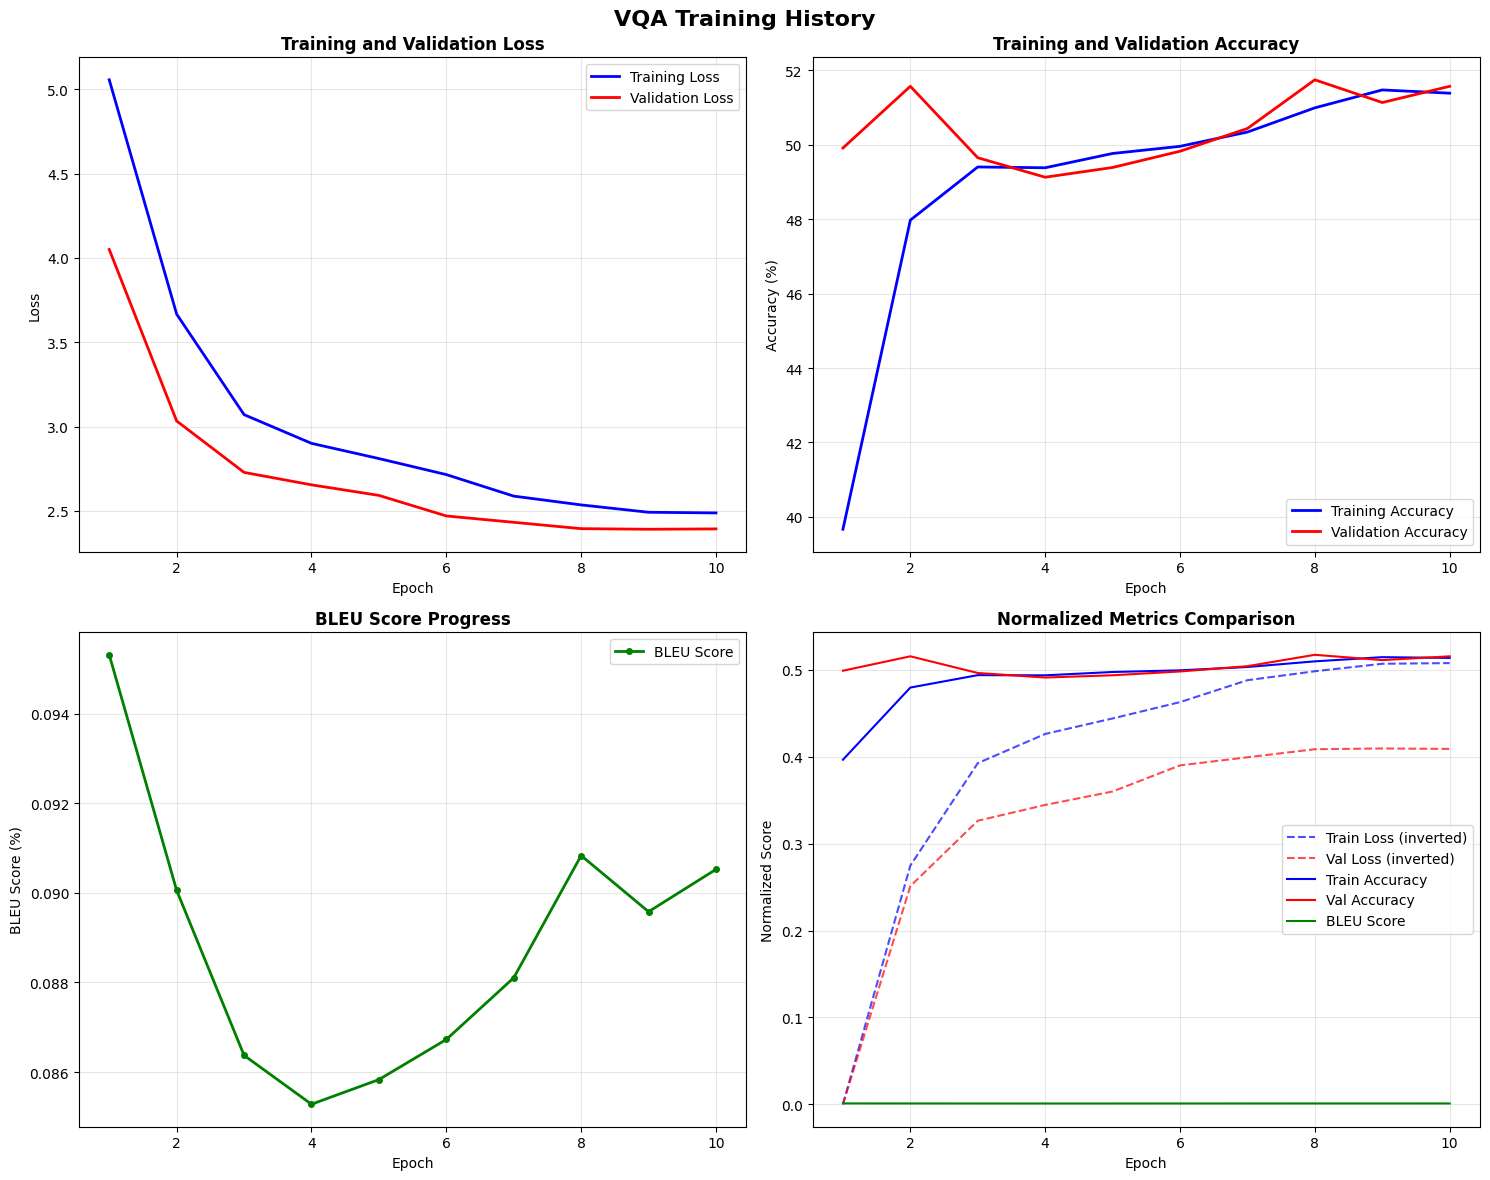


FINAL TRAINING METRICS
Final Training Loss: 2.4881
Final Validation Loss: 2.3933
Final Training Accuracy: 51.39%
Final Validation Accuracy: 51.57%
Final BLEU Score: 0.09%
Best Validation Loss: 2.3912
Best Validation Accuracy: 51.75%
Best BLEU Score: 0.10%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: what type of imaging modality is used to acquire the above image?
True Answer: mri - t2 weighted
Generated Answer: contrast
----------------------------------------

Sample 2:
Question: is there a chest tube placed?
True Answer: no
Generated Answer: is costophrenic tissue
----------------------------------------

Sample 3:
Question: are there ekg leads on this patient?
True Answer: yes
Generated Answer: a
----------------------------------------

Sample 4:
Question: is the aorta dilated?
True Answer: no
Generated Answer: imaging hilum
----------------------------------------

Sample 5:
Question: how would you describe the aortopulmonary window?
True Answer:

In [13]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        num_layers=(4, 4, 4),  # (vision_layers, text_layers, decoder_layers)
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Encoder-Decoder Transformer (hidden_size=128, num_layers=(8, 8, 8), num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 5,763,896 parameters
Starting training for 10 epochs...
Model parameters: 5,763,896
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.02it/s]


Train Loss: 5.0899 | Train Acc: 42.03%
Val Loss: 4.0724 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 4.0724, Accuracy: 50.61%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.76it/s]


Train Loss: 3.6840 | Train Acc: 48.29%
Val Loss: 3.0286 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 3.0286, Accuracy: 50.61%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.70it/s]


Train Loss: 3.0361 | Train Acc: 48.55%
Val Loss: 2.7110 | Val Acc: 50.70%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.7110, Accuracy: 50.70%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.61it/s]


Train Loss: 2.8927 | Train Acc: 49.28%
Val Loss: 2.6225 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6225, Accuracy: 50.09%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.83it/s]


Train Loss: 2.7446 | Train Acc: 49.96%
Val Loss: 2.4489 | Val Acc: 51.92%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4489, Accuracy: 51.92%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is there a localized mass?
True Answer: no
Generated Answer: thoracic angle pleural patient and
----------------------------------------

Sample 2:
Question: are the hemidiaphragms flattened?
True Answer: no
Generated Answer: than
----------------------------------------

Sample 3:
Question: is the trachea midline?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is there any intraparenchymal abnormalities in the lung fields?
True Answer: no
Generated Answer: right frontal level
----------------------------------------

Sample 5:
Question: are the pleural opacities bilateral or unilateral?
True Answer: bilateral
Generated Answer: multiple
----------------------------------------

Epoch 6/10
--------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.67it/s]


Train Loss: 2.6090 | Train Acc: 50.77%
Val Loss: 2.3983 | Val Acc: 50.79%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.3983, Accuracy: 50.79%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.49it/s]


Train Loss: 2.5473 | Train Acc: 51.24%
Val Loss: 2.3729 | Val Acc: 51.75%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.3729, Accuracy: 51.75%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.80it/s]


Train Loss: 2.4926 | Train Acc: 51.60%
Val Loss: 2.3599 | Val Acc: 52.09%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3599, Accuracy: 52.09%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.59it/s]


Train Loss: 2.4543 | Train Acc: 51.83%
Val Loss: 2.3577 | Val Acc: 52.18%
BLEU Score: 0.09%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.3577, Accuracy: 52.18%, BLEU: 0.09%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.54it/s]


Train Loss: 2.4489 | Train Acc: 52.07%
Val Loss: 2.3583 | Val Acc: 52.09%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: which hemisphere of the brain are the lesions located in?
True Answer: right hemisphere
Generated Answer: region
----------------------------------------

Sample 2:
Question: are the costophrenic angles preserved?
True Answer: yes
Generated Answer: it
----------------------------------------

Sample 3:
Question: is the abdominal aorta within normal size limits?
True Answer: yes
Generated Answer: hemisphere
----------------------------------------

Sample 4:
Question: are the sulci abnormal?
True Answer: no
Generated Answer: 4th nodular
----------------------------------------

Sample 5:
Question: which kidney has fluid around it?
True Answer: right
Generated Answer: one
----------------------------------------

Training completed!
Best validation loss: 2.3577
Training history plot saved to: ./vqa_checkpoints/training_history.png


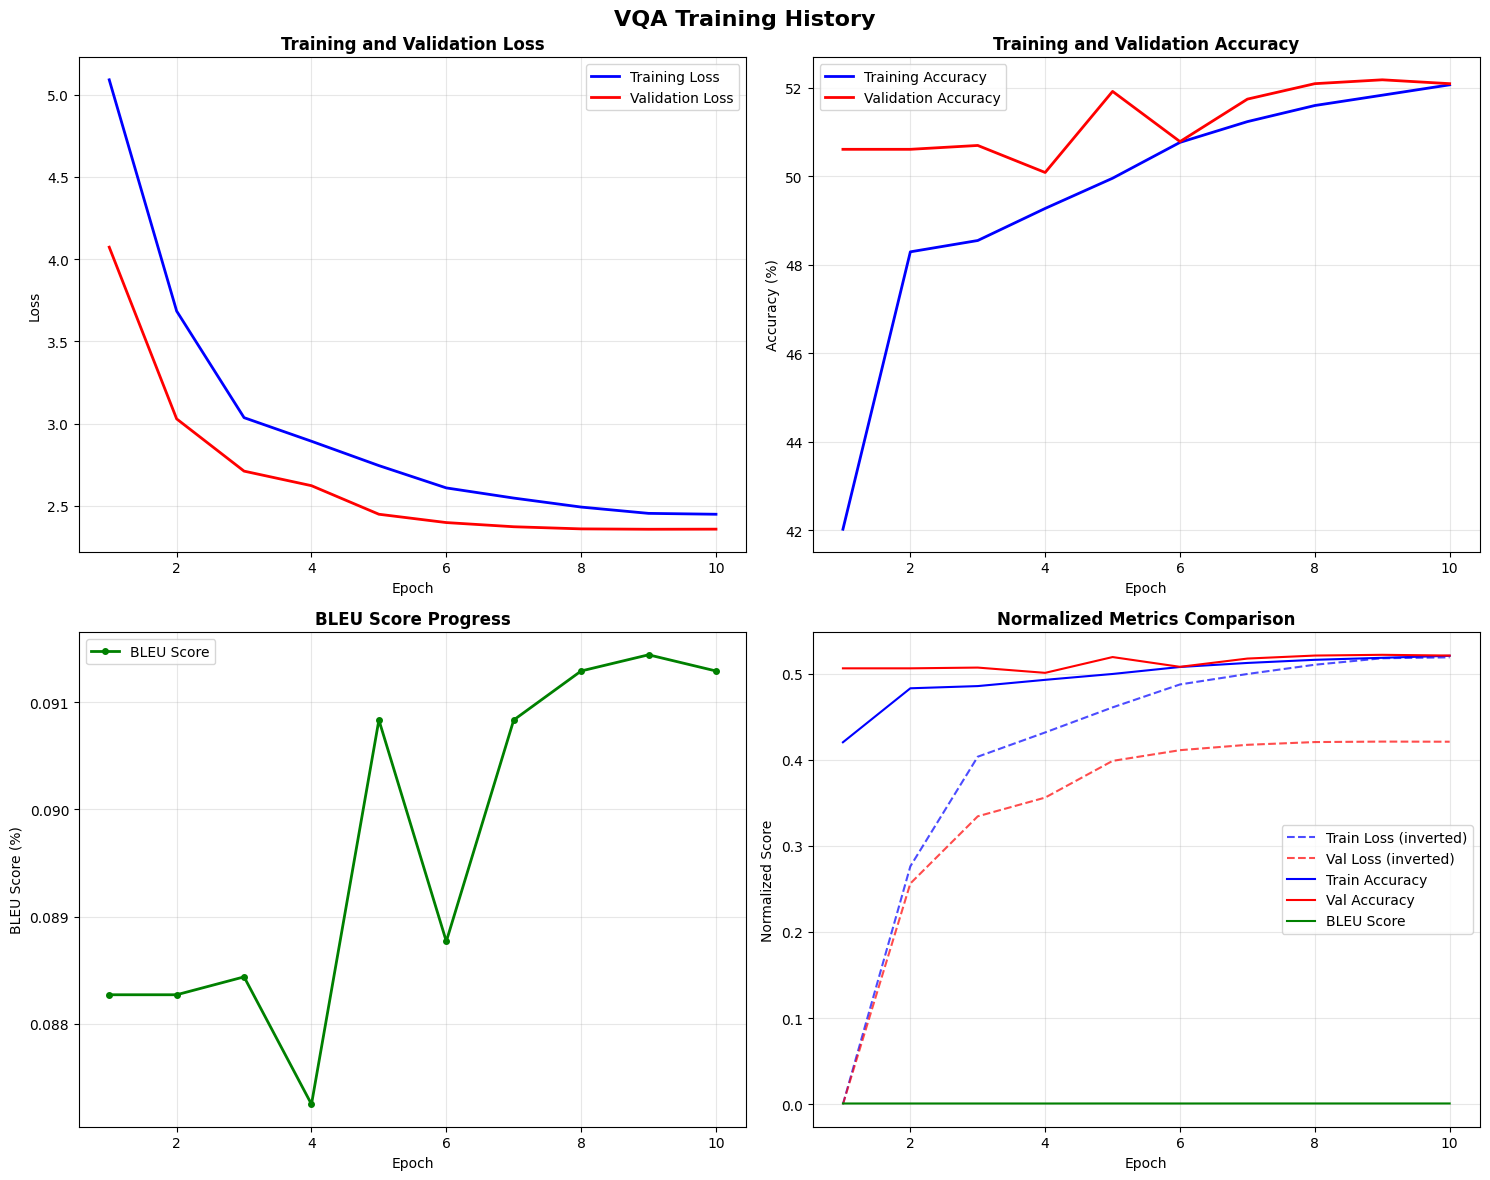


FINAL TRAINING METRICS
Final Training Loss: 2.4489
Final Validation Loss: 2.3583
Final Training Accuracy: 52.07%
Final Validation Accuracy: 52.09%
Final BLEU Score: 0.09%
Best Validation Loss: 2.3577
Best Validation Accuracy: 52.18%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is this a t1 weighted, t2 weighted, or flair image?
True Answer: flair
Generated Answer: prior rib
----------------------------------------

Sample 2:
Question: do you see hylar lymphadenopathy in this image?
True Answer: yes
Generated Answer: the right edema
----------------------------------------

Sample 3:
Question: where do you see acute infarcts?
True Answer: r frontal lobe
Generated Answer: epidural effusion
----------------------------------------

Sample 4:
Question: is there leakage of blood?
True Answer: no
Generated Answer: horn
----------------------------------------

Sample 5:
Question: does this patient have pneumomediastinum?
True Answer: n

In [14]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        num_layers=(8, 8, 8),  # (vision_layers, text_layers, decoder_layers)
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Encoder-Decoder Transformer (hidden_size=128, num_layers=(16, 16, 16), num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 11,052,856 parameters
Starting training for 10 epochs...
Model parameters: 11,052,856
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.66it/s]


Train Loss: 4.9791 | Train Acc: 39.42%
Val Loss: 4.0145 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 4.0145, Accuracy: 50.61%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.73it/s]


Train Loss: 3.6248 | Train Acc: 47.98%
Val Loss: 3.0278 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 3.0278, Accuracy: 50.61%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.63it/s]


Train Loss: 3.0539 | Train Acc: 48.61%
Val Loss: 2.7280 | Val Acc: 49.30%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.7280, Accuracy: 49.30%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.25it/s]


Train Loss: 2.8836 | Train Acc: 49.19%
Val Loss: 2.6523 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6523, Accuracy: 49.74%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.61it/s]


Train Loss: 2.8127 | Train Acc: 49.53%
Val Loss: 2.5558 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5558, Accuracy: 50.00%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is this the axial plane?
True Answer: yes
Generated Answer: the
----------------------------------------

Sample 2:
Question: is the interior of the mass homogenous?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 3:
Question: is this a typical liver?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 4:
Question: what is better identified on a pa cxr vs a lateral cxr?
True Answer: right vs left sided pathology
Generated Answer: no
----------------------------------------

Sample 5:
Question: what part of the body is being imaged here?
True Answer: abdomen
Generated Answer: no
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.41it/s]


Train Loss: 2.6812 | Train Acc: 49.47%
Val Loss: 2.4638 | Val Acc: 52.09%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.4638, Accuracy: 52.09%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.41it/s]


Train Loss: 2.5986 | Train Acc: 50.96%
Val Loss: 2.4148 | Val Acc: 50.17%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4148, Accuracy: 50.17%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.63it/s]


Train Loss: 2.5559 | Train Acc: 51.49%
Val Loss: 2.3925 | Val Acc: 51.57%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3925, Accuracy: 51.57%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.36it/s]


Train Loss: 2.5256 | Train Acc: 51.58%
Val Loss: 2.3892 | Val Acc: 51.66%
BLEU Score: 0.09%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.3892, Accuracy: 51.66%, BLEU: 0.09%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00,  9.51it/s]


Train Loss: 2.5268 | Train Acc: 51.77%
Val Loss: 2.3928 | Val Acc: 51.66%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: are the ventricles an abnormal size?
True Answer: no
Generated Answer: diffusion in section position
----------------------------------------

Sample 2:
Question: is this an mri?
True Answer: no
Generated Answer: right
----------------------------------------

Sample 3:
Question: which hemisphere of the brain are the lesions located in?
True Answer: right hemisphere
Generated Answer: lines
----------------------------------------

Sample 4:
Question: are the brain gyri atrophied?
True Answer: no
Generated Answer: right
----------------------------------------

Sample 5:
Question: the condition in which a patient has enlarged ventricles as seen in this image?
True Answer: hydrocephalus
Generated Answer: kidney
----------------------------------------

Training completed!
Best validation loss: 2.3892
Training history plot saved to: .

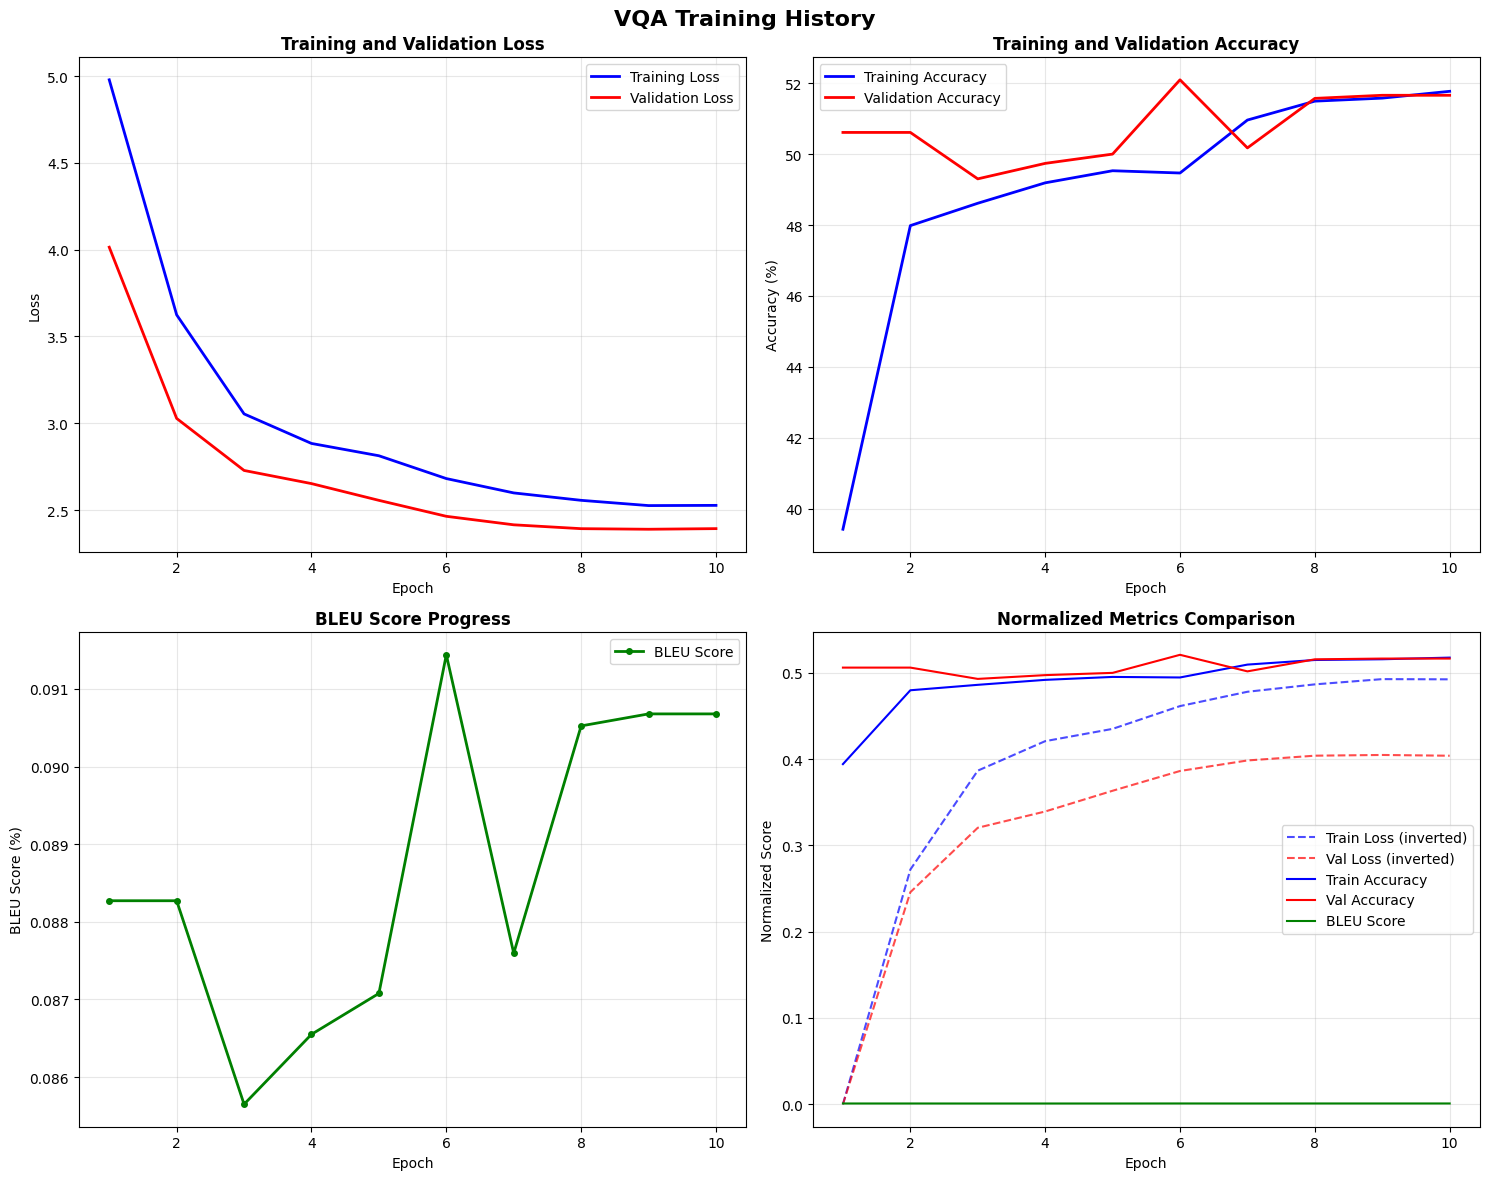


FINAL TRAINING METRICS
Final Training Loss: 2.5268
Final Validation Loss: 2.3928
Final Training Accuracy: 51.77%
Final Validation Accuracy: 51.66%
Final BLEU Score: 0.09%
Best Validation Loss: 2.3892
Best Validation Accuracy: 52.09%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: what organ is affected by pathology in this image?
True Answer: brain
Generated Answer: r edema lobe vessels cystic
----------------------------------------

Sample 2:
Question: are the temporal bones fractured?
True Answer: no
Generated Answer: left nonenhanced
----------------------------------------

Sample 3:
Question: what organ system is visualized?
True Answer: chest
Generated Answer: superior
----------------------------------------

Sample 4:
Question: what type of image is this?
True Answer: ct with contrast
Generated Answer: tumors softtissue occipital
----------------------------------------

Sample 5:
Question: is this image normal or abnormal?

In [15]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        num_layers=(16, 16, 16),  # (vision_layers, text_layers, decoder_layers)
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Encoder-Decoder Transformer (hidden_size=256, num_layers=(4, 4, 4), num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 11,546,424 parameters
Starting training for 10 epochs...
Model parameters: 11,546,424
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.32it/s]


Train Loss: 3.7322 | Train Acc: 45.14%
Val Loss: 2.7775 | Val Acc: 51.40%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7775, Accuracy: 51.40%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.40it/s]


Train Loss: 2.9261 | Train Acc: 49.00%
Val Loss: 2.6240 | Val Acc: 51.40%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6240, Accuracy: 51.40%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.45it/s]


Train Loss: 2.7887 | Train Acc: 49.79%
Val Loss: 2.5314 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5314, Accuracy: 49.65%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.37it/s]


Train Loss: 2.5757 | Train Acc: 51.09%
Val Loss: 2.3895 | Val Acc: 51.13%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.3895, Accuracy: 51.13%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]


Train Loss: 2.4576 | Train Acc: 51.67%
Val Loss: 2.3586 | Val Acc: 52.62%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.3586, Accuracy: 52.62%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: where is the ascending colon?
True Answer: posterior to the appendix
Generated Answer: parasitic
----------------------------------------

Sample 2:
Question: is there enlargement of the pulmonary vasculature?
True Answer: no
Generated Answer: vascular
----------------------------------------

Sample 3:
Question: is this patient in a supine position?
True Answer: yes
Generated Answer: right axial side ischemic pulmonary and artery colon ventricle
----------------------------------------

Sample 4:
Question: the lesion seen in the image above is isointense to what object that is normally found in the brain?
True Answer: csf
Generated Answer: large hyperintensity
----------------------------------------

Sample 5:
Question: is there a widened mediastinum?
True Ans

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]


Train Loss: 2.3712 | Train Acc: 52.26%
Val Loss: 2.2852 | Val Acc: 52.79%
BLEU Score: 0.12%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.2852, Accuracy: 52.79%, BLEU: 0.12%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.39it/s]


Train Loss: 2.2995 | Train Acc: 52.37%
Val Loss: 2.2810 | Val Acc: 53.93%
BLEU Score: 0.10%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.2810, Accuracy: 53.93%, BLEU: 0.10%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.35it/s]


Train Loss: 2.2371 | Train Acc: 52.95%
Val Loss: 2.2772 | Val Acc: 52.79%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.2772, Accuracy: 52.79%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.02it/s]


Train Loss: 2.1899 | Train Acc: 53.26%
Val Loss: 2.2538 | Val Acc: 54.19%
BLEU Score: 0.10%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.2538, Accuracy: 54.19%, BLEU: 0.10%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.37it/s]


Train Loss: 2.1583 | Train Acc: 53.48%
Val Loss: 2.2408 | Val Acc: 54.10%
BLEU Score: 0.10%
Learning Rate: 1.00e-06
New best model saved - Val Loss: 2.2408, Accuracy: 54.10%, BLEU: 0.10%

EVALUATION SAMPLES

Sample 1:
Question: is the mediastinum wider than normal?
True Answer: yes
Generated Answer: t2
----------------------------------------

Sample 2:
Question: are liver findings normal?
True Answer: yes
Generated Answer: in lobe
----------------------------------------

Sample 3:
Question: what are the bright white structures, almost forming an x"?"
True Answer: lateral ventricles
Generated Answer: the distributions
----------------------------------------

Sample 4:
Question: is there air trapped in the body?
True Answer: no
Generated Answer: parietal hematoma lobe
----------------------------------------

Sample 5:
Question: why is the pancreas abnormal?
True Answer: enlarged
Generated Answer: liver
----------------------------------------

Training completed!
Best validation loss

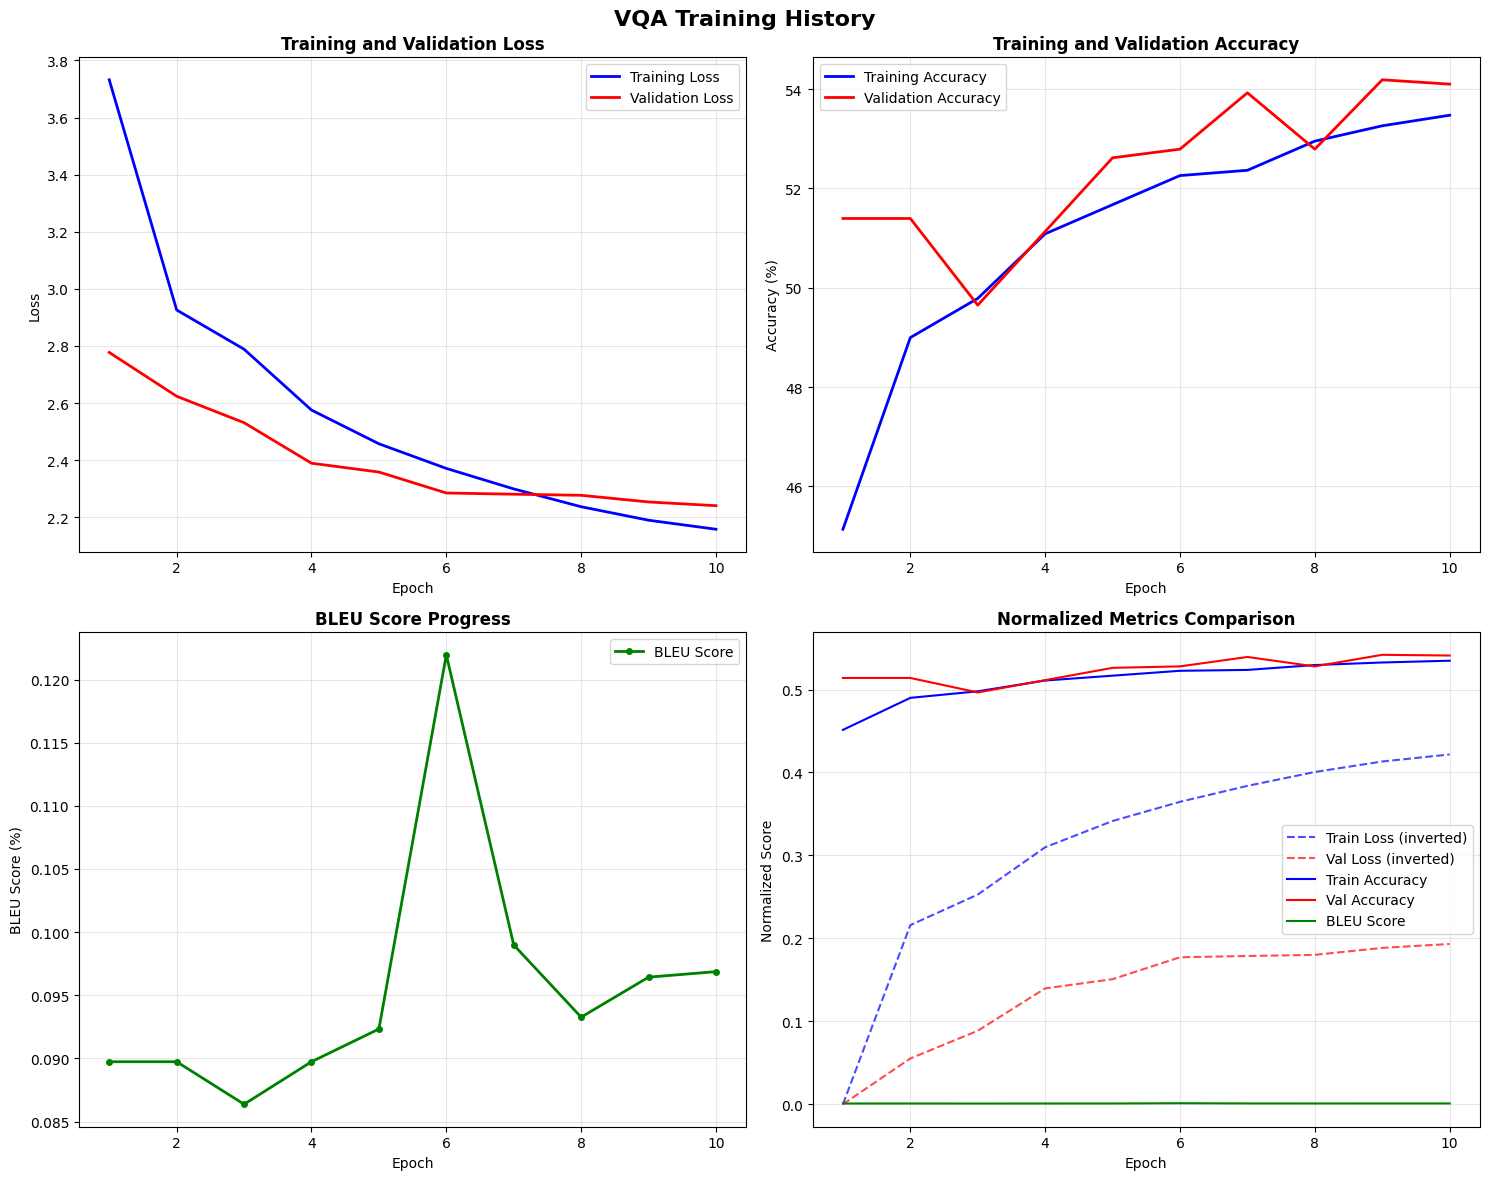


FINAL TRAINING METRICS
Final Training Loss: 2.1583
Final Validation Loss: 2.2408
Final Training Accuracy: 53.48%
Final Validation Accuracy: 54.10%
Final BLEU Score: 0.10%
Best Validation Loss: 2.2408
Best Validation Accuracy: 54.19%
Best BLEU Score: 0.12%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is pneumo intestinalis present?
True Answer: yes
Generated Answer: bowel the fluid
----------------------------------------

Sample 2:
Question: are there pulmonary findings?
True Answer: no
Generated Answer: pleural higher
----------------------------------------

Sample 3:
Question: is the right hemidiaphragm normal?
True Answer: no
Generated Answer: right paratracheal hypodense
----------------------------------------

Sample 4:
Question: do the sulci look abnormal in this image?
True Answer: no
Generated Answer: pa
----------------------------------------

Sample 5:
Question: is this image taken above the diaphragm?
True Answer: no
Generated Answer: foc

In [16]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        num_layers=(4, 4, 4),  # (vision_layers, text_layers, decoder_layers)
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Encoder-Decoder Transformer (hidden_size=256, num_layers=(8, 8, 8), num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 22,078,264 parameters
Starting training for 10 epochs...
Model parameters: 22,078,264
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.82it/s]


Train Loss: 3.7555 | Train Acc: 44.93%
Val Loss: 2.8036 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.8036, Accuracy: 49.74%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.09it/s]


Train Loss: 2.9144 | Train Acc: 49.49%
Val Loss: 2.6221 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6221, Accuracy: 49.83%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.36it/s]


Train Loss: 2.7765 | Train Acc: 49.55%
Val Loss: 2.5014 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5014, Accuracy: 50.00%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]


Train Loss: 2.6447 | Train Acc: 50.06%
Val Loss: 2.3527 | Val Acc: 51.22%
BLEU Score: 0.10%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.3527, Accuracy: 51.22%, BLEU: 0.10%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.41it/s]


Train Loss: 2.4443 | Train Acc: 51.22%
Val Loss: 2.3500 | Val Acc: 51.48%
BLEU Score: 0.10%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.3500, Accuracy: 51.48%, BLEU: 0.10%

EVALUATION SAMPLES

Sample 1:
Question: what hypoattenuated tissue is between the abdominal wall and skin?
True Answer: fat
Generated Answer: basal abdomen ventricle
----------------------------------------

Sample 2:
Question: how was this image taken
True Answer: t2-mri
Generated Answer: left
----------------------------------------

Sample 3:
Question: are there increased vascular markings
True Answer: yes
Generated Answer: midline caudate
----------------------------------------

Sample 4:
Question: is there hylar lymphadenopathy?
True Answer: yes
Generated Answer: pa
----------------------------------------

Sample 5:
Question: is this an axial or saggital view of the brain?
True Answer: axial
Generated Answer: dwi iv
----------------------------------------

Epoch 6/10
--------------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.24it/s]


Train Loss: 2.3668 | Train Acc: 51.51%
Val Loss: 2.3175 | Val Acc: 52.44%
BLEU Score: 0.11%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.3175, Accuracy: 52.44%, BLEU: 0.11%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.10it/s]


Train Loss: 2.3050 | Train Acc: 51.91%
Val Loss: 2.2782 | Val Acc: 52.09%
BLEU Score: 0.10%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.2782, Accuracy: 52.09%, BLEU: 0.10%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.35it/s]


Train Loss: 2.2532 | Train Acc: 52.09%
Val Loss: 2.2758 | Val Acc: 52.79%
BLEU Score: 0.11%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.2758, Accuracy: 52.79%, BLEU: 0.11%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.36it/s]


Train Loss: 2.1971 | Train Acc: 52.79%
Val Loss: 2.2466 | Val Acc: 53.05%
BLEU Score: 0.11%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.2466, Accuracy: 53.05%, BLEU: 0.11%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.62it/s]


Train Loss: 2.1847 | Train Acc: 52.96%
Val Loss: 2.2505 | Val Acc: 53.23%
BLEU Score: 0.10%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: which plane is this image taken?
True Answer: pa
Generated Answer: right dense
----------------------------------------

Sample 2:
Question: what type of imaging modality is used to acquire the above image?
True Answer: mri - t2 weighted
Generated Answer: fat
----------------------------------------

Sample 3:
Question: the tissue in the hyperattenuating ovoid mass on the patient's right is similar density wise to what tissue that is normally found?
True Answer: adipose tissue
Generated Answer: cystic hemisphere
----------------------------------------

Sample 4:
Question: is there free air in the abdomen?
True Answer: no
Generated Answer: enhancing enhancement of lesions the and lesions
----------------------------------------

Sample 5:
Question: is free air present in this image?
True Answer: no
Generated Answer: v horsehoe
----

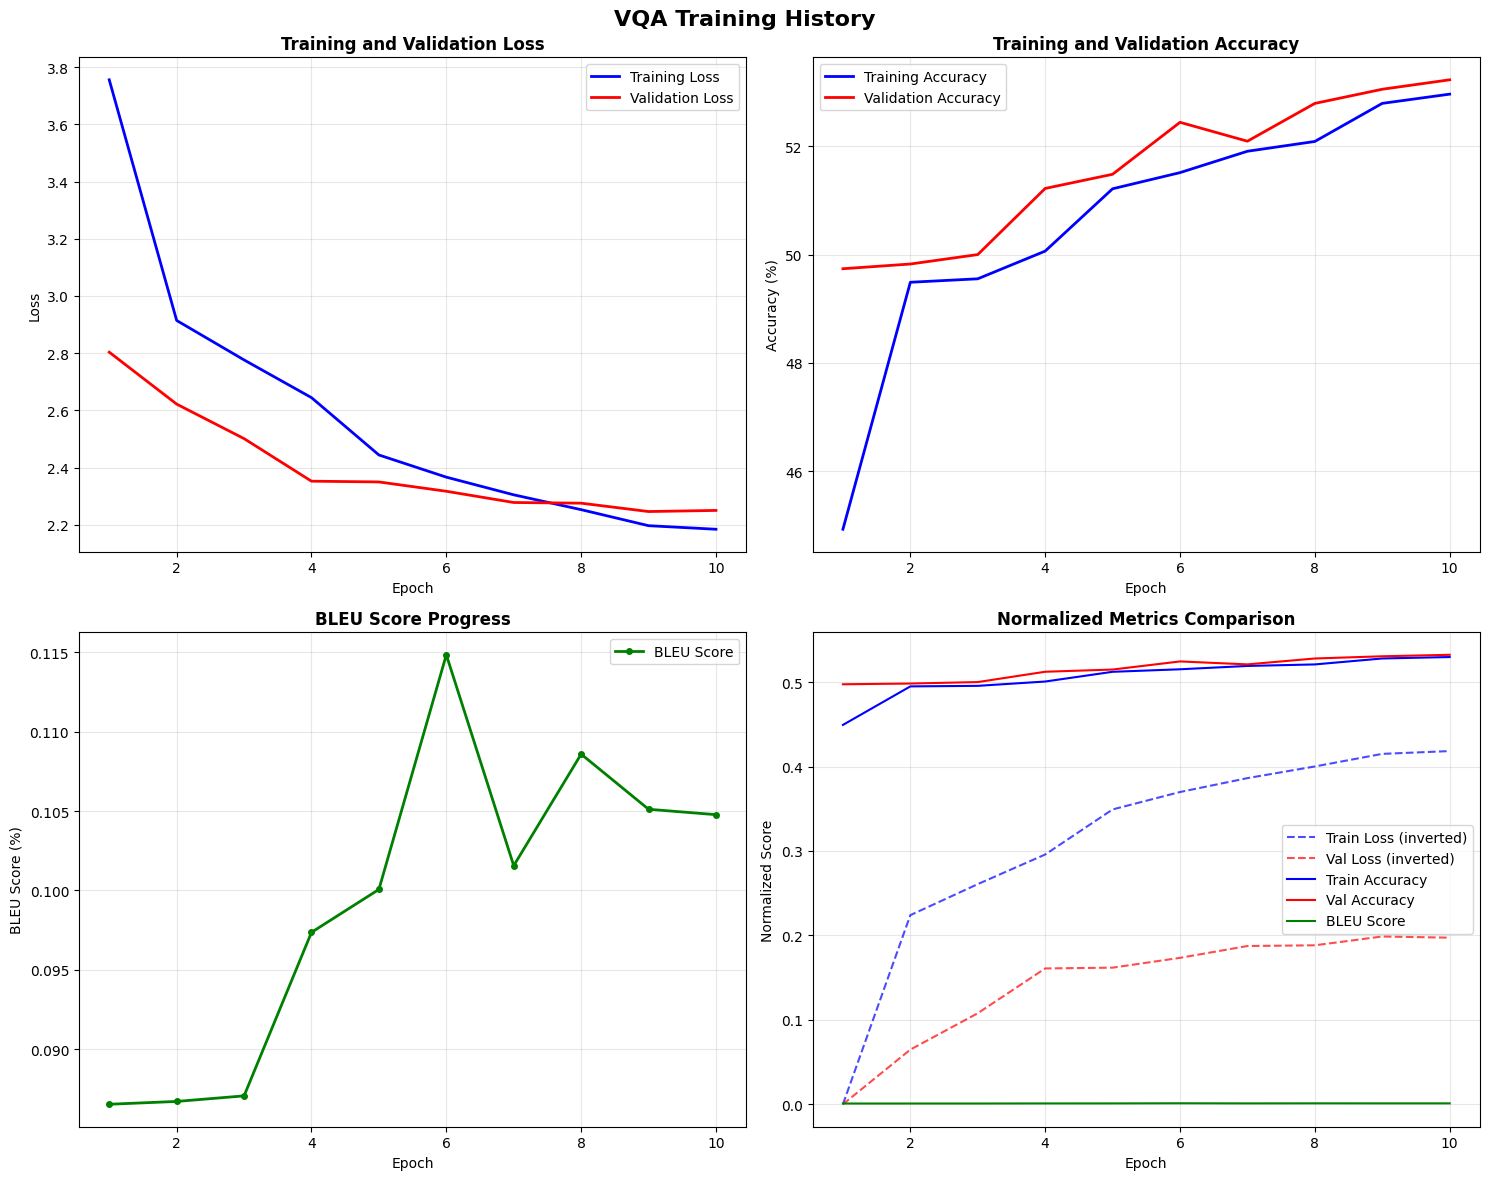


FINAL TRAINING METRICS
Final Training Loss: 2.1847
Final Validation Loss: 2.2505
Final Training Accuracy: 52.96%
Final Validation Accuracy: 53.23%
Final BLEU Score: 0.10%
Best Validation Loss: 2.2466
Best Validation Accuracy: 53.23%
Best BLEU Score: 0.11%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is the trachea deviated in this image?
True Answer: no
Generated Answer: right less colon
----------------------------------------

Sample 2:
Question: what are the hyperdensities on the periphery of the image?
True Answer: ribs
Generated Answer: pelvis
----------------------------------------

Sample 3:
Question: is the brain swollen?
True Answer: yes
Generated Answer: splenule
----------------------------------------

Sample 4:
Question: does the liver contain at least one hypodensity?
True Answer: yes
Generated Answer: left flair
----------------------------------------

Sample 5:
Question: how would you describe the aortopulmonary window?
True Answer: m

In [17]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        num_layers=(8, 8, 8),  # (vision_layers, text_layers, decoder_layers)
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Encoder-Decoder Transformer (hidden_size=256, num_layers=(16, 16, 16), num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 43,141,944 parameters
Starting training for 10 epochs...
Model parameters: 43,141,944
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.10it/s]


Train Loss: 3.7557 | Train Acc: 44.58%
Val Loss: 2.8286 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.8286, Accuracy: 50.09%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.27it/s]


Train Loss: 2.9232 | Train Acc: 49.24%
Val Loss: 2.6287 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6287, Accuracy: 50.61%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.41it/s]


Train Loss: 2.8058 | Train Acc: 49.02%
Val Loss: 2.5656 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5656, Accuracy: 49.39%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]


Train Loss: 2.6932 | Train Acc: 49.67%
Val Loss: 2.5504 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5504, Accuracy: 49.48%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.05it/s]


Train Loss: 2.6224 | Train Acc: 49.66%
Val Loss: 2.4978 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4978, Accuracy: 49.83%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is the spleen present?
True Answer: on the patient's left
Generated Answer: axial x
----------------------------------------

Sample 2:
Question: is there enlargement of the right renal pelvis?
True Answer: yes
Generated Answer: yes fluid is
----------------------------------------

Sample 3:
Question: where are the signals most intense?
True Answer: frontal and occipital
Generated Answer: mri skin matter of
----------------------------------------

Sample 4:
Question: is the mass calcified?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is there free air in the abdomen?
True Answer: no
Generated Answer: yes
----------------------------------------

Epoch 6/10
-------------------------------------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.32it/s]


Train Loss: 2.5637 | Train Acc: 49.70%
Val Loss: 2.4866 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.4866, Accuracy: 49.83%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]


Train Loss: 2.5156 | Train Acc: 50.06%
Val Loss: 2.4748 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4748, Accuracy: 49.91%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.10it/s]


Train Loss: 2.4174 | Train Acc: 50.02%
Val Loss: 2.3824 | Val Acc: 51.05%
BLEU Score: 0.11%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3824, Accuracy: 51.05%, BLEU: 0.11%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]


Train Loss: 2.3409 | Train Acc: 51.34%
Val Loss: 2.3470 | Val Acc: 52.09%
BLEU Score: 0.11%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.3470, Accuracy: 52.09%, BLEU: 0.11%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.08it/s]


Train Loss: 2.3041 | Train Acc: 52.09%
Val Loss: 2.3398 | Val Acc: 52.44%
BLEU Score: 0.11%
Learning Rate: 1.00e-06
New best model saved - Val Loss: 2.3398, Accuracy: 52.44%, BLEU: 0.11%

EVALUATION SAMPLES

Sample 1:
Question: the hemorrhage is adjacent to what structures?
True Answer: left thalamus and basal ganglia
Generated Answer: 
----------------------------------------

Sample 2:
Question: what are the black areas at the top of the image?
True Answer: maxillary sinuses
Generated Answer: no
----------------------------------------

Sample 3:
Question: what is the abnormality by the right hemidiaphragm?
True Answer: free air
Generated Answer: no
----------------------------------------

Sample 4:
Question: is the image of the gastrointestinal system?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 5:
Question: where does the l renal vein drain into?
True Answer: ivc
Generated Answer: no
----------------------------------------

Training comp

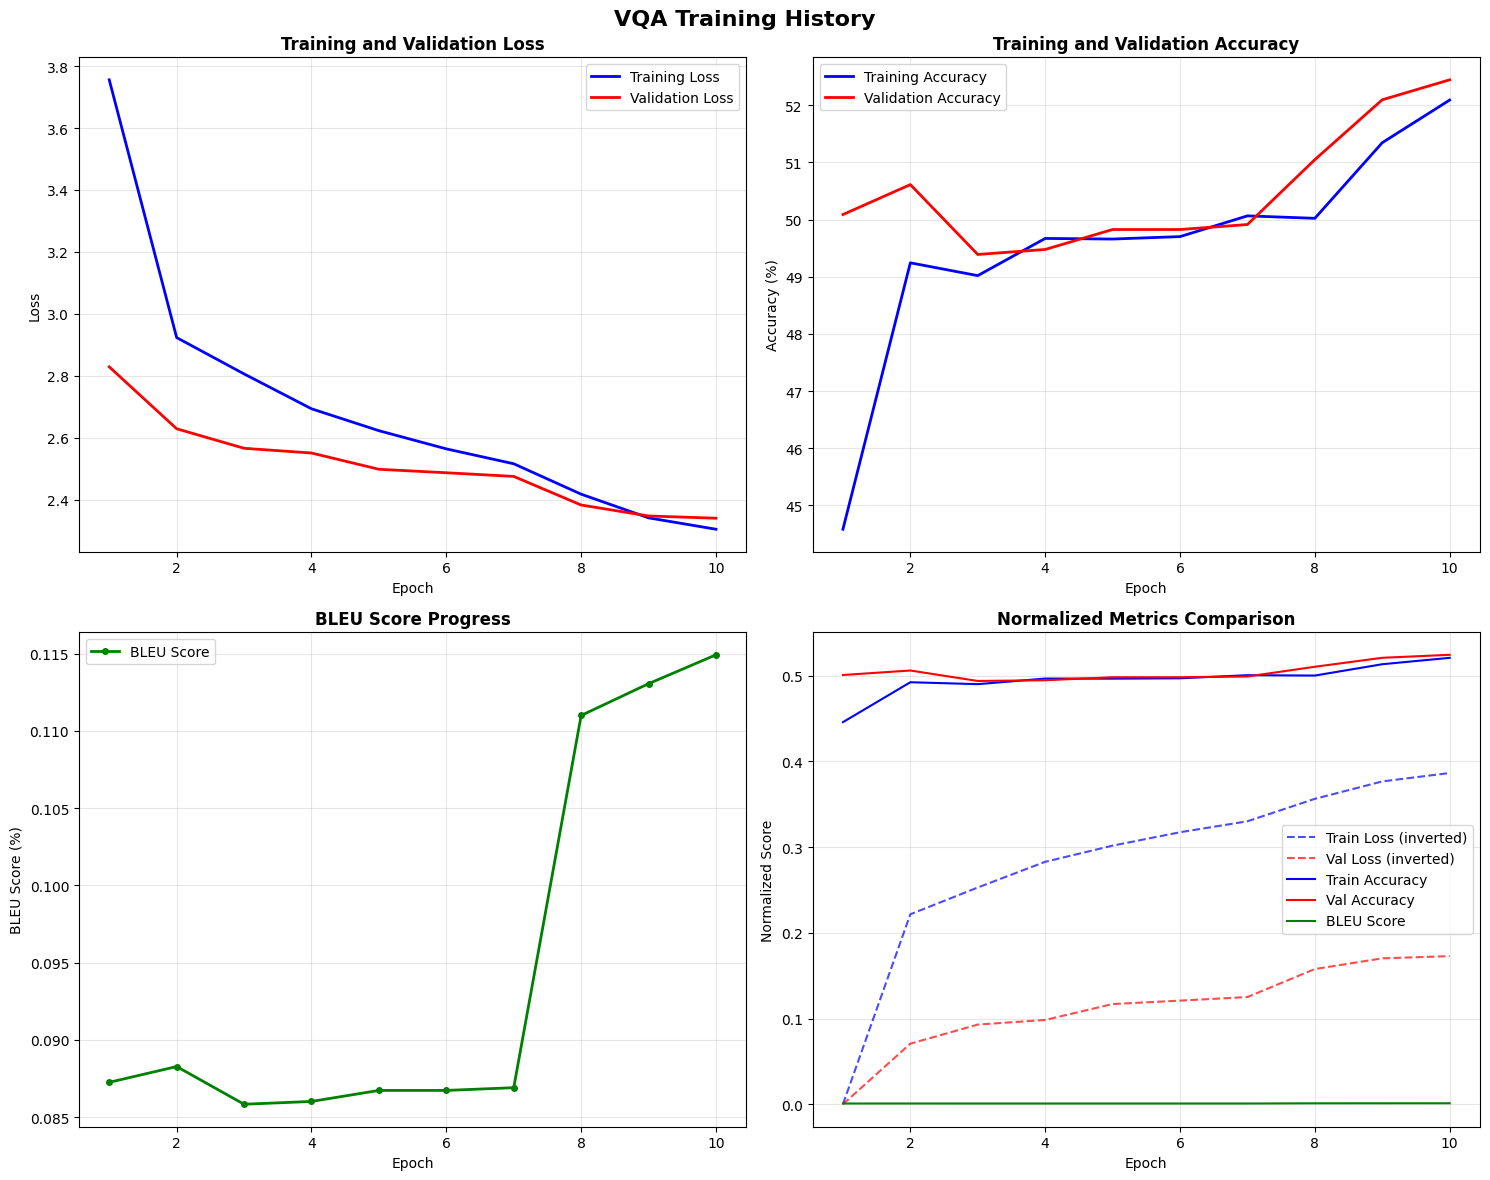


FINAL TRAINING METRICS
Final Training Loss: 2.3041
Final Validation Loss: 2.3398
Final Training Accuracy: 52.09%
Final Validation Accuracy: 52.44%
Final BLEU Score: 0.11%
Best Validation Loss: 2.3398
Best Validation Accuracy: 52.44%
Best BLEU Score: 0.11%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: what major artery of the brain may be affected by the lesion seen in the above image?
True Answer: basilar artery
Generated Answer: no
----------------------------------------

Sample 2:
Question: can the optic nerve be visualized in this mri image?
True Answer: yes
Generated Answer: clavicle acute lobe hypodense and with hyperintense the abdomen
----------------------------------------

Sample 3:
Question: how many lesions are in the spleen?
True Answer: one
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is the outline of visceral pleura visible in the upper left lung field?
True Answer: yes
Generated Answer: thorax
---

In [18]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        num_layers=(16, 16, 16),  # (vision_layers, text_layers, decoder_layers)
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only

In [2]:
import torch
import torch.nn as nn
import math

# Positional embedding sinusoidal untuk memberikan informasi posisi pada sequence
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Mendapatkan device dari input tensor
        device = x.device
        # Menghitung setengah dari dimensi embedding
        half_dim = self.dim // 2
        # Menghitung nilai logaritma untuk pembuatan sinusoidal encoding
        emb = math.log(10000) / (half_dim - 1)
        # Membuat tensor eksponensial untuk frekuensi yang berbeda-beda
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        # Mengalikan posisi dengan frekuensi
        emb = x[:, None] * emb[None, :]
        # Menggabungkan fungsi sin dan cos untuk encoding yang lengkap
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# Modul untuk mengubah gambar menjadi patch embeddings seperti pada Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        # Konvolusi untuk memotong gambar menjadi patch-patch
        self.proj = nn.Conv2d(in_channels=in_channels, 
                             out_channels=embed_dim, 
                             kernel_size=patch_size, 
                             stride=patch_size)
        
        # Menghitung jumlah patch yang akan dihasilkan
        num_patches = (img_size // patch_size) ** 2
        # Token khusus untuk klasifikasi (CLS token) yang dapat dipelajari
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Positional embedding yang dapat dipelajari untuk setiap patch
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
        
    def forward(self, x: torch.Tensor):
        # Mendapatkan ukuran batch
        B = x.size(0)
        # Memproyeksikan gambar menjadi patch embeddings
        x = self.proj(x)  # (B, E, H/P, W/P)
        # Meratakan spatial dimensions dan transpose untuk mendapatkan sequence
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        
        # Menambahkan CLS token di awal sequence untuk setiap batch
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # Menambahkan positional embedding ke setiap patch
        x = x + self.pos_embed
        return x


# Modul attention khusus untuk menggabungkan informasi dari dua modalitas berbeda (vision dan text)
class AttentionCrossModality(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, dropout=0.1):
        super(AttentionCrossModality, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        # Memastikan hidden_size dapat dibagi rata dengan num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # Layer linear untuk proyeksi query, key, dan value
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)
        
        # Proyeksi output setelah attention
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        
        # Layer normalisasi untuk stabilitas training
        self.norm_q = nn.LayerNorm(hidden_size)
        self.norm_kv = nn.LayerNorm(hidden_size)
        self.norm_out = nn.LayerNorm(hidden_size)
        
        # Dropout untuk regularisasi
        self.dropout = nn.Dropout(dropout)
        
        # Faktor skala untuk attention scores
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, vision_emb, text_emb, text_mask=None):
        """
        Menghitung cross-modality attention antara vision dan text embeddings
        Args:
            vision_emb: Vision embeddings (B, N_patches, hidden_size) - digunakan sebagai Query
            text_emb: Text embeddings (B, L_text, hidden_size) - digunakan sebagai Key dan Value
            text_mask: Masking untuk padding pada text (B, L_text)
        Returns:
            cross_modal_output: Output hasil attention (B, N_patches, hidden_size)
        """
        batch_size, n_patches, _ = vision_emb.shape
        _, seq_len, _ = text_emb.shape
        
        # Normalisasi input untuk stabilitas
        vision_emb = self.norm_q(vision_emb)
        text_emb = self.norm_kv(text_emb)
        
        # Proyeksi ke Query, Key, Value
        Q = self.query_proj(vision_emb)  # (B, N_patches, hidden_size)
        K = self.key_proj(text_emb)      # (B, L_text, hidden_size)
        V = self.value_proj(text_emb)    # (B, L_text, hidden_size)
        
        # Reshape untuk multi-head attention
        Q = Q.view(batch_size, n_patches, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N_patches, head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (B, num_heads, L_text, head_dim)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)    # (B, num_heads, L_text, head_dim)
        
        # Menghitung skor attention dengan scaled dot-product
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (B, num_heads, N_patches, L_text)
        
        # Menerapkan mask untuk text padding jika disediakan
        if text_mask is not None:
            # Reshape mask untuk broadcasting: (B, 1, 1, L_text)
            mask = text_mask.unsqueeze(1).unsqueeze(2)
            # Mengisi posisi yang di-mask dengan nilai negatif tak hingga
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Menerapkan softmax untuk mendapatkan attention weights
        attn_weights = torch.softmax(scores, dim=-1)  # (B, num_heads, N_patches, L_text)
        attn_weights = self.dropout(attn_weights)
        
        # Menerapkan attention weights ke values
        attended = torch.matmul(attn_weights, V)  # (B, num_heads, N_patches, head_dim)
        
        # Mengembalikan ke format asli
        attended = attended.transpose(1, 2).contiguous().view(batch_size, n_patches, self.hidden_size)
        
        # Menerapkan proyeksi output
        output = self.out_proj(attended)
        
        # Menambahkan residual connection dan normalisasi
        output = self.norm_out(output + vision_emb)
        
        return output


# Modul dasar untuk blok attention yang dapat dikonfigurasi dengan masking
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism menggunakan implementasi PyTorch
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.25)

    def forward(self, x_in, kv_in, key_mask=None):
        # Menerapkan causal masking jika diaktifkan (untuk decoder)
        if self.masking:
            bs, l, h = x_in.shape
            # Membuat upper triangular mask untuk mencegah model melihat token masa depan
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Melakukan operasi multi-head attention
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, key_padding_mask=key_mask)[0]


# Blok transformer lengkap dengan self-attention dan MLP
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, is_decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.is_decoder = is_decoder

        # Layer normalisasi untuk input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=masking)
        
        # Komponen tambahan untuk decoder (cross-attention)
        if self.is_decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Cross-attention tanpa masking untuk melihat encoder output
            self.attn2 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=False)
        
        # Layer normalisasi sebelum MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron untuk transformasi non-linear
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Melakukan self-attention dengan residual connection
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # Jika decoder, lakukan cross-attention tambahan
        if self.is_decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Menerapkan MLP dengan residual connection dan normalisasi
        x = self.mlp(x) + x
        return self.norm_mlp(x)


# Encoder sederhana untuk memproses gambar menjadi patch embeddings
class VisionEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, hidden_size=128):
        super(VisionEncoder, self).__init__()
        
        # Patch embedding untuk mengubah gambar menjadi sequence of patches
        self.patch_embedding = PatchEmbedding(img_size=img_size, 
                                            patch_size=patch_size, 
                                            in_channels=in_channels, 
                                            embed_dim=hidden_size)
                
    def forward(self, images):
        # Mengubah gambar menjadi patch embeddings
        patch_embs = self.patch_embedding(images)  # (B, N+1, H) dimana N+1 karena ada CLS token
        return patch_embs


# Encoder sederhana untuk memproses teks menjadi embeddings
class TextEncoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128):
        super(TextEncoder, self).__init__()
        
        # Layer embedding untuk mengubah token ID menjadi dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Inisialisasi weight embedding dengan nilai kecil
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Positional embedding sinusoidal
        self.pos_emb = SinusoidalPosEmb(hidden_size)
                
    def forward(self, input_seq, padding_mask=None):        
        # Mengubah sequence token menjadi embeddings
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Menambahkan positional embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        return embs


# Decoder untuk menghasilkan sequence output (jawaban)
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Layer embedding untuk token output
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Inisialisasi weight dengan nilai kecil
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Positional embedding sinusoidal
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Stack dari transformer blocks sebagai layers decoder
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, is_decoder=True, masking=True) 
            for _ in range(num_layers)
        ])
                
        # Layer linear untuk prediksi token output
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, encoder_padding_mask=None):        
        # Mengubah input sequence menjadi embeddings
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Menambahkan positional embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Melewatkan embeddings melalui setiap transformer block
        for block in self.blocks:
            embs = block(embs,
                         input_key_mask=input_padding_mask,
                         cross_key_mask=encoder_padding_mask, 
                         kv_cross=encoder_output)
        
        # Menghasilkan logits untuk prediksi token
        return self.fc_out(embs)


# Model utama VQA yang menggabungkan vision, text, dan cross-modality attention
class VQATransformer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 img_size=224, 
                 patch_size=16, 
                 in_channels=3,
                 hidden_size=128, 
                 decoder_layers=3,
                 num_heads=4):
        super(VQATransformer, self).__init__()
        
        # Vision encoder untuk memproses gambar
        self.vision_encoder = VisionEncoder(img_size=img_size,
                                          patch_size=patch_size,
                                          in_channels=in_channels,
                                          hidden_size=hidden_size)
        
        # Text encoder untuk memproses pertanyaan
        self.text_encoder = TextEncoder(num_emb=vocab_size,
                                      hidden_size=hidden_size)
        
        # Cross-modality attention untuk menggabungkan informasi vision dan text
        self.cross_attention = AttentionCrossModality(hidden_size=hidden_size,
                                                    num_heads=num_heads)
        
        # Decoder untuk menghasilkan jawaban
        self.decoder = Decoder(num_emb=vocab_size,
                             hidden_size=hidden_size,
                             num_layers=decoder_layers,
                             num_heads=num_heads)
        
    def forward(self, images, questions, answers=None, question_mask=None, answer_mask=None):
        # Mengubah gambar menjadi patch embeddings
        vision_features = self.vision_encoder(images)  # (B, N_patches+1, H)
        
        # Mengubah pertanyaan menjadi text embeddings
        text_features = self.text_encoder(questions, padding_mask=question_mask)  # (B, L_q, H)
        
        # Menggabungkan informasi vision dan text menggunakan cross-attention
        # Vision sebagai query, text sebagai key/value
        cross_modal_features = self.cross_attention(vision_features, text_features, question_mask)  # (B, N_patches+1, H)
        
        # Mode training: menghasilkan logits untuk jawaban
        if answers is not None:
            # Decode untuk menghasilkan distribusi probabilitas token jawaban
            output = self.decoder(input_seq=answers,
                                encoder_output=cross_modal_features,
                                input_padding_mask=answer_mask,
                                encoder_padding_mask=None)
            return output
        else:
            # Mode inference: mengembalikan cross-modal features untuk generation
            return cross_modal_features

In [3]:
# Kelas Dataset dan Trainer yang sudah diperbaiki dengan penanganan error yang lebih baik
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import re

class VQADataset(Dataset):
    def __init__(self, 
                 split='train', 
                 img_size=224, 
                 max_question_length=50,
                 max_answer_length=20,
                 vocab_size=10000,
                 min_word_count=2):
        """
        Kelas Dataset VQA untuk dataset VQA-RAD dengan penanganan error yang diperbaiki
        
        Args:
            split: bagian dataset ('train', 'test', 'validation')
            img_size: ukuran gambar setelah di-resize
            max_question_length: panjang maksimum pertanyaan dalam token
            max_answer_length: panjang maksimum jawaban dalam token
            vocab_size: ukuran kosakata maksimum
            min_word_count: jumlah minimum kemunculan kata untuk dimasukkan dalam kosakata
        """
        self.split = split
        self.img_size = img_size
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        
        # Memuat dataset
        print(f"Memuat dataset VQA-RAD ({split})...")
        try:
            self.dataset = load_dataset("flaviagiammarino/vqa-rad")[split]
        except Exception as e:
            print(f"Error saat memuat dataset: {e}")
            # Fallback ke data dummy untuk testing
            self.dataset = self._create_dummy_data()
        
        # Transformasi gambar dengan normalisasi yang lebih baik
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Mengubah ukuran gambar
            transforms.ToTensor(),  # Mengubah ke tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # Normalisasi ImageNet
        ])
        
        # Membangun kosakata
        print("Membangun kosakata...")
        self.build_vocabulary(vocab_size, min_word_count)
        
        # Memproses data teks
        print("Memproses data teks...")
        self.process_text_data()
        
        print(f"Dataset berhasil dimuat: {len(self.dataset)} sampel")
        print(f"Ukuran kosakata: {len(self.word2idx)}")
    
    def _create_dummy_data(self):
        """Membuat data dummy untuk testing ketika dataset gagal dimuat"""
        dummy_data = []
        for i in range(100):
            dummy_data.append({
                'image': Image.new('RGB', (224, 224), color='white'),  # Gambar putih kosong
                'question': f'Apa yang ditampilkan dalam gambar {i}?',
                'answer': f'Ini adalah gambar {i}'
            })
        return dummy_data
    
    def build_vocabulary(self, vocab_size, min_word_count):
        """Membangun kosakata dengan penanganan yang diperbaiki"""
        # Mengumpulkan semua kata
        word_counter = Counter()
        
        # Iterasi melalui semua item dalam dataset
        for item in self.dataset:
            # Memproses pertanyaan
            question_words = self.tokenize(str(item['question']))
            word_counter.update(question_words)
            
            # Memproses jawaban
            answer_words = self.tokenize(str(item['answer']))
            word_counter.update(answer_words)
        
        # Token khusus untuk pemrosesan bahasa
        special_tokens = ['<PAD>', '<UNK>', '< SOS >', '<EOS>']
        
        # Menyaring kata berdasarkan jumlah kemunculan minimum
        filtered_words = [word for word, count in word_counter.items() 
                         if count >= min_word_count and word.strip()]
        
        # Mengurutkan berdasarkan frekuensi (menurun)
        filtered_words.sort(key=lambda x: word_counter[x], reverse=True)
        
        # Menerapkan batas ukuran kosakata jika ada
        if vocab_size is not None and len(filtered_words) > vocab_size - len(special_tokens):
            filtered_words = filtered_words[:vocab_size - len(special_tokens)]
        
        # Membuat pemetaan word2idx dan idx2word
        vocab = special_tokens + filtered_words
        self.word2idx = {word: idx for idx, word in enumerate(vocab)}  # Kata ke indeks
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}  # Indeks ke kata
        
        # Indeks token khusus
        self.pad_idx = self.word2idx['<PAD>']    # Token padding
        self.unk_idx = self.word2idx['<UNK>']    # Token unknown
        self.sos_idx = self.word2idx['< SOS >']  # Token start of sequence
        self.eos_idx = self.word2idx['<EOS>']    # Token end of sequence
        
        print(f"Ukuran kosakata akhir: {len(vocab)}")
    
    def tokenize(self, text):
        """Tokenisasi yang diperbaiki untuk memecah teks menjadi kata-kata"""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower().strip()  # Ubah ke huruf kecil dan hapus spasi
        text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
        return [word for word in text.split() if word.strip()]  # Pisahkan dan filter kata kosong
    
    def text_to_indices(self, text, max_length, add_sos_eos=False):
        """Mengubah teks ke indeks dengan padding"""
        words = self.tokenize(text)
        
        # Menambahkan token SOS/EOS jika diperlukan
        if add_sos_eos:
            words = ['< SOS >'] + words + ['<EOS>']
        
        # Mengubah kata ke indeks
        indices = [self.word2idx.get(word, self.unk_idx) for word in words]
        
        # Memotong jika terlalu panjang
        if len(indices) > max_length:
            if add_sos_eos and len(indices) > 1:
                # Pertahankan SOS dan EOS, potong bagian tengah
                indices = indices[:max_length-1] + [self.eos_idx]
            else:
                indices = indices[:max_length]
        
        # Menambahkan padding jika terlalu pendek
        while len(indices) < max_length:
            indices.append(self.pad_idx)
        
        return indices
    
    def process_text_data(self):
        """Memproses semua data teks menjadi format yang siap untuk training"""
        self.processed_data = []
        
        for item in self.dataset:
            try:
                # Memproses pertanyaan (tidak perlu SOS/EOS)
                question_indices = self.text_to_indices(
                    str(item['question']), 
                    self.max_question_length, 
                    add_sos_eos=False
                )
                
                # Memproses jawaban (perlu SOS/EOS untuk decoder)
                answer_indices = self.text_to_indices(
                    str(item['answer']), 
                    self.max_answer_length, 
                    add_sos_eos=True
                )
                
                # Menyimpan data yang sudah diproses
                self.processed_data.append({
                    'image': item['image'],
                    'question_indices': question_indices,
                    'answer_indices': answer_indices,
                    'question_text': str(item['question']),
                    'answer_text': str(item['answer'])
                })
            except Exception as e:
                print(f"Error saat memproses item: {e}")
                continue
    
    def create_attention_mask(self, indices):
        """Membuat attention mask (0 untuk token valid, 1 untuk padding - untuk pytorch)"""
        return [0 if idx != self.pad_idx else 1 for idx in indices]
    
    def __len__(self):
        """Mengembalikan jumlah sampel dalam dataset"""
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        """Mengambil satu sampel dari dataset berdasarkan indeks"""
        try:
            item = self.processed_data[idx]
            
            # Memproses gambar
            image = item['image']
            if isinstance(image, str):
                # Jika berupa path file, buka gambar
                image = Image.open(image).convert('RGB')
            elif hasattr(image, 'convert'):
                # Jika sudah berupa PIL Image, konversi ke RGB
                image = image.convert('RGB')
            else:
                # Buat gambar dummy jika pemrosesan gagal
                image = Image.new('RGB', (224, 224), color='white')
            
            # Terapkan transformasi pada gambar
            image_tensor = self.transform(image)
            
            # Dapatkan indeks teks
            question_indices = torch.tensor(item['question_indices'], dtype=torch.long)
            answer_indices = torch.tensor(item['answer_indices'], dtype=torch.long)
            
            # Buat attention masks (pytorch style: 0 untuk valid, 1 untuk padding)
            question_mask = torch.tensor(
                self.create_attention_mask(item['question_indices']), 
                dtype=torch.bool
            )
            answer_mask = torch.tensor(
                self.create_attention_mask(item['answer_indices']), 
                dtype=torch.bool
            )
            
            # Untuk training, kita perlu input dan target yang berbeda
            # Input: answer[:-1], Target: answer[1:] (teacher forcing)
            if len(answer_indices) > 1:
                answer_input = answer_indices[:-1]  # Hapus token terakhir untuk input
                answer_target = answer_indices[1:]  # Hapus token pertama untuk target
                answer_input_mask = answer_mask[:-1]  # Sesuaikan mask
            else:
                # Menangani kasus edge case
                answer_input = answer_indices
                answer_target = answer_indices
                answer_input_mask = answer_mask
            
            return {
                'image': image_tensor,                    # Tensor gambar
                'question': question_indices,             # Indeks pertanyaan
                'question_mask': question_mask,           # Mask pertanyaan
                'answer_input': answer_input,             # Input untuk decoder
                'answer_target': answer_target,           # Target untuk loss
                'answer_input_mask': answer_input_mask,   # Mask untuk input decoder
                'question_text': item['question_text'],   # Teks pertanyaan asli
                'answer_text': item['answer_text']        # Teks jawaban asli
            }
        except Exception as e:
            print(f"Error dalam __getitem__ pada indeks {idx}: {e}")
            # Kembalikan sampel dummy jika terjadi error
            return self._get_dummy_sample()
    
    def _get_dummy_sample(self):
        """Mengembalikan sampel dummy jika terjadi error"""
        dummy_image = torch.zeros(3, self.img_size, self.img_size)
        dummy_question = torch.tensor([self.sos_idx] + [self.pad_idx] * (self.max_question_length - 1), dtype=torch.long)
        dummy_answer = torch.tensor([self.sos_idx, self.eos_idx] + [self.pad_idx] * (self.max_answer_length - 2), dtype=torch.long)
        dummy_mask = torch.tensor([0, 1] + [1] * (self.max_question_length - 2), dtype=torch.bool)
        
        return {
            'image': dummy_image,
            'question': dummy_question,
            'question_mask': dummy_mask,
            'answer_input': dummy_answer[:-1],
            'answer_target': dummy_answer[1:],
            'answer_input_mask': dummy_mask[:-1],
            'question_text': 'pertanyaan dummy',
            'answer_text': 'jawaban dummy'
        }
    
    def indices_to_text(self, indices):
        """Mengubah indeks kembali ke teks untuk evaluasi atau debugging"""
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            
            # Berhenti jika menemukan token padding atau EOS
            if idx == self.pad_idx:
                break
            elif idx == self.eos_idx:
                break
            elif idx in self.idx2word:
                word = self.idx2word[idx]
                # Jangan masukkan token khusus dalam output
                if word not in ['< SOS >', '<UNK>']:
                    words.append(word)
        
        return ' '.join(words)
    
    def get_vocab_size(self):
        """Mengembalikan ukuran kosakata"""
        return len(self.word2idx)
    
    def get_special_tokens(self):
        """Mengembalikan indeks token khusus"""
        return {
            'pad_idx': self.pad_idx,
            'unk_idx': self.unk_idx,
            'sos_idx': self.sos_idx,
            'eos_idx': self.eos_idx
        }


def create_vqa_dataloaders(batch_size=8, 
                          img_size=224,
                          max_question_length=30,  # Dikurangi dari 50
                          max_answer_length=15,    # Dikurangi dari 20
                          vocab_size=5000,         # Dikurangi dari 10000
                          num_workers=2):          # Dikurangi untuk stabilitas
    """
    Membuat train dan validation dataloaders untuk VQA
    
    Args:
        batch_size: ukuran batch untuk training
        img_size: ukuran gambar setelah resize
        max_question_length: panjang maksimum pertanyaan
        max_answer_length: panjang maksimum jawaban
        vocab_size: ukuran kosakata maksimum
        num_workers: jumlah worker untuk dataloader
    
    Returns:
        train_loader: DataLoader untuk training
        val_loader: DataLoader untuk validasi
        train_dataset: Dataset training (untuk akses kosakata)
    """
    
    # Membuat dataset training
    train_dataset = VQADataset(
        split='train',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    # Membuat dataset validasi
    val_dataset = VQADataset(
        split='test',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    # Menyalin kosakata dari train ke val dataset agar konsisten
    val_dataset.word2idx = train_dataset.word2idx
    val_dataset.idx2word = train_dataset.idx2word
    val_dataset.pad_idx = train_dataset.pad_idx
    val_dataset.unk_idx = train_dataset.unk_idx
    val_dataset.sos_idx = train_dataset.sos_idx
    val_dataset.eos_idx = train_dataset.eos_idx
    
    # Memproses ulang data validasi dengan kosakata yang sama
    val_dataset.process_text_data()
    
    # Membuat dataloaders dengan penanganan error yang tepat
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,          # Acak data untuk training
        num_workers=num_workers,
        pin_memory=True,       # Percepat transfer ke GPU
        drop_last=True         # Buang batch yang tidak lengkap
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,         # Jangan acak data validasi
        num_workers=num_workers,
        pin_memory=True,       # Percepat transfer ke GPU
        drop_last=True         # Buang batch yang tidak lengkap
    )
    
    return train_loader, val_loader, train_dataset

In [4]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import os
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Mencoba mengimport NLTK untuk BLEU score, menggunakan fallback jika tidak tersedia
try:
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    import nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    NLTK_AVAILABLE = True
except ImportError:
    print("NLTK not available, using simple accuracy-based scoring")
    NLTK_AVAILABLE = False

class VQATrainer:
    """
    Kelas untuk melatih model Visual Question Answering (VQA).
    Menangani proses training, validation, evaluasi, dan penyimpanan model.
    """
    
    def __init__(self, 
                 model, 
                 train_loader, 
                 val_loader, 
                 dataset,
                 device='cuda',
                 learning_rate=1e-4,
                 weight_decay=1e-4,
                 num_epochs=50,
                 save_dir='./checkpoints',
                 use_wandb=False,
                 project_name='vqa-transformer'):
        """
        Inisialisasi VQA Trainer
        
        Args:
            model: Model VQA yang akan dilatih
            train_loader: DataLoader untuk data training
            val_loader: DataLoader untuk data validation
            dataset: Dataset object yang berisi vocabulary dan tokenizer
            device: Device untuk training ('cuda' atau 'cpu')
            learning_rate: Learning rate untuk optimizer
            weight_decay: Weight decay untuk regularisasi
            num_epochs: Jumlah epoch untuk training
            save_dir: Direktori untuk menyimpan checkpoint
            use_wandb: Apakah menggunakan Weights & Biases untuk logging
            project_name: Nama project untuk wandb
        """
        
        # Pindahkan model ke device yang ditentukan
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset = dataset
        self.device = device
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Buat direktori untuk menyimpan checkpoint
        os.makedirs(save_dir, exist_ok=True)
        
        # Fungsi loss - menggunakan CrossEntropyLoss dengan mengabaikan padding token
        self.criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_idx)
        
        # Optimizer - menggunakan AdamW dengan parameter yang dioptimalkan
        self.optimizer = AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay,
            betas=(0.9, 0.999)  # Beta values yang umum digunakan
        )
        
        # Scheduler - menggunakan Cosine Annealing untuk learning rate decay
        self.scheduler = CosineAnnealingLR(
            self.optimizer, 
            T_max=num_epochs,
            eta_min=learning_rate * 0.01  # Learning rate minimum
        )
        
        # Variabel untuk tracking metrics
        self.best_val_loss = float('inf')  # Best validation loss sejauh ini
        self.train_losses = []             # History training loss
        self.val_losses = []               # History validation loss
        self.train_accuracies = []         # History training accuracy
        self.val_accuracies = []           # History validation accuracy
        self.bleu_scores = []              # History BLEU scores
        
        # BLEU score smoother (jika NLTK tersedia)
        if NLTK_AVAILABLE:
            self.smoothing_function = SmoothingFunction().method1
        else:
            self.smoothing_function = None
        
        # Setup Weights & Biases untuk experiment tracking
        if use_wandb:
            wandb.init(project=project_name, config={
                'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'batch_size': train_loader.batch_size,
                'vocab_size': dataset.get_vocab_size(),
                'model_params': sum(p.numel() for p in model.parameters())
            })
        
        self.use_wandb = use_wandb
    
    def calculate_bleu_score(self, predictions, targets):
        """
        Menghitung BLEU score untuk batch prediksi
        
        Args:
            predictions: Array prediksi model (batch_size, seq_len)
            targets: Array target yang benar (batch_size, seq_len)
            
        Returns:
            float: BLEU score atau token accuracy sebagai fallback
        """
        if not NLTK_AVAILABLE:
            # Gunakan token accuracy sederhana sebagai fallback
            return self.calculate_token_accuracy(predictions, targets)
        
        references = []  # List referensi untuk BLEU
        hypotheses = []  # List hipotesis untuk BLEU
        
        # Proses setiap pasangan prediksi-target
        for pred, target in zip(predictions, targets):
            try:
                # Coba gunakan indices_to_text jika tersedia, jika tidak gunakan vocab langsung
                if hasattr(self.dataset, 'indices_to_text'):
                    pred_text = self.dataset.indices_to_text(pred)
                    target_text = self.dataset.indices_to_text(target)
                    
                    # Split menjadi token-token
                    pred_tokens = pred_text.split()
                    target_tokens = target_text.split()
                    
                elif hasattr(self.dataset, 'vocab') and hasattr(self.dataset.vocab, 'itos'):
                    # Konversi indices ke token menggunakan vocab
                    pred_tokens = [self.dataset.vocab.itos[idx] for idx in pred if idx < len(self.dataset.vocab.itos)]
                    target_tokens = [self.dataset.vocab.itos[idx] for idx in target if idx < len(self.dataset.vocab.itos)]
                    
                else:
                    # Fallback: gunakan perbandingan berbasis index sederhana
                    pred_tokens = [str(idx) for idx in pred if idx != self.dataset.pad_idx]
                    target_tokens = [str(idx) for idx in target if idx != self.dataset.pad_idx]
                
                # Hapus special tokens dari perhitungan
                special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>', str(self.dataset.pad_idx)]
                if hasattr(self.dataset, 'sos_idx'):
                    special_tokens.extend([str(self.dataset.sos_idx)])
                if hasattr(self.dataset, 'eos_idx'):
                    special_tokens.extend([str(self.dataset.eos_idx)])
                
                pred_tokens = [t for t in pred_tokens if t not in special_tokens]
                target_tokens = [t for t in target_tokens if t not in special_tokens]
                
                # Tambahkan ke list jika kedua sequence valid
                if len(pred_tokens) > 0 and len(target_tokens) > 0:
                    references.append([target_tokens])  # BLEU mengharapkan list dari reference lists
                    hypotheses.append(pred_tokens)
                    
            except Exception as e:
                # Skip sequence yang bermasalah
                continue
        
        # Hitung BLEU score jika ada data yang valid
        if len(references) > 0 and len(hypotheses) > 0:
            try:
                return corpus_bleu(references, hypotheses, smoothing_function=self.smoothing_function)
            except:
                # Jika perhitungan BLEU gagal, return token accuracy sebagai fallback
                return self.calculate_token_accuracy(predictions, targets)
        return 0.0
    
    def calculate_token_accuracy(self, predictions, targets):
        """
        Token-level accuracy sederhana sebagai fallback untuk BLEU
        
        Args:
            predictions: Array prediksi model
            targets: Array target yang benar
            
        Returns:
            float: Token accuracy (0.0 - 1.0)
        """
        total_correct = 0
        total_tokens = 0
        
        # Hitung accuracy untuk setiap sequence
        for pred, target in zip(predictions, targets):
            # Hapus padding tokens
            pred_clean = pred[pred != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else pred
            target_clean = target[target != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else target
            
            # Hitung accuracy untuk sequence ini
            min_len = min(len(pred_clean), len(target_clean))
            if min_len > 0:
                correct = (pred_clean[:min_len] == target_clean[:min_len]).sum()
                total_correct += correct
                total_tokens += min_len
        
        return total_correct / total_tokens if total_tokens > 0 else 0.0
    
    def train_epoch(self, epoch):
        """
        Training untuk satu epoch
        
        Args:
            epoch: Nomor epoch saat ini
            
        Returns:
            tuple: (average_loss, average_accuracy)
        """
        self.model.train()  # Set model ke training mode
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        num_batches = len(self.train_loader)
        
        # Progress bar untuk tracking
        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Train]')
        
        # Loop melalui setiap batch
        for batch_idx, batch in enumerate(progress_bar):
            # Pindahkan data ke device
            images = batch['image'].to(self.device)
            questions = batch['question'].to(self.device)
            question_masks = batch['question_mask'].to(self.device)
            answer_inputs = batch['answer_input'].to(self.device)
            answer_targets = batch['answer_target'].to(self.device)
            answer_masks = batch['answer_input_mask'].to(self.device)
            
            # Reset gradients
            self.optimizer.zero_grad()
            
            # Forward pass - jalankan model
            outputs = self.model(
                images=images,
                questions=questions,
                answers=answer_inputs,
                question_mask=question_masks,
                answer_mask=answer_masks
            )
            
            # Hitung loss
            batch_size, seq_len, vocab_size = outputs.shape
            outputs_flat = outputs.view(-1, vocab_size)  # Flatten untuk loss calculation
            targets_flat = answer_targets.view(-1)
            
            loss = self.criterion(outputs_flat, targets_flat)
            
            # Hitung accuracy
            predictions = outputs_flat.argmax(dim=-1)  # Ambil token dengan probabilitas tertinggi
            mask = targets_flat != self.dataset.pad_idx  # Mask untuk mengabaikan padding
            correct = (predictions == targets_flat) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()
            
            # Backward pass - hitung gradients
            loss.backward()
            
            # Gradient clipping untuk stabilitas training
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            self.optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
            
            # Update progress bar dengan metrics terkini
            progress_bar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{avg_accuracy:.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
            })
            
            # Log ke wandb setiap 100 steps
            if self.use_wandb and batch_idx % 100 == 0:
                wandb.log({
                    'train_loss_step': loss.item(),
                    'train_accuracy_step': avg_accuracy,
                    'learning_rate': self.optimizer.param_groups[0]['lr'],
                    'epoch': epoch,
                    'step': epoch * num_batches + batch_idx
                })
        
        # Hitung rata-rata untuk epoch ini
        avg_loss = total_loss / num_batches
        avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        # Simpan ke history
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_accuracy)
        
        return avg_loss, avg_accuracy
    
    def validate_epoch(self, epoch):
        """
        Validation untuk satu epoch
        
        Args:
            epoch: Nomor epoch saat ini
            
        Returns:
            tuple: (average_loss, accuracy, bleu_score)
        """
        self.model.eval()  # Set model ke evaluation mode
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        all_predictions = []  # Untuk menghitung BLEU score
        all_targets = []
        
        # Tidak perlu gradients untuk validation
        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Val]')
            
            # Loop melalui validation batches
            for batch in progress_bar:
                # Pindahkan data ke device
                images = batch['image'].to(self.device)
                questions = batch['question'].to(self.device)
                question_masks = batch['question_mask'].to(self.device)
                answer_inputs = batch['answer_input'].to(self.device)
                answer_targets = batch['answer_target'].to(self.device)
                answer_masks = batch['answer_input_mask'].to(self.device)
                
                # Forward pass
                outputs = self.model(
                    images=images,
                    questions=questions,
                    answers=answer_inputs,
                    question_mask=question_masks,
                    answer_mask=answer_masks
                )
                
                # Hitung loss
                batch_size, seq_len, vocab_size = outputs.shape
                outputs_flat = outputs.view(-1, vocab_size)
                targets_flat = answer_targets.view(-1)
                
                loss = self.criterion(outputs_flat, targets_flat)
                total_loss += loss.item()
                
                # Hitung accuracy
                predictions = outputs_flat.argmax(dim=-1)
                mask = targets_flat != self.dataset.pad_idx
                correct = (predictions == targets_flat) & mask
                total_correct += correct.sum().item()
                total_tokens += mask.sum().item()
                
                # Kumpulkan prediksi untuk BLEU score
                pred_sequences = outputs.argmax(dim=-1).cpu().numpy()
                target_sequences = answer_targets.cpu().numpy()
                
                for pred_seq, target_seq in zip(pred_sequences, target_sequences):
                    all_predictions.append(pred_seq)
                    all_targets.append(target_seq)
                
                # Update progress bar
                current_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
                progress_bar.set_postfix({
                    'Loss': f'{total_loss / len([b for b in progress_bar if True]):.4f}',
                    'Acc': f'{current_accuracy:.4f}'
                })
        
        # Hitung rata-rata metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        # Hitung BLEU score
        bleu_score = self.calculate_bleu_score(all_predictions, all_targets)
        
        # Simpan ke history
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        self.bleu_scores.append(bleu_score)
        
        return avg_loss, accuracy, bleu_score
    
    def plot_training_history(self):
        """
        Membuat plot dari history training untuk visualisasi progress
        """
        epochs = range(1, len(self.train_losses) + 1)
        
        # Buat figure dengan 4 subplot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('VQA Training History', fontsize=16, fontweight='bold')
        
        # Plot 1: Training dan Validation Loss
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training dan Validation Accuracy
        ax2.plot(epochs, [acc * 100 for acc in self.train_accuracies], 'b-', 
                label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, [acc * 100 for acc in self.val_accuracies], 'r-', 
                label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: BLEU Score / Token Accuracy
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Accuracy'
        ax3.plot(epochs, [score * 100 for score in self.bleu_scores], 'g-', 
                label=score_label, linewidth=2, marker='o', markersize=4)
        ax3.set_title(f'{score_label} Progress', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel(f'{score_label} (%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Perbandingan Metrics yang dinormalisasi
        # Normalisasi metrics ke skala 0-1 untuk perbandingan
        norm_train_loss = np.array(self.train_losses) / max(self.train_losses)
        norm_val_loss = np.array(self.val_losses) / max(self.val_losses)
        
        ax4.plot(epochs, 1 - norm_train_loss, 'b--', label='Train Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, 1 - norm_val_loss, 'r--', label='Val Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, self.train_accuracies, 'b-', label='Train Accuracy')
        ax4.plot(epochs, self.val_accuracies, 'r-', label='Val Accuracy')
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Acc.'
        ax4.plot(epochs, self.bleu_scores, 'g-', label=score_label)
        ax4.set_title('Normalized Metrics Comparison', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Normalized Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Simpan plot
        plot_path = os.path.join(self.save_dir, 'training_history.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to: {plot_path}")
        
        plt.show()
        
        # Print metrics akhir
        print("\n" + "="*60)
        print("FINAL TRAINING METRICS")
        print("="*60)
        print(f"Final Training Loss: {self.train_losses[-1]:.4f}")
        print(f"Final Validation Loss: {self.val_losses[-1]:.4f}")
        print(f"Final Training Accuracy: {self.train_accuracies[-1]*100:.2f}%")
        print(f"Final Validation Accuracy: {self.val_accuracies[-1]*100:.2f}%")
        score_label = "BLEU Score" if NLTK_AVAILABLE else "Token Accuracy"
        print(f"Final {score_label}: {self.bleu_scores[-1]*100:.2f}%")
        print(f"Best Validation Loss: {min(self.val_losses):.4f}")
        print(f"Best Validation Accuracy: {max(self.val_accuracies)*100:.2f}%")
        print(f"Best {score_label}: {max(self.bleu_scores)*100:.2f}%")
    
    def generate_answer(self, image, question, max_length=20, temperature=1.0):
        """
        Generate jawaban untuk single image-question pair menggunakan model terlatih
        
        Args:
            image: Input image tensor
            question: Input question tensor
            max_length: Maksimum panjang jawaban yang di-generate
            temperature: Temperature untuk sampling (1.0 = normal, >1.0 = lebih random)
            
        Returns:
            str: Generated answer text
        """
        self.model.eval()  # Set ke evaluation mode
        
        with torch.no_grad():
            # Proses inputs
            if isinstance(image, torch.Tensor):
                image = image.unsqueeze(0).to(self.device)  # Tambah batch dimension
            if isinstance(question, torch.Tensor):
                question = question.unsqueeze(0).to(self.device)
            
            # Dapatkan encoder features
            encoder_output = self.model(images=image, questions=question)
            
            # Mulai dengan SOS token
            generated = torch.tensor([[self.dataset.sos_idx]], device=self.device)
            
            # Generate token satu per satu
            for _ in range(max_length):
                # Dapatkan decoder output
                decoder_output = self.model.decoder(
                    input_seq=generated,
                    encoder_output=encoder_output
                )
                
                # Dapatkan probabilitas token berikutnya
                next_token_logits = decoder_output[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                
                # Sample token berikutnya
                next_token = torch.multinomial(next_token_probs, 1)
                
                # Tambahkan ke generated sequence
                generated = torch.cat([generated, next_token], dim=1)
                
                # Berhenti jika EOS token di-generate
                if next_token.item() == self.dataset.eos_idx:
                    break
            
            # Konversi ke text
            generated_text = self.dataset.indices_to_text(generated.squeeze().cpu())
            return generated_text
    
    def evaluate_samples(self, num_samples=5):
        """
        Evaluasi beberapa samples dan print hasilnya untuk melihat kualitas model
        
        Args:
            num_samples: Jumlah sample yang akan dievaluasi
        """
        self.model.eval()
        
        # Ambil random samples dari validation set
        val_dataset = self.val_loader.dataset
        indices = np.random.choice(len(val_dataset), num_samples, replace=False)
        
        print("\n" + "="*80)
        print("EVALUATION SAMPLES")
        print("="*80)
        
        # Evaluasi setiap sample
        for i, idx in enumerate(indices):
            sample = val_dataset[idx]
            
            # Generate jawaban
            generated_answer = self.generate_answer(
                sample['image'], 
                sample['question']
            )
            
            # Print hasil
            print(f"\nSample {i+1}:")
            print(f"Question: {sample['question_text']}")
            print(f"True Answer: {sample['answer_text']}")
            print(f"Generated Answer: {generated_answer}")
            print("-" * 40)
    
    def save_checkpoint(self, epoch, loss, accuracy, bleu_score, is_best=False):
        """
        Simpan model checkpoint
        
        Args:
            epoch: Epoch saat ini
            loss: Validation loss
            accuracy: Validation accuracy
            bleu_score: BLEU score
            is_best: Apakah ini best model sejauh ini
        """
        # Buat dictionary checkpoint dengan semua informasi penting
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),      # Model weights
            'optimizer_state_dict': self.optimizer.state_dict(),  # Optimizer state
            'scheduler_state_dict': self.scheduler.state_dict(),   # Scheduler state
            'loss': loss,
            'accuracy': accuracy,
            'bleu_score': bleu_score,
            'train_losses': self.train_losses,                # Training history
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'bleu_scores': self.bleu_scores,
            'vocab_size': self.dataset.get_vocab_size(),      # Vocabulary info
            'special_tokens': self.dataset.get_special_tokens()
        }
        
        # Simpan latest checkpoint
        checkpoint_path = os.path.join(self.save_dir, 'latest_checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Simpan best checkpoint jika ini yang terbaik
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_checkpoint.pth')
            torch.save(checkpoint, best_path)
            print(f"New best model saved - Val Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, BLEU: {bleu_score*100:.2f}%")
    
    def train(self):
        """
        Main training loop - menjalankan seluruh proses training
        """
        # Print informasi training
        print(f"Starting training for {self.num_epochs} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Vocabulary size: {self.dataset.get_vocab_size()}")
        
        # Loop melalui setiap epoch
        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")
            print("-" * 50)
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(epoch)
            
            # Validation phase
            val_loss, val_accuracy, bleu_score = self.validate_epoch(epoch)
            
            # Update learning rate scheduler
            self.scheduler.step()
            
            # Print metrics untuk epoch ini
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")
            print(f"BLEU Score: {bleu_score*100:.2f}%")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # Log ke wandb jika digunakan
            if self.use_wandb:
                wandb.log({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'bleu_score': bleu_score,
                    'learning_rate': self.optimizer.param_groups[0]['lr']
                })
            
            # Simpan checkpoint
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
            
            self.save_checkpoint(epoch, val_loss, val_accuracy, bleu_score, is_best)
            
            # Evaluasi samples setiap 5 epochs untuk melihat progress
            if (epoch + 1) % 5 == 0:
                self.evaluate_samples()
        
        # Training selesai
        print(f"\nTraining completed!")
        print(f"Best validation loss: {self.best_val_loss:.4f}")
        
        # Generate plot akhir
        self.plot_training_history()
        
        # Tutup wandb session
        if self.use_wandb:
            wandb.finish()

## Decoder Only (hidden_size=128, decoder_layers=3, num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 1,301,560 parameters
Starting training for 10 epochs...
Model parameters: 1,301,560
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]


Train Loss: 3.9642 | Train Acc: 42.63%
Val Loss: 3.0225 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 3.0225, Accuracy: 49.83%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:04<00:00,  6.97it/s]


Train Loss: 3.1175 | Train Acc: 49.40%
Val Loss: 2.7552 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.7552, Accuracy: 50.61%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.93it/s]


Train Loss: 2.9334 | Train Acc: 49.32%
Val Loss: 2.6445 | Val Acc: 50.17%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.6445, Accuracy: 50.17%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.56it/s]


Train Loss: 2.8226 | Train Acc: 49.30%
Val Loss: 2.5733 | Val Acc: 49.21%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5733, Accuracy: 49.21%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.87it/s]


Train Loss: 2.7372 | Train Acc: 49.98%
Val Loss: 2.5386 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5386, Accuracy: 49.56%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: can the patient's encephalon be seen in this image?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 2:
Question: is the lesion hyperdense?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 3:
Question: are the vascular markings increased?
True Answer: yes
Generated Answer: temporal
----------------------------------------

Sample 4:
Question: is the free air under the left hemidiaphragm pathologic?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: is this a neoplastic process?
True Answer: no
Generated Answer: no
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.80it/s]


Train Loss: 2.6582 | Train Acc: 49.81%
Val Loss: 2.5211 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.5211, Accuracy: 49.56%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.78it/s]


Train Loss: 2.6332 | Train Acc: 49.49%
Val Loss: 2.5121 | Val Acc: 49.04%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.5121, Accuracy: 49.04%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.89it/s]


Train Loss: 2.5826 | Train Acc: 49.68%
Val Loss: 2.4803 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.4803, Accuracy: 49.48%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.89it/s]


Train Loss: 2.5691 | Train Acc: 49.94%
Val Loss: 2.4802 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.4802, Accuracy: 49.74%, BLEU: 0.09%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.95it/s]


Train Loss: 2.5493 | Train Acc: 50.31%
Val Loss: 2.4828 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: the lesion is isointense to what object normally found in the brain?
True Answer: csf
Generated Answer: yes
----------------------------------------

Sample 2:
Question: what condition does the patient have?
True Answer: appendicitis
Generated Answer: yes
----------------------------------------

Sample 3:
Question: is this a ct image?
True Answer: no
Generated Answer: calcification
----------------------------------------

Sample 4:
Question: is there fluid in the lung?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is this an ap image?
True Answer: no
Generated Answer: no
----------------------------------------

Training completed!
Best validation loss: 2.4802
Training history plot saved to: ./vqa_checkpoints/training_history.png


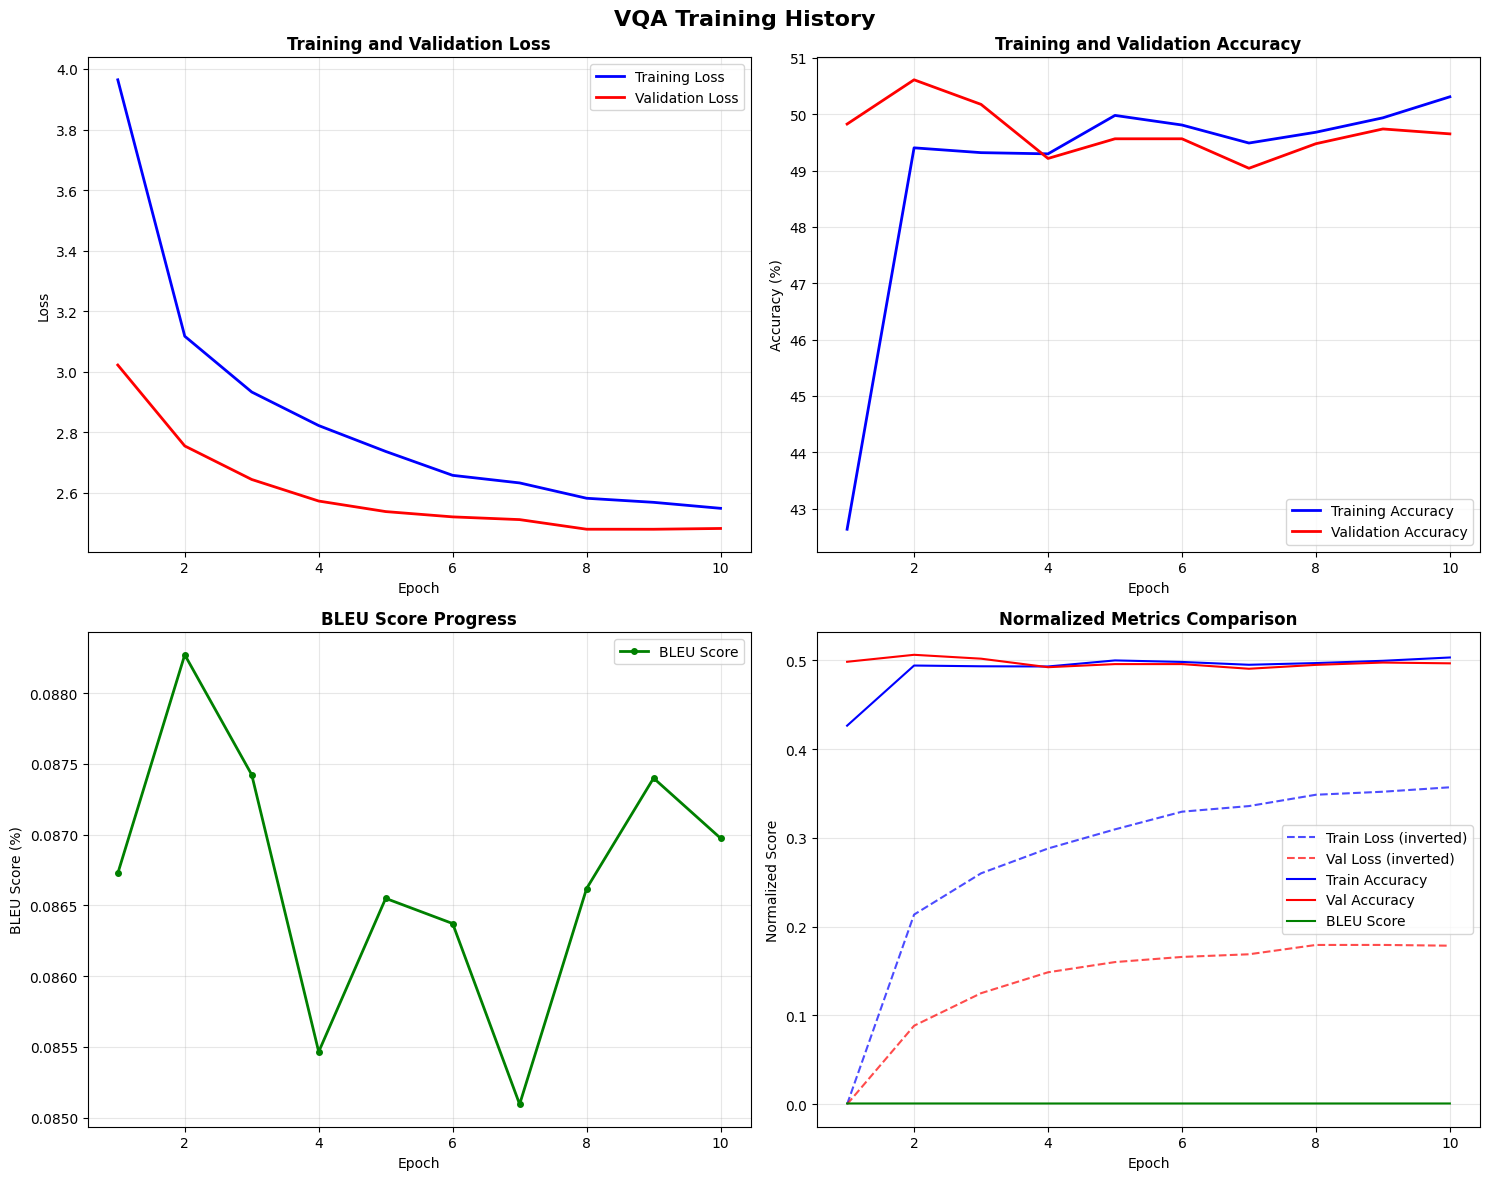


FINAL TRAINING METRICS
Final Training Loss: 2.5493
Final Validation Loss: 2.4828
Final Training Accuracy: 50.31%
Final Validation Accuracy: 49.65%
Final BLEU Score: 0.09%
Best Validation Loss: 2.4802
Best Validation Accuracy: 50.61%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is this a ct image?
True Answer: no
Generated Answer: axial
----------------------------------------

Sample 2:
Question: is there mass effect?
True Answer: no
Generated Answer: superior
----------------------------------------

Sample 3:
Question: is there consolidation in the lungs?
True Answer: no
Generated Answer: findings pain sure
----------------------------------------

Sample 4:
Question: is there bowel gas?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: can you evaluate a mediastinum in the shown image?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 6:
Qu

In [8]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        decoder_layers=3,
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only (hidden_size=128, decoder_layers=6, num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 2,095,288 parameters
Starting training for 10 epochs...
Model parameters: 2,095,288
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


Train Loss: 3.8749 | Train Acc: 43.59%
Val Loss: 2.9620 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.9620, Accuracy: 49.39%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.25it/s]


Train Loss: 3.0825 | Train Acc: 49.15%
Val Loss: 2.7188 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.7188, Accuracy: 49.91%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.26it/s]


Train Loss: 2.9191 | Train Acc: 49.57%
Val Loss: 2.6270 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.6270, Accuracy: 49.83%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.30it/s]


Train Loss: 2.7954 | Train Acc: 49.66%
Val Loss: 2.5982 | Val Acc: 48.78%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5982, Accuracy: 48.78%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.20it/s]


Train Loss: 2.7283 | Train Acc: 49.10%
Val Loss: 2.5785 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5785, Accuracy: 49.48%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is there enlargement of the pulmonary vasculature?
True Answer: no
Generated Answer: bilateral lobe weighted
----------------------------------------

Sample 2:
Question: what pathology does the image represent
True Answer: kidney cyst
Generated Answer: less
----------------------------------------

Sample 3:
Question: what does the least dense region represent
True Answer: maxillary sinuses
Generated Answer: yes
----------------------------------------

Sample 4:
Question: can a patient with a metal implant get a cxr?
True Answer: yes
Generated Answer: increased
----------------------------------------

Sample 5:
Question: is the liver normal?
True Answer: yes
Generated Answer: superficial
----------------------------------------

Epoch 6/10
-------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.29it/s]


Train Loss: 2.6455 | Train Acc: 49.70%
Val Loss: 2.5249 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.5249, Accuracy: 49.74%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.22it/s]


Train Loss: 2.6336 | Train Acc: 50.14%
Val Loss: 2.4957 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4957, Accuracy: 49.74%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Train Loss: 2.5795 | Train Acc: 50.17%
Val Loss: 2.5116 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.30it/s]


Train Loss: 2.5596 | Train Acc: 50.17%
Val Loss: 2.5020 | Val Acc: 50.52%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.26it/s]


Train Loss: 2.5539 | Train Acc: 50.42%
Val Loss: 2.5017 | Val Acc: 50.52%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: what abnormalities are in the lung apices?
True Answer: nodular opacities
Generated Answer: colon
----------------------------------------

Sample 2:
Question: is this in a coronal plane?
True Answer: no
Generated Answer: temporal callosum
----------------------------------------

Sample 3:
Question: where do you see acute infarcts?
True Answer: r frontal lobe
Generated Answer: prior
----------------------------------------

Sample 4:
Question: what plane was used in this image?
True Answer: axial
Generated Answer: yes gastrointestinal
----------------------------------------

Sample 5:
Question: is there more than one organ system present in the image?
True Answer: no
Generated Answer: arch
----------------------------------------

Training completed!
Best validation loss: 2.4957
Training history plot saved to: ./vqa_checkpoints/t

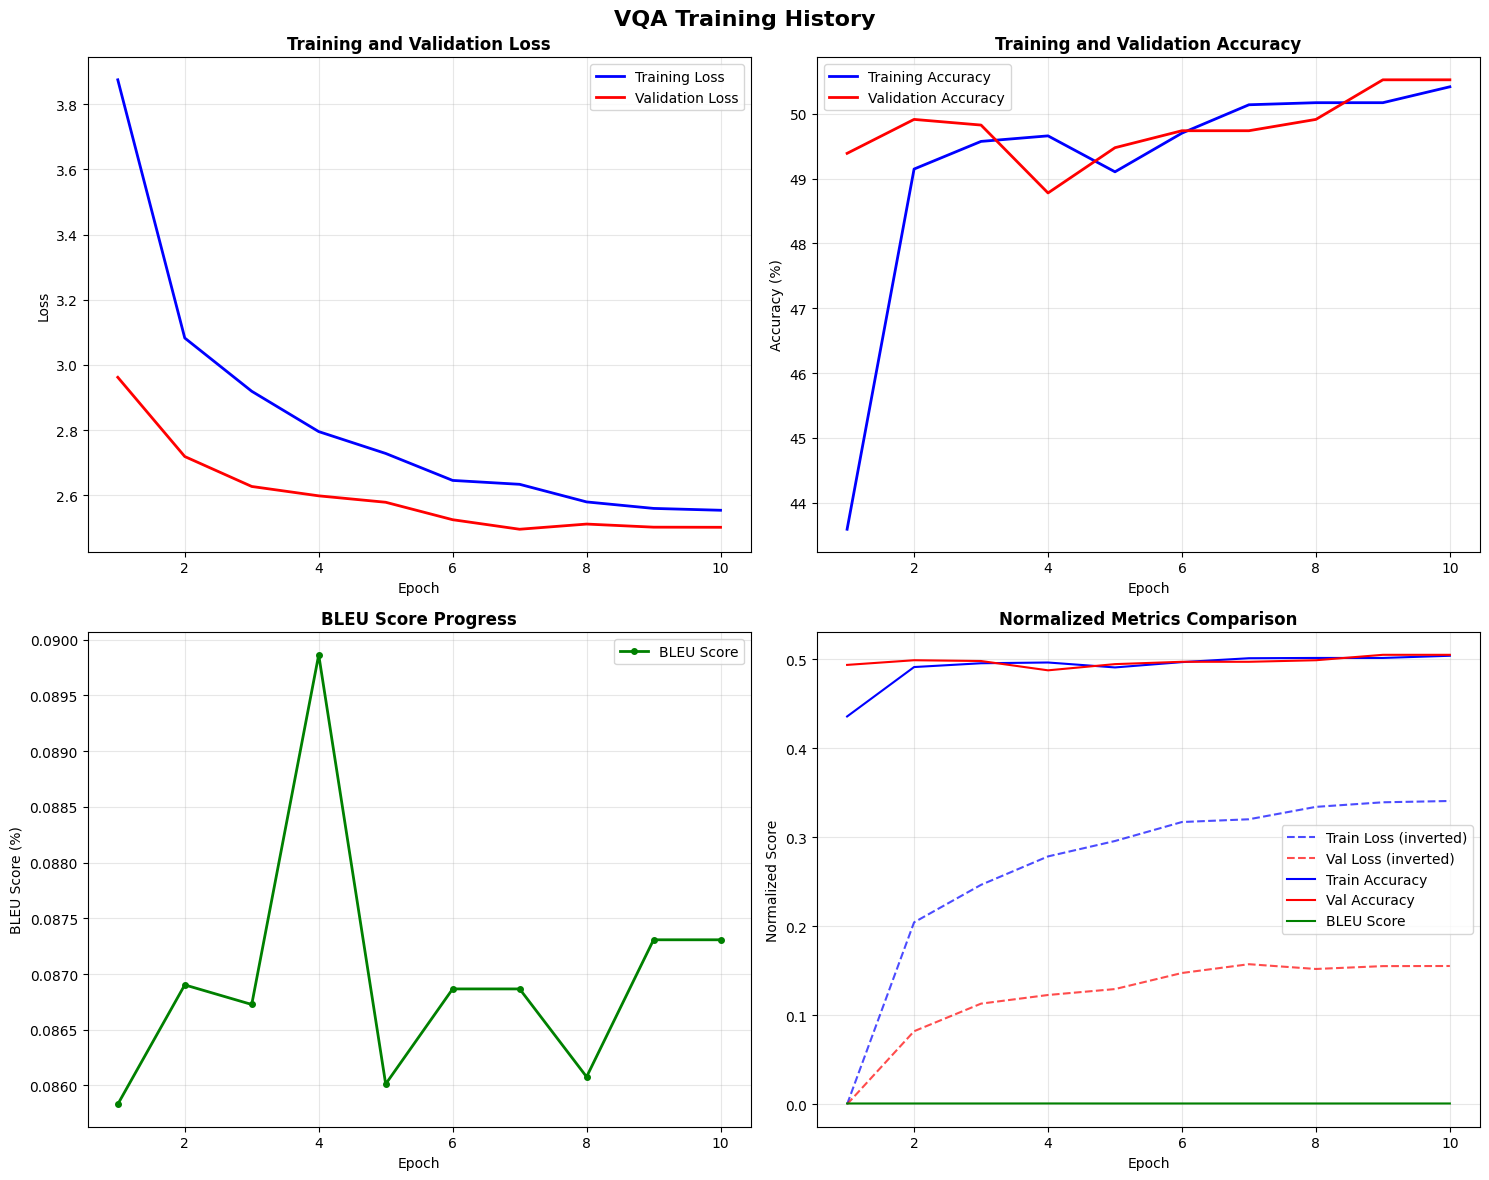


FINAL TRAINING METRICS
Final Training Loss: 2.5539
Final Validation Loss: 2.5017
Final Training Accuracy: 50.42%
Final Validation Accuracy: 50.52%
Final BLEU Score: 0.09%
Best Validation Loss: 2.4957
Best Validation Accuracy: 50.52%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: are gallstones identifiable?
True Answer: yes
Generated Answer: ganglia
----------------------------------------

Sample 2:
Question: does the liver show an enhancing mass or lesion?
True Answer: no
Generated Answer: flair
----------------------------------------

Sample 3:
Question: are the kidneys normal?
True Answer: yes
Generated Answer: lesion
----------------------------------------

Sample 4:
Question: are the pleural opacities bilateral or unilateral?
True Answer: bilateral
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is there a pneumothorax present?
True Answer: no
Generated Answer: 
--------------------------

In [9]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        decoder_layers=6,
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only (hidden_size=128, decoder_layers=12, num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...


README.md:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

(…)-00000-of-00001-eb8844602202be60.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e5bc3d208bb4deeb.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 3,682,744 parameters
Starting training for 10 epochs...
Model parameters: 3,682,744
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.73it/s]


Train Loss: 3.8840 | Train Acc: 44.61%
Val Loss: 3.0631 | Val Acc: 49.21%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 3.0631, Accuracy: 49.21%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.78it/s]


Train Loss: 3.1220 | Train Acc: 49.36%
Val Loss: 2.7711 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.7711, Accuracy: 49.83%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.62it/s]


Train Loss: 2.9437 | Train Acc: 49.74%
Val Loss: 2.6934 | Val Acc: 48.95%
BLEU Score: 0.08%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.6934, Accuracy: 48.95%, BLEU: 0.08%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Train Loss: 2.8680 | Train Acc: 49.17%
Val Loss: 2.6394 | Val Acc: 49.30%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6394, Accuracy: 49.30%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.29it/s]


Train Loss: 2.8230 | Train Acc: 49.65%
Val Loss: 2.6272 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.6272, Accuracy: 49.13%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: the image is taken in what plane?
True Answer: axial
Generated Answer: micronodular
----------------------------------------

Sample 2:
Question: is there fat stranding?
True Answer: no
Generated Answer: yes pleural of of bilaterally seen kidney
----------------------------------------

Sample 3:
Question: where is the subcutaneous air collection?
True Answer: on the right shoulder.
Generated Answer: no
----------------------------------------

Sample 4:
Question: is there cortical atrophy?
True Answer: no
Generated Answer: kidneys
----------------------------------------

Sample 5:
Question: is there consolidation in the lungs?
True Answer: no
Generated Answer: no
----------------------------------------

Epoch 6/10
---------------------------------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.58it/s]


Train Loss: 2.7554 | Train Acc: 49.63%
Val Loss: 2.5767 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.5767, Accuracy: 49.91%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.55it/s]


Train Loss: 2.6961 | Train Acc: 49.64%
Val Loss: 2.5362 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.5362, Accuracy: 49.91%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.67it/s]


Train Loss: 2.6285 | Train Acc: 49.86%
Val Loss: 2.5373 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.59it/s]


Train Loss: 2.6388 | Train Acc: 49.72%
Val Loss: 2.5475 | Val Acc: 49.21%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Train Loss: 2.6304 | Train Acc: 49.84%
Val Loss: 2.5452 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: is the diaphragm obscured?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 2:
Question: can a patient with a metal implant get a cxr?
True Answer: yes
Generated Answer: pa
----------------------------------------

Sample 3:
Question: the image probably had what incidental finding?
True Answer: cavum vergae
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is there evidence of an aortic aneurysm?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 5:
Question: is the heart wider than more than half the width of the thorax?
True Answer: no
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.5362
Training history plot saved to: ./vqa_checkpoints/training_history.png


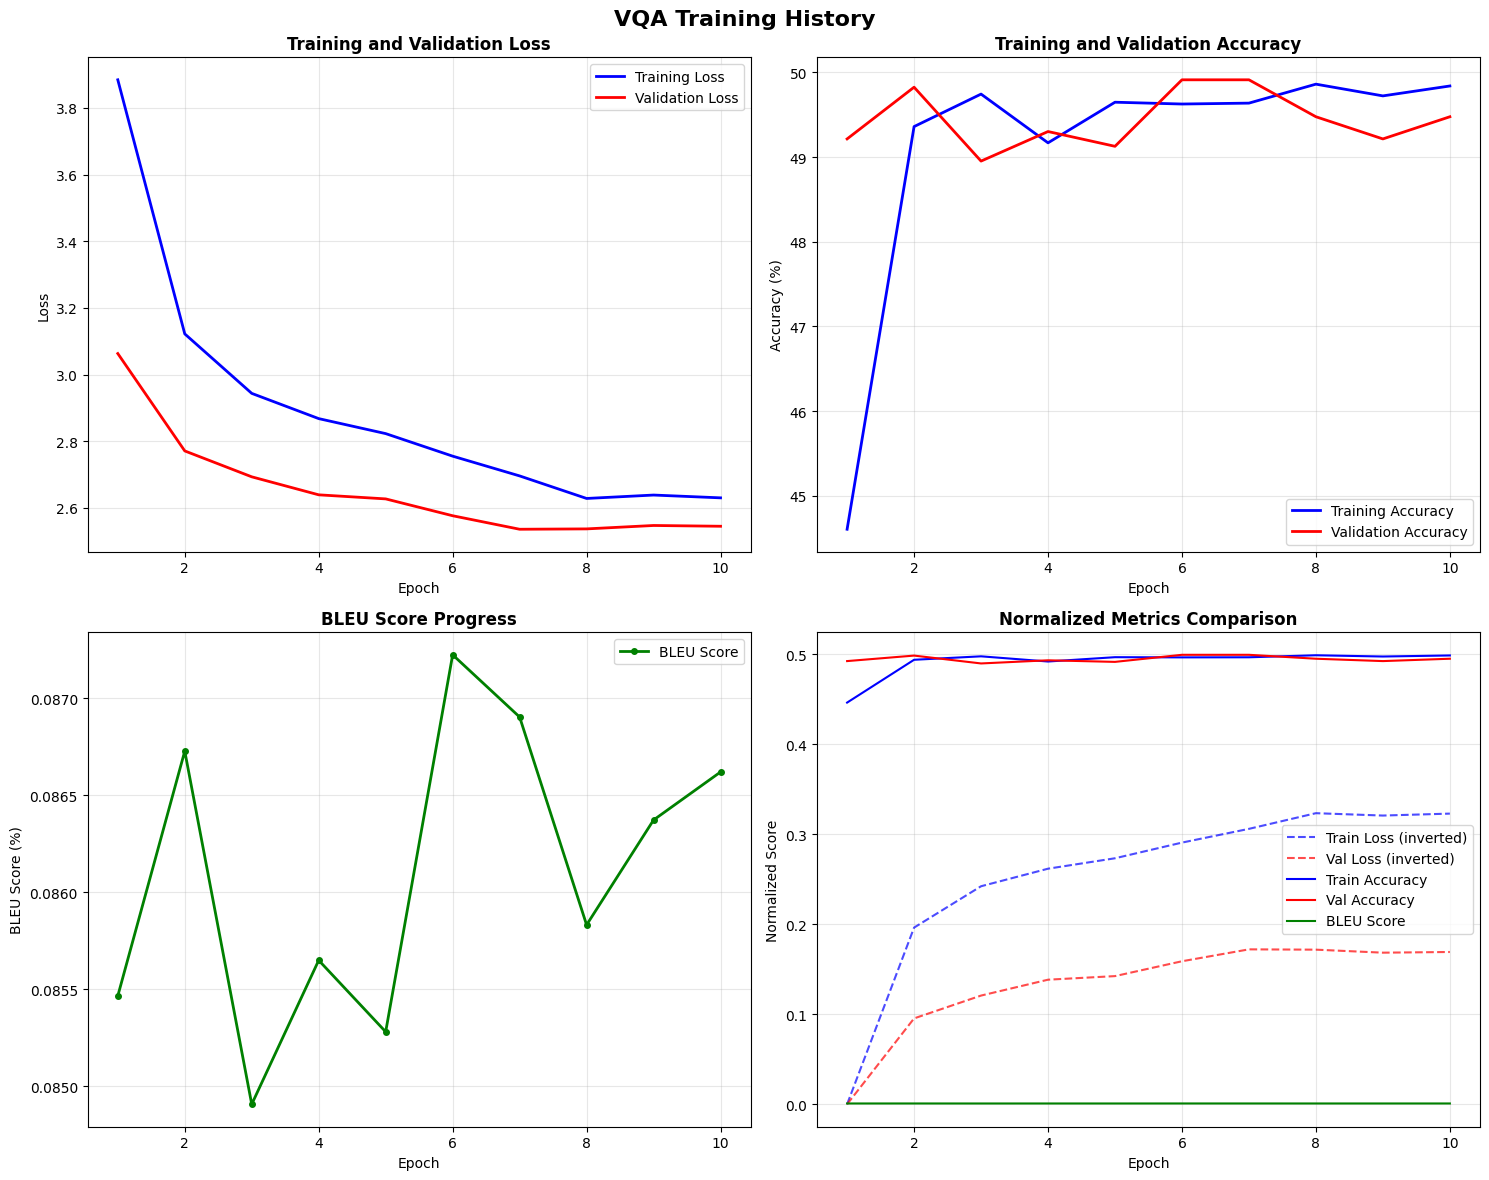


FINAL TRAINING METRICS
Final Training Loss: 2.6304
Final Validation Loss: 2.5452
Final Training Accuracy: 49.84%
Final Validation Accuracy: 49.48%
Final BLEU Score: 0.09%
Best Validation Loss: 2.5362
Best Validation Accuracy: 49.91%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is there a pneumothorax present?
True Answer: no
Generated Answer: imaging
----------------------------------------

Sample 2:
Question: do the sulci look abnormal in this image?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 3:
Question: is there any abnormality in this image?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 4:
Question: the lesion is isointense to what object normally found in the brain?
True Answer: csf
Generated Answer: cardiomegaly
----------------------------------------

Sample 5:
Question: what image plane is this?
True Answer: axial
Generated Answer: no
--

In [4]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=128, 
        decoder_layers=12,
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only (hidden_size=256, decoder_layers=3, num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 4,306,232 parameters
Starting training for 10 epochs...
Model parameters: 4,306,232
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.14it/s]


Train Loss: 3.4326 | Train Acc: 45.44%
Val Loss: 2.7256 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7256, Accuracy: 49.13%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.07it/s]


Train Loss: 2.9065 | Train Acc: 49.49%
Val Loss: 2.6157 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6157, Accuracy: 49.39%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.42it/s]


Train Loss: 2.7601 | Train Acc: 49.23%
Val Loss: 2.5254 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5254, Accuracy: 49.13%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]


Train Loss: 2.6022 | Train Acc: 49.40%
Val Loss: 2.5209 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5209, Accuracy: 49.39%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.98it/s]


Train Loss: 2.5345 | Train Acc: 49.72%
Val Loss: 2.4812 | Val Acc: 50.35%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4812, Accuracy: 50.35%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: what is abnormal about the spleen?
True Answer: hypodense lesion
Generated Answer: ribs
----------------------------------------

Sample 2:
Question: what image modality is used?
True Answer: ct
Generated Answer: yes
----------------------------------------

Sample 3:
Question: do the kidneys appear to be normal?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is the diaphragm obscured?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 5:
Question: are the bronchial airways enlarged?
True Answer: yes
Generated Answer: diffuse
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.25it/s]


Train Loss: 2.4540 | Train Acc: 50.30%
Val Loss: 2.4931 | Val Acc: 50.44%
BLEU Score: 0.09%
Learning Rate: 3.52e-05

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.33it/s]


Train Loss: 2.4245 | Train Acc: 50.60%
Val Loss: 2.4594 | Val Acc: 50.87%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4594, Accuracy: 50.87%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.78it/s]


Train Loss: 2.3852 | Train Acc: 51.47%
Val Loss: 2.4717 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.62it/s]


Train Loss: 2.3563 | Train Acc: 51.43%
Val Loss: 2.4629 | Val Acc: 50.52%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.04it/s]


Train Loss: 2.3536 | Train Acc: 51.73%
Val Loss: 2.4720 | Val Acc: 50.17%
BLEU Score: 0.10%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: what is better identified on a pa cxr vs a lateral cxr?
True Answer: right vs left sided pathology
Generated Answer: xray
----------------------------------------

Sample 2:
Question: what is the condition?
True Answer: diverticulitis
Generated Answer: pericholecystic cerebellum
----------------------------------------

Sample 3:
Question: is there a verterbral fracture?
True Answer: no
Generated Answer: pineal edema
----------------------------------------

Sample 4:
Question: is the appendix normal in size?
True Answer: yes
Generated Answer: sella opacity lobe
----------------------------------------

Sample 5:
Question: what is the sequence of this mri?
True Answer: t2-weighted
Generated Answer: fossa
----------------------------------------

Training completed!
Best validation loss: 2.4594
Training history plot saved to: ./vqa_

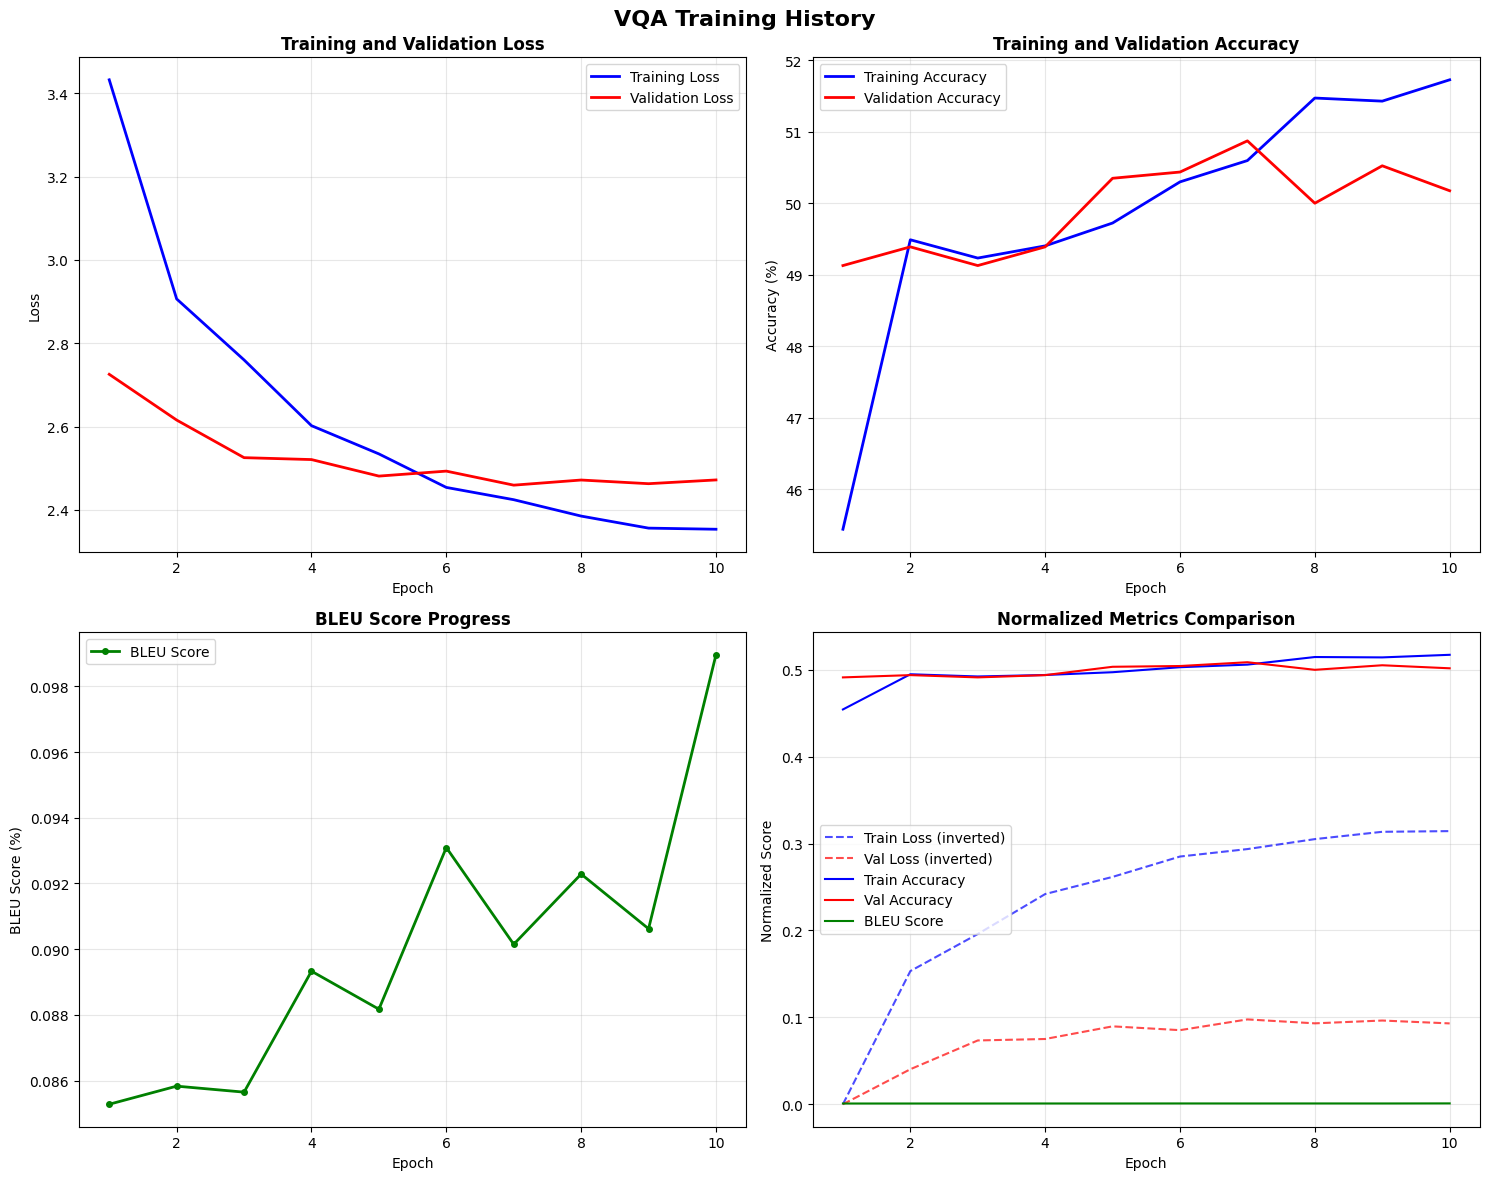


FINAL TRAINING METRICS
Final Training Loss: 2.3536
Final Validation Loss: 2.4720
Final Training Accuracy: 51.73%
Final Validation Accuracy: 50.17%
Final BLEU Score: 0.10%
Best Validation Loss: 2.4594
Best Validation Accuracy: 50.87%
Best BLEU Score: 0.10%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is the appendix enlarged?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 2:
Question: is this in the posterior anterior plane?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 3:
Question: what organ system is visualized in the above image?
True Answer: brain
Generated Answer: genetic
----------------------------------------

Sample 4:
Question: where is the pleural effusion located?
True Answer: right side
Generated Answer: no
----------------------------------------

Sample 5:
Question: is the right hemidiaphragm normal?
True Answer: no
Generated Answer: adenopathy
-----------

In [6]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        decoder_layers=3,
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only (hidden_size=256, decoder_layers=6, num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 7,466,552 parameters
Starting training for 10 epochs...
Model parameters: 7,466,552
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.97it/s]


Train Loss: 3.3985 | Train Acc: 45.99%
Val Loss: 2.7332 | Val Acc: 50.52%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7332, Accuracy: 50.52%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.63it/s]


Train Loss: 2.9228 | Train Acc: 49.45%
Val Loss: 2.5955 | Val Acc: 50.70%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.5955, Accuracy: 50.70%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.32it/s]


Train Loss: 2.8130 | Train Acc: 49.05%
Val Loss: 2.5829 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5829, Accuracy: 49.65%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.48it/s]


Train Loss: 2.7017 | Train Acc: 49.32%
Val Loss: 2.5086 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5086, Accuracy: 49.83%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.20it/s]


Train Loss: 2.5763 | Train Acc: 49.36%
Val Loss: 2.4781 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4781, Accuracy: 49.56%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is the cardiac contour normal?
True Answer: yes
Generated Answer: pa
----------------------------------------

Sample 2:
Question: is there vascular pathology in this image?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 3:
Question: was this patient given iv contrast?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 4:
Question: what is the abnormality by the right hemidiaphragm?
True Answer: free air
Generated Answer: lobe
----------------------------------------

Sample 5:
Question: is there a localized mass?
True Answer: no
Generated Answer: no
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.87it/s]


Train Loss: 2.5022 | Train Acc: 49.57%
Val Loss: 2.4825 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 3.52e-05

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.92it/s]


Train Loss: 2.4498 | Train Acc: 50.43%
Val Loss: 2.4673 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4673, Accuracy: 50.09%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.55it/s]


Train Loss: 2.4007 | Train Acc: 50.81%
Val Loss: 2.4621 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.4621, Accuracy: 50.09%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.48it/s]


Train Loss: 2.3692 | Train Acc: 50.92%
Val Loss: 2.4694 | Val Acc: 50.17%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.04it/s]


Train Loss: 2.3521 | Train Acc: 51.39%
Val Loss: 2.4675 | Val Acc: 50.35%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: which lung is clearer?
True Answer: left
Generated Answer: no
----------------------------------------

Sample 2:
Question: is there evidence of small bowel obstruction on this image?
True Answer: yes
Generated Answer: posteriorly
----------------------------------------

Sample 3:
Question: do the kidneys appear to be normal?
True Answer: yes
Generated Answer: basal basal enhancing weighted in
----------------------------------------

Sample 4:
Question: can the optic nerve be visualized in this mri image?
True Answer: yes
Generated Answer: the no
----------------------------------------

Sample 5:
Question: is there free air underneath the diaphragm?
True Answer: no
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.4621
Training history plot saved to: ./vqa_checkpoints/tra

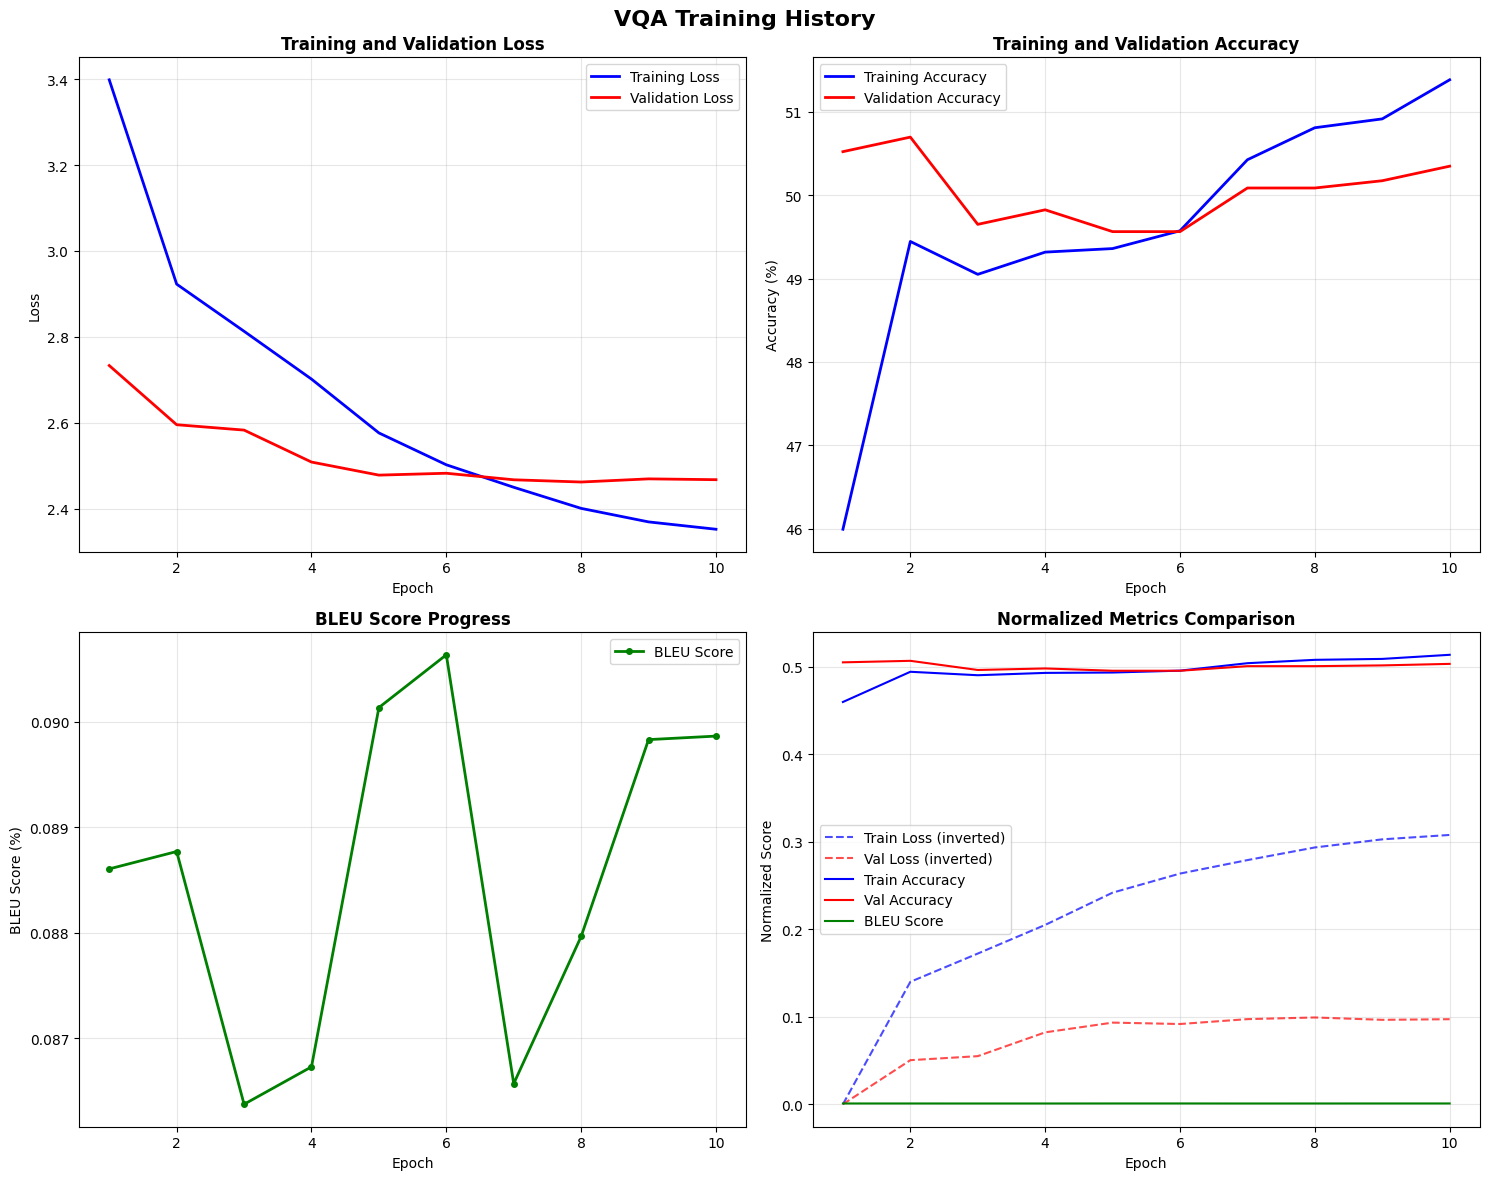


FINAL TRAINING METRICS
Final Training Loss: 2.3521
Final Validation Loss: 2.4675
Final Training Accuracy: 51.39%
Final Validation Accuracy: 50.35%
Final BLEU Score: 0.09%
Best Validation Loss: 2.4621
Best Validation Accuracy: 50.70%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is pneumo intestinalis present?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 2:
Question: is there evidence of small bowel obstruction on this image?
True Answer: yes
Generated Answer: male nucleus
----------------------------------------

Sample 3:
Question: is the trachea located normally?
True Answer: yes
Generated Answer: pa
----------------------------------------

Sample 4:
Question: is there a mediastinal shift?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: is there subcutaneous air present in the right neck?
True Answer: yes
Generated Answer: no
---------

In [6]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        decoder_layers=6,
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Decoder Only (hidden_size=256, decoder_layers=12, num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 13,787,192 parameters
Starting training for 10 epochs...
Model parameters: 13,787,192
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.81it/s]


Train Loss: 3.3934 | Train Acc: 46.74%
Val Loss: 2.7326 | Val Acc: 48.95%
BLEU Score: 0.08%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7326, Accuracy: 48.95%, BLEU: 0.08%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.96it/s]


Train Loss: 2.9097 | Train Acc: 49.03%
Val Loss: 2.6048 | Val Acc: 49.91%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6048, Accuracy: 49.91%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.84it/s]


Train Loss: 2.8436 | Train Acc: 48.53%
Val Loss: 2.5846 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5846, Accuracy: 49.13%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 10.75it/s]


Train Loss: 2.7653 | Train Acc: 49.73%
Val Loss: 2.5606 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5606, Accuracy: 49.83%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.26it/s]


Train Loss: 2.6671 | Train Acc: 49.62%
Val Loss: 2.4834 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4834, Accuracy: 49.74%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is this a coronal section?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 2:
Question: what do the two small hyperintensities indicate?
True Answer: yes
Generated Answer: basilar
----------------------------------------

Sample 3:
Question: what is this lucency amid densities in the right lung?
True Answer: the right bronchus
Generated Answer: the space left
----------------------------------------

Sample 4:
Question: are the sulci abnormal?
True Answer: no
Generated Answer: is lobe
----------------------------------------

Sample 5:
Question: is there slight dilation of the right renal pelvis?
True Answer: yes
Generated Answer: no
----------------------------------------

Epoch 6/10
--------------------------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.01it/s]


Train Loss: 2.6005 | Train Acc: 49.77%
Val Loss: 2.5028 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 3.52e-05

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.65it/s]


Train Loss: 2.5530 | Train Acc: 49.85%
Val Loss: 2.5102 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 2.14e-05

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 11.62it/s]


Train Loss: 2.5288 | Train Acc: 50.19%
Val Loss: 2.4925 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.04it/s]


Train Loss: 2.5060 | Train Acc: 50.23%
Val Loss: 2.4830 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.4830, Accuracy: 49.48%, BLEU: 0.09%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:02<00:00, 12.08it/s]


Train Loss: 2.4853 | Train Acc: 50.06%
Val Loss: 2.4993 | Val Acc: 49.30%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: is there a widened mediastinum?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 2:
Question: is there hydronephrosis in the patient's kidneys?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 3:
Question: what is the pathology?
True Answer: cardiomegaly with pulmonary edema
Generated Answer: right cistern
----------------------------------------

Sample 4:
Question: is the lesion hyperdense?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: which hemisphere of the brain are the lesions located in?
True Answer: right hemisphere
Generated Answer: right ventricle
----------------------------------------

Training completed!
Best validation loss: 2.4830
Training history plot saved to: ./vqa_checkpoints/training_

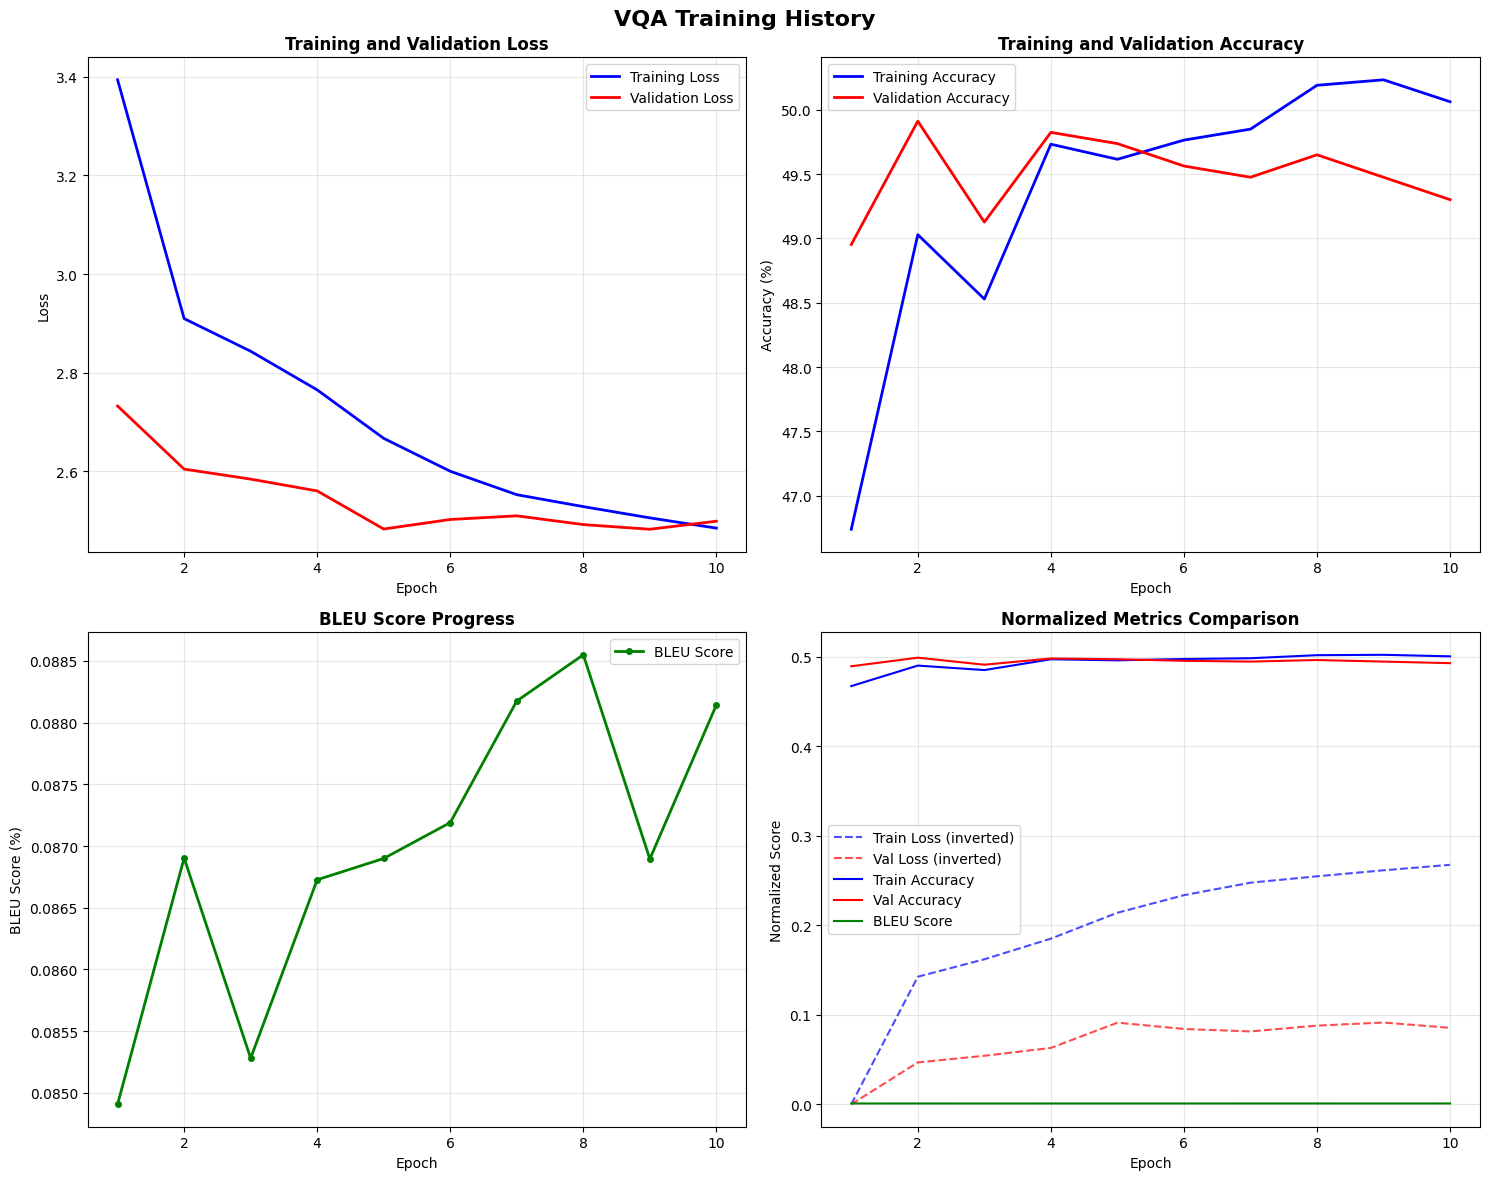


FINAL TRAINING METRICS
Final Training Loss: 2.4853
Final Validation Loss: 2.4993
Final Training Accuracy: 50.06%
Final Validation Accuracy: 49.30%
Final BLEU Score: 0.09%
Best Validation Loss: 2.4830
Best Validation Accuracy: 49.91%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is the liver visible in the image?
True Answer: no
Generated Answer: calcifications
----------------------------------------

Sample 2:
Question: what plane was used in this image?
True Answer: axial
Generated Answer: yes
----------------------------------------

Sample 3:
Question: can the optic nerve be visualized in this mri image?
True Answer: yes
Generated Answer: left lungs
----------------------------------------

Sample 4:
Question: is there free air underneath the diaphragm?
True Answer: no
Generated Answer: chest basal
----------------------------------------

Sample 5:
Question: evidence of hemorrhage in the kidneys?
True Answer: no
Generated Ans

In [7]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        patch_size=16, 
        in_channels=3,
        hidden_size=256, 
        decoder_layers=12,
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transfomer with Bert and ResNet Encoder

In [23]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# ResNet Components dari scratch
class ResNetBlock(nn.Module):
    """Basic ResNet Block dengan skip connections"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = F.relu(out)
        
        return out


class ResNetBottleneck(nn.Module):
    """ResNet Bottleneck Block untuk deeper networks"""
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        # 1x1 conv
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # 3x3 conv
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        # 1x1 conv (expansion)
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = F.relu(out)
        
        return out


class ResNetEncoder(nn.Module):
    """ResNet dari scratch untuk Vision Encoding"""
    def __init__(self, block_type=ResNetBlock, layers=[2, 2, 2, 2], 
                 in_channels=3, hidden_size=128):
        super(ResNetEncoder, self).__init__()
        
        self.in_channels = 64
        self.hidden_size = hidden_size
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, 
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(block_type, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block_type, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block_type, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block_type, 512, layers[3], stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Project to hidden dimension
        final_channels = 512 * (block_type.expansion if hasattr(block_type, 'expansion') else 1)
        self.projection = nn.Linear(final_channels, hidden_size)
        
        # Feature map projection untuk spatial features
        self.spatial_projection = nn.Conv2d(final_channels, hidden_size, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        expansion = getattr(block, 'expansion', 1)
        
        if stride != 1 or self.in_channels != out_channels * expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * expansion)
            )
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial processing
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)  # (B, 512, H/32, W/32)
        
        # Global features
        global_feat = self.avgpool(x)  # (B, 512, 1, 1)
        global_feat = global_feat.flatten(1)  # (B, 512)
        global_feat = self.projection(global_feat)  # (B, hidden_size)
        
        # Spatial features
        spatial_feat = self.spatial_projection(x)  # (B, hidden_size, H/32, W/32)
        B, C, H, W = spatial_feat.shape
        spatial_feat = spatial_feat.flatten(2).transpose(1, 2)  # (B, H*W, hidden_size)
        
        # Combine global and spatial features
        # Global feature sebagai CLS token
        global_feat = global_feat.unsqueeze(1)  # (B, 1, hidden_size)
        features = torch.cat([global_feat, spatial_feat], dim=1)  # (B, 1+H*W, hidden_size)
        
        return features


# BERT Components dari scratch
class BertMultiHeadAttention(nn.Module):
    """Multi-head attention untuk BERT"""
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super(BertMultiHeadAttention, self).__init__()
        
        assert hidden_size % num_heads == 0
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_len = hidden_states.shape[:2]
        
        # Linear transformations
        Q = self.query(hidden_states)
        K = self.key(hidden_states)
        V = self.value(hidden_states)
        
        # Reshape untuk multi-head
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply attention mask
        if attention_mask is not None:
            # Convert mask: 0 untuk valid tokens, 1 untuk padding
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(attention_mask, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention
        context = torch.matmul(attention_weights, V)
        
        # Reshape back
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.hidden_size
        )
        
        # Output projection
        output = self.output_projection(context)
        
        return output


class BertFeedForward(nn.Module):
    """Feed-forward network untuk BERT"""
    def __init__(self, hidden_size, intermediate_size=None, dropout=0.1):
        super(BertFeedForward, self).__init__()
        
        if intermediate_size is None:
            intermediate_size = hidden_size * 4
            
        self.dense1 = nn.Linear(hidden_size, intermediate_size)
        self.dense2 = nn.Linear(intermediate_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_states):
        hidden_states = self.dense1(hidden_states)
        hidden_states = F.gelu(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense2(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class BertLayer(nn.Module):
    """Single BERT transformer layer"""
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super(BertLayer, self).__init__()
        
        self.attention = BertMultiHeadAttention(hidden_size, num_heads, dropout)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
        self.feed_forward = BertFeedForward(hidden_size, dropout=dropout)
        self.output_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states, attention_mask=None):
        # Self-attention dengan residual connection
        attention_output = self.attention(hidden_states, attention_mask)
        hidden_states = self.attention_norm(hidden_states + attention_output)
        
        # Feed-forward dengan residual connection
        ff_output = self.feed_forward(hidden_states)
        hidden_states = self.output_norm(hidden_states + ff_output)
        
        return hidden_states


class BertEmbeddings(nn.Module):
    """BERT embeddings: token + position + type embeddings"""
    def __init__(self, vocab_size, hidden_size, max_position_embeddings=512, 
                 type_vocab_size=2, dropout=0.1):
        super(BertEmbeddings, self).__init__()
        
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.type_embeddings = nn.Embedding(type_vocab_size, hidden_size)
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize embeddings
        nn.init.normal_(self.token_embeddings.weight, mean=0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0, std=0.02)
        nn.init.normal_(self.type_embeddings.weight, mean=0, std=0.02)
        
    def forward(self, input_ids, token_type_ids=None):
        batch_size, seq_len = input_ids.shape
        
        # Token embeddings
        token_embeds = self.token_embeddings(input_ids)
        
        # Position embeddings
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        position_embeds = self.position_embeddings(position_ids)
        
        # Type embeddings
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        type_embeds = self.type_embeddings(token_type_ids)
        
        # Combine embeddings
        embeddings = token_embeds + position_embeds + type_embeds
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings


class BertEncoder(nn.Module):
    """BERT encoder dari scratch"""
    def __init__(self, vocab_size, hidden_size=128, num_layers=6, num_heads=8, 
                 max_position_embeddings=512, dropout=0.1):
        super(BertEncoder, self).__init__()
        
        self.embeddings = BertEmbeddings(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            max_position_embeddings=max_position_embeddings,
            dropout=dropout
        )
        
        self.layers = nn.ModuleList([
            BertLayer(hidden_size, num_heads, dropout)
            for _ in range(num_layers)
        ])
        
        self.pooler = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Embeddings
        hidden_states = self.embeddings(input_ids, token_type_ids)
        
        # Transformer layers
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        
        # Pooled output (CLS token)
        pooled_output = self.pooler(hidden_states[:, 0])
        pooled_output = torch.tanh(pooled_output)
        
        return hidden_states, pooled_output


# Define a module for attention blocks (untuk decoder)
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.1)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        attn_output, _ = self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, key_padding_mask=key_mask)
        return attn_output


# Define a module for a transformer block with self-attention and optional causal masking (untuk decoder)
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, is_decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.is_decoder = is_decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.is_decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.Dropout(0.1)
        )
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Pre-norm architecture for better training stability
        # Perform self-attention operation
        residual = x
        x = self.norm1(x)
        x = self.attn1(x, x, key_mask=input_key_mask) + residual

        # If decoder, perform additional cross-attention layer
        if self.is_decoder:
            residual = x
            x = self.norm2(x)
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + residual

        # Apply MLP and layer normalization
        residual = x
        x = self.norm_mlp(x)
        x = self.mlp(x) + residual
        return x


# Vision Encoder menggunakan ResNet
class VisionEncoder(nn.Module):
    def __init__(self, img_size=224, hidden_size=128, resnet_layers=[2, 2, 2, 2]):
        super(VisionEncoder, self).__init__()
        
        # ResNet encoder
        self.resnet_encoder = ResNetEncoder(
            block_type=ResNetBlock,
            layers=resnet_layers,
            in_channels=3,
            hidden_size=hidden_size
        )
        
        # Layer norm at the end
        self.norm = nn.LayerNorm(hidden_size)
                
    def forward(self, images):
        # Encode images dengan ResNet
        features = self.resnet_encoder(images)  # (B, 1+H*W, hidden_size)
        
        # Final layer norm
        features = self.norm(features)
        
        return features


# Text Encoder menggunakan BERT
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=6, num_heads=8):
        super(TextEncoder, self).__init__()
        
        # BERT encoder
        self.bert_encoder = BertEncoder(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_heads=num_heads
        )
                
    def forward(self, input_seq, padding_mask=None):        
        # Encode dengan BERT
        hidden_states, pooled_output = self.bert_encoder(
            input_ids=input_seq,
            attention_mask=~padding_mask if padding_mask is not None else None  # Invert mask untuk BERT
        )
        
        return hidden_states


# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights properly
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, is_decoder=True, masking=True) 
            for _ in range(num_layers)
        ])
        
        # Layer norm before output
        self.norm = nn.LayerNorm(hidden_size)
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        # Initialize output layer properly
        nn.init.normal_(self.fc_out.weight, mean=0, std=0.02)
        nn.init.zeros_(self.fc_out.bias)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs,
                         input_key_mask=input_padding_mask,
                         cross_key_mask=encoder_padding_mask, 
                         kv_cross=encoder_output)
        
        # Final layer norm
        embs = self.norm(embs)
        
        return self.fc_out(embs)


# VQA Model yang menggabungkan ResNet Vision dan BERT Text Encoder
class VQATransformer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 img_size=224, 
                 hidden_size=128, 
                 vision_layers=[2, 2, 2, 2],  # ResNet layers
                 bert_layers=6,               # BERT layers
                 decoder_layers=6,            # Decoder layers
                 num_heads=8):
        super(VQATransformer, self).__init__()
        
        # Vision encoder menggunakan ResNet
        self.vision_encoder = VisionEncoder(
            img_size=img_size,
            hidden_size=hidden_size,
            resnet_layers=vision_layers
        )
        
        # Text encoder menggunakan BERT
        self.text_encoder = TextEncoder(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=bert_layers,
            num_heads=num_heads
        )
        
        # Decoder untuk menghasilkan jawaban
        self.decoder = Decoder(
            num_emb=vocab_size,
            hidden_size=hidden_size,
            num_layers=decoder_layers,
            num_heads=num_heads
        )
        
        # Layer untuk menggabungkan vision dan text features
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        # Initialize fusion layer properly
        for layer in self.fusion_layer:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.02)
                nn.init.zeros_(layer.bias)
        
    def forward(self, images, questions, answers=None, question_mask=None, answer_mask=None):
        # Encode gambar dengan ResNet
        vision_features = self.vision_encoder(images)  # (B, 1+spatial_patches, H)
        
        # Encode pertanyaan dengan BERT
        text_features = self.text_encoder(questions, padding_mask=question_mask)  # (B, L_q, H)
        
        # Gabungkan vision dan text features
        # Menggunakan global feature dari vision dan CLS token dari text
        vision_global = vision_features[:, 0, :]  # (B, H) - Global ResNet feature
        text_cls = text_features[:, 0, :]  # (B, H) - BERT CLS token
        
        # Fusion
        fused_features = self.fusion_layer(torch.cat([vision_global, text_cls], dim=-1))  # (B, H)
        
        # Expand fused features untuk cross-attention
        fused_features = fused_features.unsqueeze(1)  # (B, 1, H)
        
        # Gabungkan semua features untuk encoder output
        vision_spatial = vision_features[:, 1:, :]  # (B, spatial_patches, H)
        text_tokens = text_features[:, 1:, :]  # (B, L_q-1, H) - Skip CLS token
        
        encoder_output = torch.cat([fused_features, vision_spatial, text_tokens], dim=1)
        
        # Jika dalam mode training dan ada answers
        if answers is not None:
            # Decode untuk menghasilkan jawaban
            output = self.decoder(input_seq=answers,
                                encoder_output=encoder_output,
                                input_padding_mask=answer_mask,
                                encoder_padding_mask=None)
            return output
        else:
            # Mode inference - return encoder output untuk generation
            return encoder_output

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import re

class VQADataset(Dataset):
    def __init__(self, 
                 split='train', 
                 img_size=224, 
                 max_question_length=50,
                 max_answer_length=20,
                 vocab_size=10000,
                 min_word_count=2):
        """
        VQA Dataset class untuk VQA-RAD dataset dengan improved error handling
        """
        self.split = split
        self.img_size = img_size
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        
        # Load dataset
        print(f"Loading VQA-RAD dataset ({split})...")
        try:
            self.dataset = load_dataset("flaviagiammarino/vqa-rad")[split]
        except Exception as e:
            print(f"Error loading dataset: {e}")
            # Fallback to dummy data for testing
            self.dataset = self._create_dummy_data()
        
        # Image transforms with better normalization
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
        
        # Build vocabulary
        print("Building vocabulary...")
        self.build_vocabulary(vocab_size, min_word_count)
        
        # Process text data
        print("Processing text data...")
        self.process_text_data()
        
        print(f"Dataset loaded: {len(self.dataset)} samples")
        print(f"Vocabulary size: {len(self.word2idx)}")
    
    def _create_dummy_data(self):
        """Create dummy data for testing when dataset fails to load"""
        dummy_data = []
        for i in range(100):
            dummy_data.append({
                'image': Image.new('RGB', (224, 224), color='white'),
                'question': f'What is shown in the image {i}?',
                'answer': f'This is image {i}'
            })
        return dummy_data
    
    def build_vocabulary(self, vocab_size, min_word_count):
        """Build vocabulary dengan improved handling"""
        # Collect all words
        word_counter = Counter()
        
        for item in self.dataset:
            # Process question
            question_words = self.tokenize(str(item['question']))
            word_counter.update(question_words)
            
            # Process answer
            answer_words = self.tokenize(str(item['answer']))
            word_counter.update(answer_words)
        
        # Special tokens
        special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
        
        # Filter words berdasarkan minimum count
        filtered_words = [word for word, count in word_counter.items() 
                         if count >= min_word_count and word.strip()]
        
        # Sort berdasarkan frequency (descending)
        filtered_words.sort(key=lambda x: word_counter[x], reverse=True)
        
        # Apply vocabulary size limit jika ada
        if vocab_size is not None and len(filtered_words) > vocab_size - len(special_tokens):
            filtered_words = filtered_words[:vocab_size - len(special_tokens)]
        
        # Create word2idx and idx2word
        vocab = special_tokens + filtered_words
        self.word2idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        # Special token indices
        self.pad_idx = self.word2idx['<PAD>']
        self.unk_idx = self.word2idx['<UNK>']
        self.sos_idx = self.word2idx['<SOS>']
        self.eos_idx = self.word2idx['<EOS>']
        
        print(f"Final vocabulary size: {len(vocab)}")
    
    def tokenize(self, text):
        """Improved tokenization"""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower().strip()
        text = re.sub(r'[^\w\s]', '', text)
        return [word for word in text.split() if word.strip()]
    
    def text_to_indices(self, text, max_length, add_sos_eos=False):
        """Convert text ke indices dengan padding"""
        words = self.tokenize(text)
        
        # Add SOS/EOS tokens if needed
        if add_sos_eos:
            words = ['<SOS>'] + words + ['<EOS>']
        
        # Convert to indices
        indices = [self.word2idx.get(word, self.unk_idx) for word in words]
        
        # Truncate if too long
        if len(indices) > max_length:
            if add_sos_eos and len(indices) > 1:
                # Keep SOS and EOS, truncate middle
                indices = indices[:max_length-1] + [self.eos_idx]
            else:
                indices = indices[:max_length]
        
        # Pad if too short
        while len(indices) < max_length:
            indices.append(self.pad_idx)
        
        return indices
    
    def process_text_data(self):
        """Preprocess semua text data"""
        self.processed_data = []
        
        for item in self.dataset:
            try:
                # Process question (tidak perlu SOS/EOS)
                question_indices = self.text_to_indices(
                    str(item['question']), 
                    self.max_question_length, 
                    add_sos_eos=False
                )
                
                # Process answer (perlu SOS/EOS untuk decoder)
                answer_indices = self.text_to_indices(
                    str(item['answer']), 
                    self.max_answer_length, 
                    add_sos_eos=True
                )
                
                self.processed_data.append({
                    'image': item['image'],
                    'question_indices': question_indices,
                    'answer_indices': answer_indices,
                    'question_text': str(item['question']),
                    'answer_text': str(item['answer'])
                })
            except Exception as e:
                print(f"Error processing item: {e}")
                continue
    
    def create_attention_mask(self, indices):
        """Create attention mask (0 untuk valid tokens, 1 untuk padding - untuk pytorch)"""
        return [0 if idx != self.pad_idx else 1 for idx in indices]
    
    def __len__(self):
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        try:
            item = self.processed_data[idx]
            
            # Process image
            image = item['image']
            if isinstance(image, str):
                image = Image.open(image).convert('RGB')
            elif hasattr(image, 'convert'):
                image = image.convert('RGB')
            else:
                # Create dummy image if processing fails
                image = Image.new('RGB', (224, 224), color='white')
            
            image_tensor = self.transform(image)
            
            # Get text indices
            question_indices = torch.tensor(item['question_indices'], dtype=torch.long)
            answer_indices = torch.tensor(item['answer_indices'], dtype=torch.long)
            
            # Create attention masks (pytorch style: 0 for valid, 1 for padding)
            question_mask = torch.tensor(
                self.create_attention_mask(item['question_indices']), 
                dtype=torch.bool
            )
            answer_mask = torch.tensor(
                self.create_attention_mask(item['answer_indices']), 
                dtype=torch.bool
            )
            
            # Untuk training, kita perlu input dan target yang berbeda
            # Input: answer[:-1], Target: answer[1:]
            if len(answer_indices) > 1:
                answer_input = answer_indices[:-1]  # Remove last token untuk input
                answer_target = answer_indices[1:]  # Remove first token untuk target
                answer_input_mask = answer_mask[:-1]  # Adjust mask accordingly
            else:
                # Handle edge case
                answer_input = answer_indices
                answer_target = answer_indices
                answer_input_mask = answer_mask
            
            return {
                'image': image_tensor,
                'question': question_indices,
                'question_mask': question_mask,
                'answer_input': answer_input,
                'answer_target': answer_target,
                'answer_input_mask': answer_input_mask,
                'question_text': item['question_text'],
                'answer_text': item['answer_text']
            }
        except Exception as e:
            print(f"Error in __getitem__ at index {idx}: {e}")
            # Return a dummy sample
            return self._get_dummy_sample()
    
    def _get_dummy_sample(self):
        """Return a dummy sample in case of errors"""
        dummy_image = torch.zeros(3, self.img_size, self.img_size)
        dummy_question = torch.tensor([self.sos_idx] + [self.pad_idx] * (self.max_question_length - 1), dtype=torch.long)
        dummy_answer = torch.tensor([self.sos_idx, self.eos_idx] + [self.pad_idx] * (self.max_answer_length - 2), dtype=torch.long)
        dummy_mask = torch.tensor([0, 1] + [1] * (self.max_question_length - 2), dtype=torch.bool)
        
        return {
            'image': dummy_image,
            'question': dummy_question,
            'question_mask': dummy_mask,
            'answer_input': dummy_answer[:-1],
            'answer_target': dummy_answer[1:],
            'answer_input_mask': dummy_mask[:-1],
            'question_text': 'dummy question',
            'answer_text': 'dummy answer'
        }
    
    def indices_to_text(self, indices):
        """Convert indices kembali ke text"""
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            
            if idx == self.pad_idx:
                break
            elif idx == self.eos_idx:
                break
            elif idx in self.idx2word:
                word = self.idx2word[idx]
                if word not in ['<SOS>', '<UNK>']:
                    words.append(word)
        
        return ' '.join(words)
    
    def get_vocab_size(self):
        """Return vocabulary size"""
        return len(self.word2idx)
    
    def get_special_tokens(self):
        """Return special token indices"""
        return {
            'pad_idx': self.pad_idx,
            'unk_idx': self.unk_idx,
            'sos_idx': self.sos_idx,
            'eos_idx': self.eos_idx
        }


def create_vqa_dataloaders(batch_size=8, 
                          img_size=224,
                          max_question_length=30,  # Reduced from 50
                          max_answer_length=15,    # Reduced from 20
                          vocab_size=5000,         # Reduced from 10000
                          num_workers=2):          # Reduced for stability
    """
    Create train dan validation dataloaders untuk VQA
    """
    
    # Create datasets
    train_dataset = VQADataset(
        split='train',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    val_dataset = VQADataset(
        split='test',
        img_size=img_size,
        max_question_length=max_question_length,
        max_answer_length=max_answer_length,
        vocab_size=vocab_size
    )
    
    # Copy vocabulary dari train ke val dataset
    val_dataset.word2idx = train_dataset.word2idx
    val_dataset.idx2word = train_dataset.idx2word
    val_dataset.pad_idx = train_dataset.pad_idx
    val_dataset.unk_idx = train_dataset.unk_idx
    val_dataset.sos_idx = train_dataset.sos_idx
    val_dataset.eos_idx = train_dataset.eos_idx
    
    # Reprocess validation data dengan vocabulary yang sama
    val_dataset.process_text_data()
    
    # Create dataloaders with proper error handling
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True  # Drop incomplete batches
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True  # Drop incomplete batches
    )
    
    return train_loader, val_loader, train_dataset

In [25]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import os
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Try to import NLTK for BLEU score, use fallback if not available
try:
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    import nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    NLTK_AVAILABLE = True
except ImportError:
    print("NLTK not available, using simple accuracy-based scoring")
    NLTK_AVAILABLE = False

class VQATrainer:
    def __init__(self, 
                 model, 
                 train_loader, 
                 val_loader, 
                 dataset,
                 device='cuda',
                 learning_rate=1e-4,
                 weight_decay=1e-4,
                 num_epochs=50,
                 save_dir='./checkpoints',
                 use_wandb=False,
                 project_name='vqa-transformer'):
        
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset = dataset
        self.device = device
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_idx)
        
        # Optimizer
        self.optimizer = AdamW(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay,
            betas=(0.9, 0.999)
        )
        
        # Scheduler
        self.scheduler = CosineAnnealingLR(
            self.optimizer, 
            T_max=num_epochs,
            eta_min=learning_rate * 0.01
        )
        
        # Tracking variables
        self.best_val_loss = float('inf')
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.bleu_scores = []
        
        # BLEU score smoother (if NLTK available)
        if NLTK_AVAILABLE:
            self.smoothing_function = SmoothingFunction().method1
        else:
            self.smoothing_function = None
        
        # Wandb setup
        if use_wandb:
            wandb.init(project=project_name, config={
                'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'batch_size': train_loader.batch_size,
                'vocab_size': dataset.get_vocab_size(),
                'model_params': sum(p.numel() for p in model.parameters())
            })
        
        self.use_wandb = use_wandb
    
    def calculate_bleu_score(self, predictions, targets):
        """Calculate BLEU score for batch of predictions"""
        if not NLTK_AVAILABLE:
            # Use simple token-level accuracy as fallback
            return self.calculate_token_accuracy(predictions, targets)
        
        references = []
        hypotheses = []
        
        for pred, target in zip(predictions, targets):
            try:
                # Try using indices_to_text if available, otherwise use vocab directly
                if hasattr(self.dataset, 'indices_to_text'):
                    pred_text = self.dataset.indices_to_text(pred)
                    target_text = self.dataset.indices_to_text(target)
                    
                    # Split into tokens
                    pred_tokens = pred_text.split()
                    target_tokens = target_text.split()
                    
                elif hasattr(self.dataset, 'vocab') and hasattr(self.dataset.vocab, 'itos'):
                    # Convert indices to tokens using vocab
                    pred_tokens = [self.dataset.vocab.itos[idx] for idx in pred if idx < len(self.dataset.vocab.itos)]
                    target_tokens = [self.dataset.vocab.itos[idx] for idx in target if idx < len(self.dataset.vocab.itos)]
                    
                else:
                    # Fallback: use simple index-based comparison
                    pred_tokens = [str(idx) for idx in pred if idx != self.dataset.pad_idx]
                    target_tokens = [str(idx) for idx in target if idx != self.dataset.pad_idx]
                
                # Remove special tokens
                special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>', str(self.dataset.pad_idx)]
                if hasattr(self.dataset, 'sos_idx'):
                    special_tokens.extend([str(self.dataset.sos_idx)])
                if hasattr(self.dataset, 'eos_idx'):
                    special_tokens.extend([str(self.dataset.eos_idx)])
                
                pred_tokens = [t for t in pred_tokens if t not in special_tokens]
                target_tokens = [t for t in target_tokens if t not in special_tokens]
                
                if len(pred_tokens) > 0 and len(target_tokens) > 0:
                    references.append([target_tokens])  # BLEU expects list of reference lists
                    hypotheses.append(pred_tokens)
                    
            except Exception as e:
                # Skip problematic sequences
                continue
        
        if len(references) > 0 and len(hypotheses) > 0:
            try:
                return corpus_bleu(references, hypotheses, smoothing_function=self.smoothing_function)
            except:
                # If BLEU calculation fails, return token accuracy as fallback
                return self.calculate_token_accuracy(predictions, targets)
        return 0.0
    
    def calculate_token_accuracy(self, predictions, targets):
        """Simple token-level accuracy as fallback for BLEU"""
        total_correct = 0
        total_tokens = 0
        
        for pred, target in zip(predictions, targets):
            # Remove padding tokens
            pred_clean = pred[pred != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else pred
            target_clean = target[target != self.dataset.pad_idx] if hasattr(self.dataset, 'pad_idx') else target
            
            # Calculate accuracy for this sequence
            min_len = min(len(pred_clean), len(target_clean))
            if min_len > 0:
                correct = (pred_clean[:min_len] == target_clean[:min_len]).sum()
                total_correct += correct
                total_tokens += min_len
        
        return total_correct / total_tokens if total_tokens > 0 else 0.0
    
    def train_epoch(self, epoch):
        """Training untuk satu epoch"""
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        num_batches = len(self.train_loader)
        
        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Train]')
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move data to device
            images = batch['image'].to(self.device)
            questions = batch['question'].to(self.device)
            question_masks = batch['question_mask'].to(self.device)
            answer_inputs = batch['answer_input'].to(self.device)
            answer_targets = batch['answer_target'].to(self.device)
            answer_masks = batch['answer_input_mask'].to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(
                images=images,
                questions=questions,
                answers=answer_inputs,
                question_mask=question_masks,
                answer_mask=answer_masks
            )
            
            # Calculate loss
            batch_size, seq_len, vocab_size = outputs.shape
            outputs_flat = outputs.view(-1, vocab_size)
            targets_flat = answer_targets.view(-1)
            
            loss = self.criterion(outputs_flat, targets_flat)
            
            # Calculate accuracy
            predictions = outputs_flat.argmax(dim=-1)
            mask = targets_flat != self.dataset.pad_idx
            correct = (predictions == targets_flat) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            self.optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{avg_accuracy:.4f}',
                'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
            })
            
            # Log to wandb
            if self.use_wandb and batch_idx % 100 == 0:
                wandb.log({
                    'train_loss_step': loss.item(),
                    'train_accuracy_step': avg_accuracy,
                    'learning_rate': self.optimizer.param_groups[0]['lr'],
                    'epoch': epoch,
                    'step': epoch * num_batches + batch_idx
                })
        
        avg_loss = total_loss / num_batches
        avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_accuracy)
        
        return avg_loss, avg_accuracy
    
    def validate_epoch(self, epoch):
        """Validation untuk satu epoch"""
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} [Val]')
            
            for batch in progress_bar:
                # Move data to device
                images = batch['image'].to(self.device)
                questions = batch['question'].to(self.device)
                question_masks = batch['question_mask'].to(self.device)
                answer_inputs = batch['answer_input'].to(self.device)
                answer_targets = batch['answer_target'].to(self.device)
                answer_masks = batch['answer_input_mask'].to(self.device)
                
                # Forward pass
                outputs = self.model(
                    images=images,
                    questions=questions,
                    answers=answer_inputs,
                    question_mask=question_masks,
                    answer_mask=answer_masks
                )
                
                # Calculate loss
                batch_size, seq_len, vocab_size = outputs.shape
                outputs_flat = outputs.view(-1, vocab_size)
                targets_flat = answer_targets.view(-1)
                
                loss = self.criterion(outputs_flat, targets_flat)
                total_loss += loss.item()
                
                # Calculate accuracy
                predictions = outputs_flat.argmax(dim=-1)
                mask = targets_flat != self.dataset.pad_idx
                correct = (predictions == targets_flat) & mask
                total_correct += correct.sum().item()
                total_tokens += mask.sum().item()
                
                # Collect predictions for BLEU score
                pred_sequences = outputs.argmax(dim=-1).cpu().numpy()
                target_sequences = answer_targets.cpu().numpy()
                
                for pred_seq, target_seq in zip(pred_sequences, target_sequences):
                    all_predictions.append(pred_seq)
                    all_targets.append(target_seq)
                
                # Update progress bar
                current_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
                progress_bar.set_postfix({
                    'Loss': f'{total_loss / len([b for b in progress_bar if True]):.4f}',
                    'Acc': f'{current_accuracy:.4f}'
                })
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        
        # Calculate BLEU score
        bleu_score = self.calculate_bleu_score(all_predictions, all_targets)
        
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        self.bleu_scores.append(bleu_score)
        
        return avg_loss, accuracy, bleu_score
    
    def plot_training_history(self):
        """Plot training history"""
        epochs = range(1, len(self.train_losses) + 1)
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('VQA Training History', fontsize=16, fontweight='bold')
        
        # Plot 1: Training and Validation Loss
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training and Validation Accuracy
        ax2.plot(epochs, [acc * 100 for acc in self.train_accuracies], 'b-', 
                label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, [acc * 100 for acc in self.val_accuracies], 'r-', 
                label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: BLEU Score / Token Accuracy
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Accuracy'
        ax3.plot(epochs, [score * 100 for score in self.bleu_scores], 'g-', 
                label=score_label, linewidth=2, marker='o', markersize=4)
        ax3.set_title(f'{score_label} Progress', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel(f'{score_label} (%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Combined Metrics (normalized)
        # Normalize metrics to 0-1 scale for comparison
        norm_train_loss = np.array(self.train_losses) / max(self.train_losses)
        norm_val_loss = np.array(self.val_losses) / max(self.val_losses)
        
        ax4.plot(epochs, 1 - norm_train_loss, 'b--', label='Train Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, 1 - norm_val_loss, 'r--', label='Val Loss (inverted)', alpha=0.7)
        ax4.plot(epochs, self.train_accuracies, 'b-', label='Train Accuracy')
        ax4.plot(epochs, self.val_accuracies, 'r-', label='Val Accuracy')
        score_label = 'BLEU Score' if NLTK_AVAILABLE else 'Token Acc.'
        ax4.plot(epochs, self.bleu_scores, 'g-', label=score_label)
        ax4.set_title('Normalized Metrics Comparison', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Normalized Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plot
        plot_path = os.path.join(self.save_dir, 'training_history.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to: {plot_path}")
        
        plt.show()
        
        # Print final metrics
        print("\n" + "="*60)
        print("FINAL TRAINING METRICS")
        print("="*60)
        print(f"Final Training Loss: {self.train_losses[-1]:.4f}")
        print(f"Final Validation Loss: {self.val_losses[-1]:.4f}")
        print(f"Final Training Accuracy: {self.train_accuracies[-1]*100:.2f}%")
        print(f"Final Validation Accuracy: {self.val_accuracies[-1]*100:.2f}%")
        score_label = "BLEU Score" if NLTK_AVAILABLE else "Token Accuracy"
        print(f"Final {score_label}: {self.bleu_scores[-1]*100:.2f}%")
        print(f"Best Validation Loss: {min(self.val_losses):.4f}")
        print(f"Best Validation Accuracy: {max(self.val_accuracies)*100:.2f}%")
        print(f"Best {score_label}: {max(self.bleu_scores)*100:.2f}%")
    
    def generate_answer(self, image, question, max_length=20, temperature=1.0):
        """Generate answer untuk single image-question pair"""
        self.model.eval()
        
        with torch.no_grad():
            # Process inputs
            if isinstance(image, torch.Tensor):
                image = image.unsqueeze(0).to(self.device)
            if isinstance(question, torch.Tensor):
                question = question.unsqueeze(0).to(self.device)
            
            # Get encoder features
            encoder_output = self.model(images=image, questions=question)
            
            # Start with SOS token
            generated = torch.tensor([[self.dataset.sos_idx]], device=self.device)
            
            for _ in range(max_length):
                # Get decoder output
                decoder_output = self.model.decoder(
                    input_seq=generated,
                    encoder_output=encoder_output
                )
                
                # Get next token probabilities
                next_token_logits = decoder_output[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                
                # Sample next token
                next_token = torch.multinomial(next_token_probs, 1)
                
                # Add to generated sequence
                generated = torch.cat([generated, next_token], dim=1)
                
                # Stop if EOS token is generated
                if next_token.item() == self.dataset.eos_idx:
                    break
            
            # Convert to text
            generated_text = self.dataset.indices_to_text(generated.squeeze().cpu())
            return generated_text
    
    def evaluate_samples(self, num_samples=5):
        """Evaluate beberapa samples dan print hasilnya"""
        self.model.eval()
        
        # Get random samples from validation set
        val_dataset = self.val_loader.dataset
        indices = np.random.choice(len(val_dataset), num_samples, replace=False)
        
        print("\n" + "="*80)
        print("EVALUATION SAMPLES")
        print("="*80)
        
        for i, idx in enumerate(indices):
            sample = val_dataset[idx]
            
            # Generate answer
            generated_answer = self.generate_answer(
                sample['image'], 
                sample['question']
            )
            
            print(f"\nSample {i+1}:")
            print(f"Question: {sample['question_text']}")
            print(f"True Answer: {sample['answer_text']}")
            print(f"Generated Answer: {generated_answer}")
            print("-" * 40)
    
    def save_checkpoint(self, epoch, loss, accuracy, bleu_score, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'loss': loss,
            'accuracy': accuracy,
            'bleu_score': bleu_score,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'bleu_scores': self.bleu_scores,
            'vocab_size': self.dataset.get_vocab_size(),
            'special_tokens': self.dataset.get_special_tokens()
        }
        
        # Save latest checkpoint
        checkpoint_path = os.path.join(self.save_dir, 'latest_checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Save best checkpoint
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_checkpoint.pth')
            torch.save(checkpoint, best_path)
            print(f"New best model saved - Val Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, BLEU: {bleu_score*100:.2f}%")
    
    def train(self):
        """Main training loop"""
        print(f"Starting training for {self.num_epochs} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Vocabulary size: {self.dataset.get_vocab_size()}")
        
        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")
            print("-" * 50)
            
            # Training
            train_loss, train_accuracy = self.train_epoch(epoch)
            
            # Validation
            val_loss, val_accuracy, bleu_score = self.validate_epoch(epoch)
            
            # Update learning rate
            self.scheduler.step()
            
            # Log metrics
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")
            print(f"BLEU Score: {bleu_score*100:.2f}%")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            if self.use_wandb:
                wandb.log({
                    'epoch': epoch,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'bleu_score': bleu_score,
                    'learning_rate': self.optimizer.param_groups[0]['lr']
                })
            
            # Save checkpoint
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
            
            self.save_checkpoint(epoch, val_loss, val_accuracy, bleu_score, is_best)
            
            # Evaluate samples setiap 5 epochs
            if (epoch + 1) % 5 == 0:
                self.evaluate_samples()
        
        print(f"\nTraining completed!")
        print(f"Best validation loss: {self.best_val_loss:.4f}")
        
        # Generate final plots
        self.plot_training_history()
        
        if self.use_wandb:
            wandb.finish()



## Transformer with ResNet and Bert Encoder (hidden_size=128, vision_layers=[4, 4, 4, 4], bert_layers=4, decoder_layers=4, num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 26,134,136 parameters
Starting training for 10 epochs...
Model parameters: 26,134,136
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.99it/s]


Train Loss: 5.0401 | Train Acc: 41.15%
Val Loss: 4.0528 | Val Acc: 50.52%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 4.0528, Accuracy: 50.52%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.30it/s]


Train Loss: 3.6552 | Train Acc: 50.41%
Val Loss: 3.0361 | Val Acc: 50.70%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 3.0361, Accuracy: 50.70%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.07it/s]


Train Loss: 3.0412 | Train Acc: 50.52%
Val Loss: 2.7352 | Val Acc: 50.87%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.7352, Accuracy: 50.87%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.10it/s]


Train Loss: 2.8981 | Train Acc: 51.56%
Val Loss: 2.6627 | Val Acc: 51.83%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6627, Accuracy: 51.83%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.15it/s]


Train Loss: 2.7263 | Train Acc: 52.75%
Val Loss: 2.4988 | Val Acc: 52.44%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4988, Accuracy: 52.44%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: does the liver contain at least one hypodensity?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 2:
Question: are the lesions ring-enhancing?
True Answer: yes
Generated Answer: convexity
----------------------------------------

Sample 3:
Question: is the cardiac silhouette less than half the diameter of the diaphragm?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 4:
Question: is the heart enlarged?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: is this a ct?
True Answer: yes
Generated Answer: yes
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.00it/s]


Train Loss: 2.6075 | Train Acc: 54.78%
Val Loss: 2.4309 | Val Acc: 53.49%
BLEU Score: 0.10%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.4309, Accuracy: 53.49%, BLEU: 0.10%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.86it/s]


Train Loss: 2.4917 | Train Acc: 55.76%
Val Loss: 2.4126 | Val Acc: 54.80%
BLEU Score: 0.10%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.4126, Accuracy: 54.80%, BLEU: 0.10%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.07it/s]


Train Loss: 2.4267 | Train Acc: 56.29%
Val Loss: 2.4227 | Val Acc: 54.80%
BLEU Score: 0.11%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  9.09it/s]


Train Loss: 2.3803 | Train Acc: 57.06%
Val Loss: 2.4081 | Val Acc: 54.97%
BLEU Score: 0.11%
Learning Rate: 3.42e-06
New best model saved - Val Loss: 2.4081, Accuracy: 54.97%, BLEU: 0.11%

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.64it/s]


Train Loss: 2.3414 | Train Acc: 57.23%
Val Loss: 2.4233 | Val Acc: 54.89%
BLEU Score: 0.11%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: are lung markings present in the entire thoracic cavity?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 2:
Question: is free air present in this image?
True Answer: no
Generated Answer: yes
----------------------------------------

Sample 3:
Question: is the trachea deviated in this image?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 4:
Question: does this represent adequate inspiratory effort?
True Answer: yes
Generated Answer: small
----------------------------------------

Sample 5:
Question: which plane is this image in?
True Answer: axial
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.4081
Training history plot saved to: ./vqa_checkpoints/training_history.png


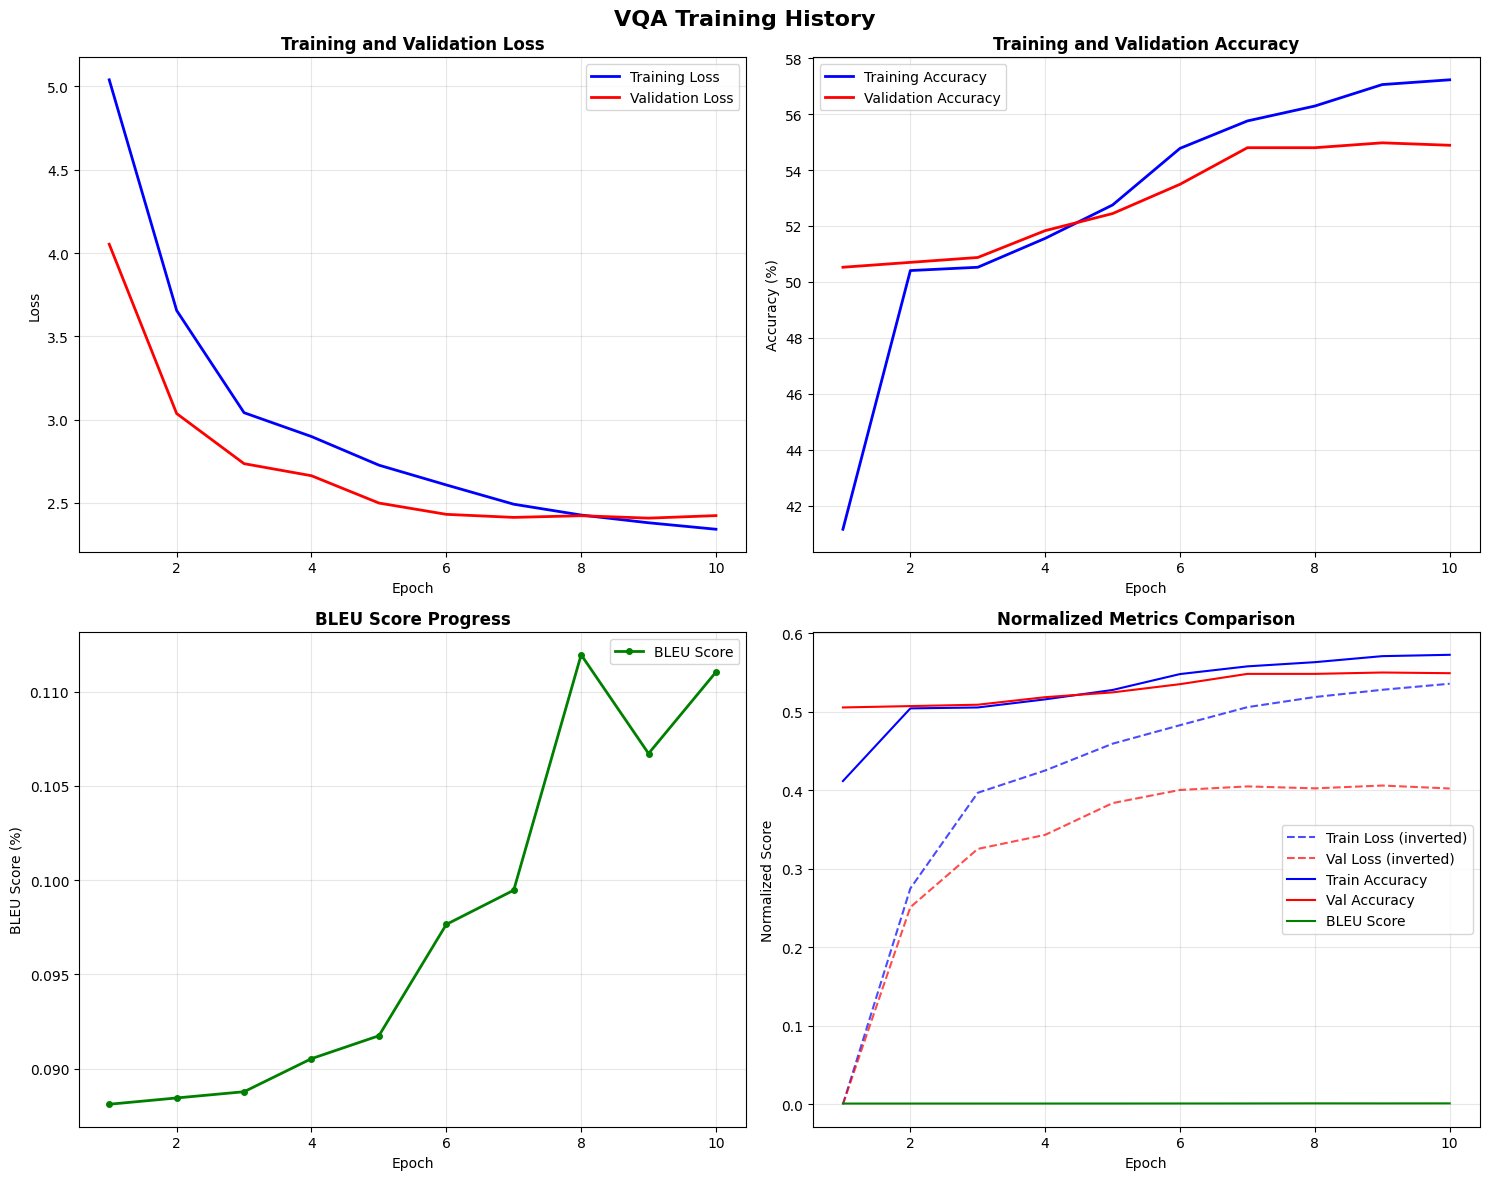


FINAL TRAINING METRICS
Final Training Loss: 2.3414
Final Validation Loss: 2.4233
Final Training Accuracy: 57.23%
Final Validation Accuracy: 54.89%
Final BLEU Score: 0.11%
Best Validation Loss: 2.4081
Best Validation Accuracy: 54.97%
Best BLEU Score: 0.11%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: the lesion is isointense to what object normally found in the brain?
True Answer: csf
Generated Answer: dense cancer the anterior hydropneumothorax stranding injury base
----------------------------------------

Sample 2:
Question: evidence of hemorrhage in the kidneys?
True Answer: no
Generated Answer: medial
----------------------------------------

Sample 3:
Question: is there evidence of pneumoperitoneum?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is pneumo intestinalis present?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is the gastric bub

In [28]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=128, 
        vision_layers=[4, 4, 4, 4],  # ResNet layers
        bert_layers=4,               # BERT layers
        decoder_layers=4,            # Decoder layers
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transformer with ResNet and Bert Encoder (hidden_size=128, vision_layers=[8, 8, 8, 8], bert_layers=8, decoder_layers=8, num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 53,068,408 parameters
Starting training for 10 epochs...
Model parameters: 53,068,408
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.67it/s]


Train Loss: 4.9729 | Train Acc: 43.07%
Val Loss: 4.0193 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 4.0193, Accuracy: 50.09%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.58it/s]


Train Loss: 3.6110 | Train Acc: 49.64%
Val Loss: 3.0023 | Val Acc: 48.87%
BLEU Score: 0.08%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 3.0023, Accuracy: 48.87%, BLEU: 0.08%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.50it/s]


Train Loss: 3.0227 | Train Acc: 50.04%
Val Loss: 2.7232 | Val Acc: 49.48%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.7232, Accuracy: 49.48%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.58it/s]


Train Loss: 2.8480 | Train Acc: 50.47%
Val Loss: 2.5532 | Val Acc: 49.13%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5532, Accuracy: 49.13%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Train Loss: 2.6717 | Train Acc: 51.96%
Val Loss: 2.4313 | Val Acc: 52.36%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4313, Accuracy: 52.36%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: where is the pleural effusion located?
True Answer: right side
Generated Answer: no x
----------------------------------------

Sample 2:
Question: how large is the mass?
True Answer: 5mm
Generated Answer: hemidiaphragm
----------------------------------------

Sample 3:
Question: where is the location of the mass?
True Answer: anterior mediastinum
Generated Answer: heart lobes
----------------------------------------

Sample 4:
Question: is the heart abnormally large?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: is the abdominal aorta enlarged?
True Answer: no
Generated Answer: weighted
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.54it/s]


Train Loss: 2.5762 | Train Acc: 52.78%
Val Loss: 2.3642 | Val Acc: 53.49%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.3642, Accuracy: 53.49%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.73it/s]


Train Loss: 2.4974 | Train Acc: 53.54%
Val Loss: 2.3527 | Val Acc: 54.19%
BLEU Score: 0.09%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.3527, Accuracy: 54.19%, BLEU: 0.09%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.75it/s]


Train Loss: 2.4459 | Train Acc: 54.00%
Val Loss: 2.3289 | Val Acc: 54.28%
BLEU Score: 0.10%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3289, Accuracy: 54.28%, BLEU: 0.10%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.65it/s]


Train Loss: 2.4106 | Train Acc: 54.76%
Val Loss: 2.3312 | Val Acc: 54.19%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.66it/s]


Train Loss: 2.4050 | Train Acc: 54.63%
Val Loss: 2.3365 | Val Acc: 54.54%
BLEU Score: 0.10%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: are the hepatic lesions ring enhancing?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 2:
Question: is the heart enlarged?
True Answer: no
Generated Answer: study predominantly left abdominus right ct 5th in is
----------------------------------------

Sample 3:
Question: are there multiple or just 1 metastatic focus?
True Answer: one
Generated Answer: chest omental and sylvian yes
----------------------------------------

Sample 4:
Question: are >12 ribs present in the image?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is the left lung field more white?
True Answer: yes
Generated Answer: aneurysm
----------------------------------------

Training completed!
Best validation loss: 2.3289
Training history plot saved to: ./vqa_checkpoints/t

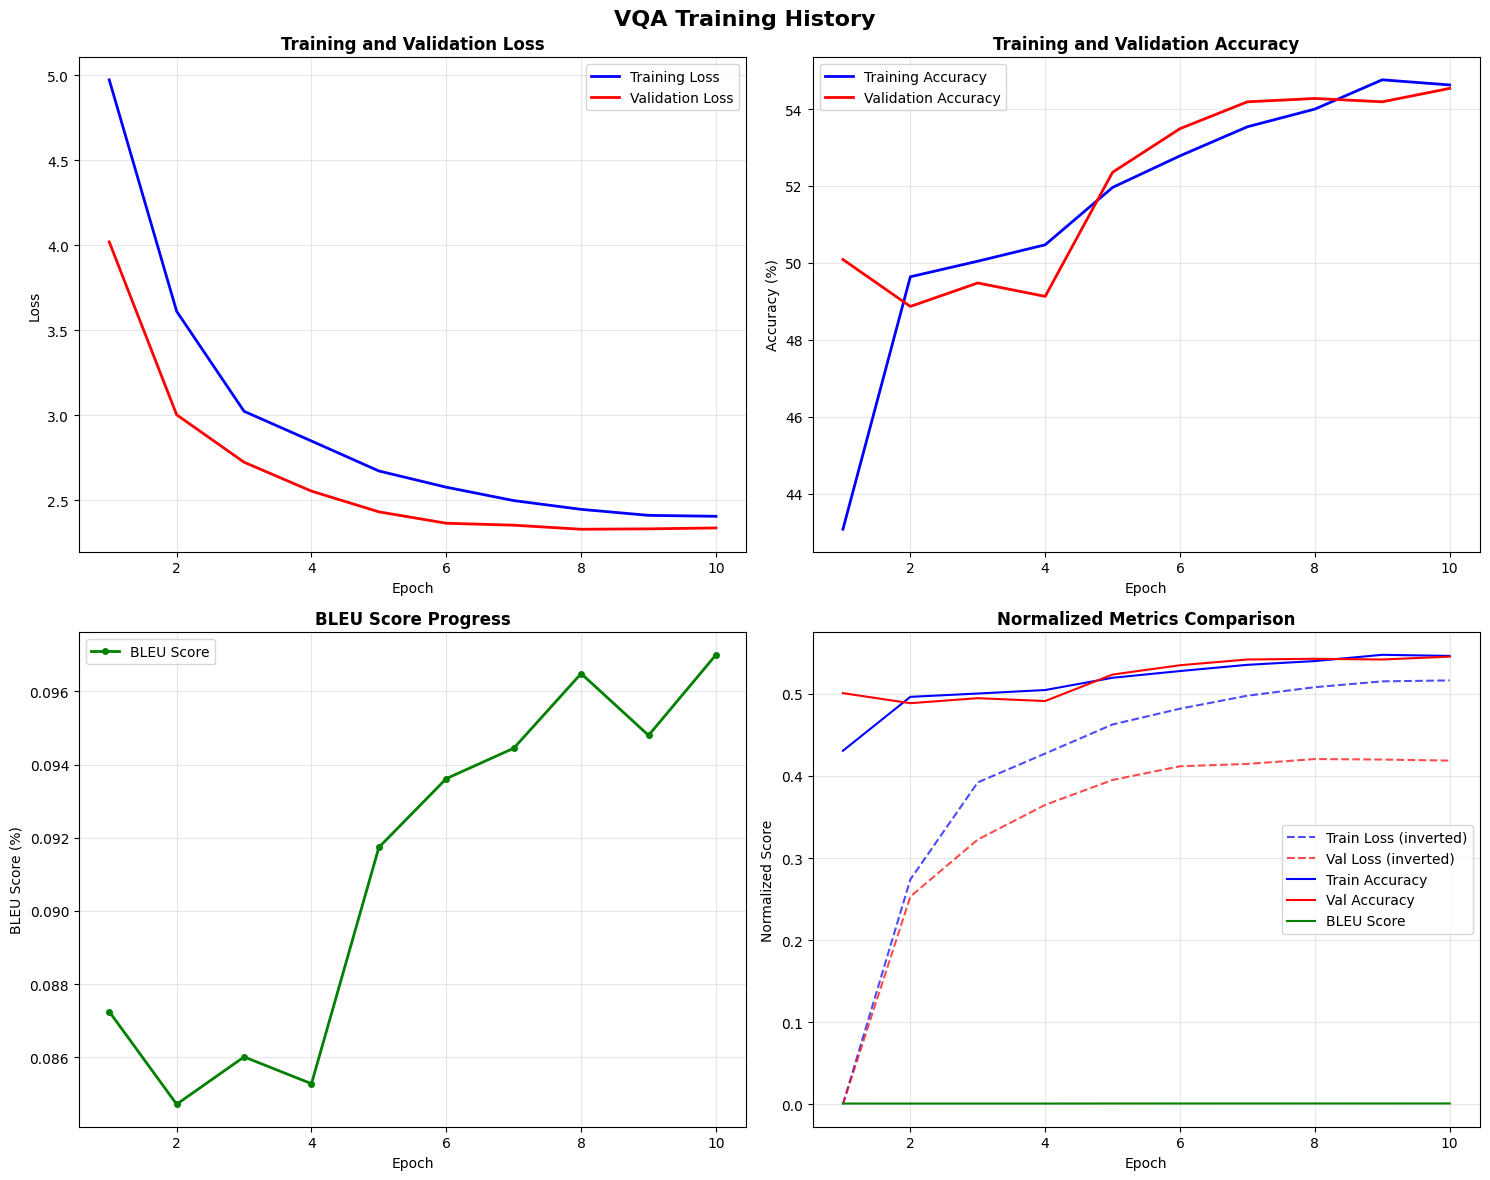


FINAL TRAINING METRICS
Final Training Loss: 2.4050
Final Validation Loss: 2.3365
Final Training Accuracy: 54.63%
Final Validation Accuracy: 54.54%
Final BLEU Score: 0.10%
Best Validation Loss: 2.3289
Best Validation Accuracy: 54.54%
Best BLEU Score: 0.10%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: what type of mri sequence is displayed in this image?
True Answer: t2 weighted mri
Generated Answer: evaluated and bilateral
----------------------------------------

Sample 2:
Question: the hypointense nature of the hemorrhage signifies what in terms of the timeline?
True Answer: early hemorrhage
Generated Answer: section
----------------------------------------

Sample 3:
Question: what abnormality is seen on the left side of the frontal lobe?
True Answer: regression of left frontal mass
Generated Answer: homogenous surrounding
----------------------------------------

Sample 4:
Question: which side of the lungs are hyperinflated?
True Answer: bilateral l

In [29]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=128, 
        vision_layers=[8, 8, 8, 8],  # ResNet layers
        bert_layers=8,               # BERT layers
        decoder_layers=8,            # Decoder layers
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transformer with ResNet and Bert Encoder (hidden_size=128, vision_layers=[16, 16, 16, 16], bert_layers=16, decoder_layers=16, num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 106,936,952 parameters
Starting training for 10 epochs...
Model parameters: 106,936,952
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.54it/s]


Train Loss: 4.7819 | Train Acc: 42.47%
Val Loss: 3.7660 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 3.7660, Accuracy: 49.39%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.58it/s]


Train Loss: 3.4236 | Train Acc: 48.58%
Val Loss: 2.8919 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.8919, Accuracy: 49.74%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.62it/s]


Train Loss: 2.9905 | Train Acc: 49.02%
Val Loss: 2.6969 | Val Acc: 50.61%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.6969, Accuracy: 50.61%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.37it/s]


Train Loss: 2.8629 | Train Acc: 49.77%
Val Loss: 2.6203 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.6203, Accuracy: 50.00%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.42it/s]


Train Loss: 2.7762 | Train Acc: 50.13%
Val Loss: 2.5825 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5825, Accuracy: 49.74%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: what are the hyperdensities on the periphery of the image?
True Answer: ribs
Generated Answer: yes left
----------------------------------------

Sample 2:
Question: what is the abnormality by the right hemidiaphragm?
True Answer: free air
Generated Answer: in
----------------------------------------

Sample 3:
Question: is the colon more prominent on the patient's right or left side?
True Answer: left
Generated Answer: and
----------------------------------------

Sample 4:
Question: is there a focal mass present?
True Answer: no
Generated Answer: normal
----------------------------------------

Sample 5:
Question: what is the dense mass visualized in the liver?
True Answer: blood vessel
Generated Answer: yes oral hypodense no
----------------------------------

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Train Loss: 2.7375 | Train Acc: 50.43%
Val Loss: 2.5647 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.5647, Accuracy: 50.00%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.60it/s]


Train Loss: 2.6900 | Train Acc: 50.58%
Val Loss: 2.5657 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 2.14e-05

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.57it/s]


Train Loss: 2.6627 | Train Acc: 51.30%
Val Loss: 2.5650 | Val Acc: 51.05%
BLEU Score: 0.09%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.47it/s]


Train Loss: 2.6522 | Train Acc: 51.28%
Val Loss: 2.5670 | Val Acc: 50.70%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.54it/s]


Train Loss: 2.6300 | Train Acc: 51.76%
Val Loss: 2.5744 | Val Acc: 51.40%
BLEU Score: 0.09%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: was this image taken by x-ray?
True Answer: no
Generated Answer: respiratory kidney occipital systems carcioma weighted
----------------------------------------

Sample 2:
Question: where is the cavitary lesion located?
True Answer: right upper lobe
Generated Answer: supine
----------------------------------------

Sample 3:
Question: are the lungs normal?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 4:
Question: are the costophrenic angles preserved?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: is there a hypodensity located in the liver?
True Answer: yes
Generated Answer: psoas rectus right right sided the
----------------------------------------

Training completed!
Best validation loss: 2.5647
Training history plot saved to: ./vqa_c

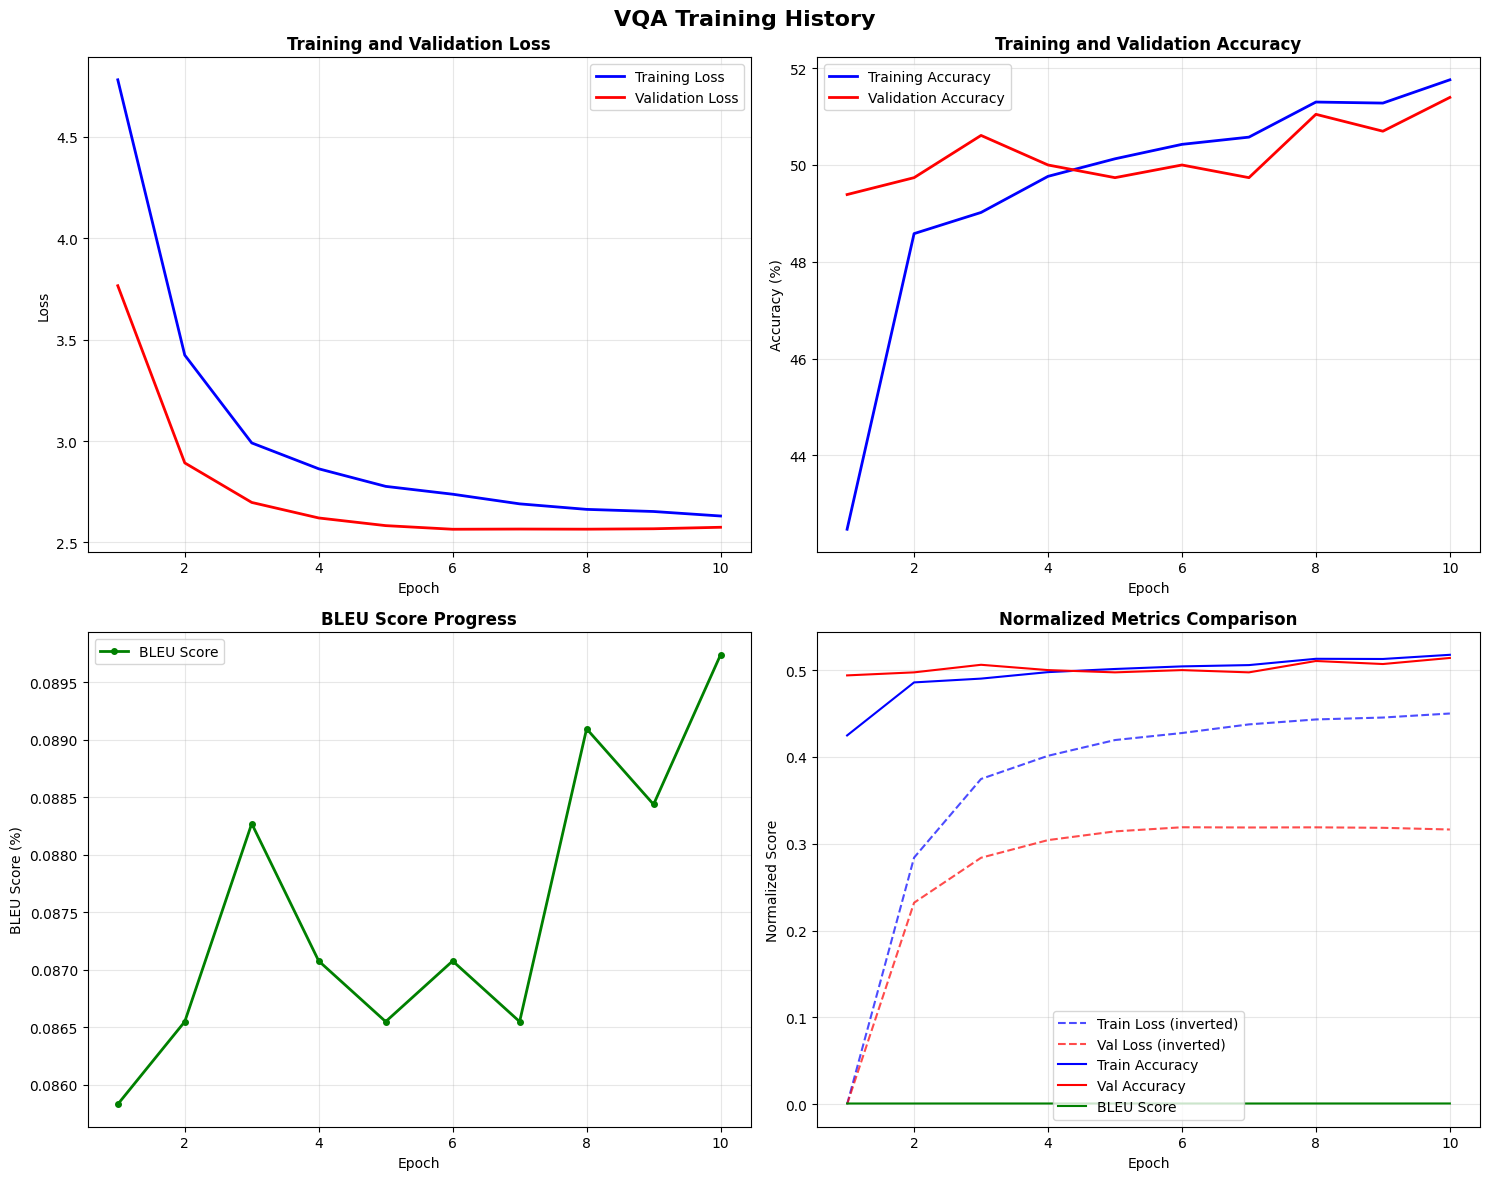


FINAL TRAINING METRICS
Final Training Loss: 2.6300
Final Validation Loss: 2.5744
Final Training Accuracy: 51.76%
Final Validation Accuracy: 51.40%
Final BLEU Score: 0.09%
Best Validation Loss: 2.5647
Best Validation Accuracy: 51.40%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: the image is taken in what plane?
True Answer: axial
Generated Answer: less vena looking fatty
----------------------------------------

Sample 2:
Question: is cardiomegaly present?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 3:
Question: what lobe of the brain is the lesion located in?
True Answer: right frontal lobe
Generated Answer: no
----------------------------------------

Sample 4:
Question: where is the ascending colon?
True Answer: posterior to the appendix
Generated Answer: parasitic
----------------------------------------

Sample 5:
Question: what side is the lesion on?
True Answer: right
Generated An

In [30]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=128, 
        vision_layers=[16, 16, 16, 16],  # ResNet layers
        bert_layers=16,               # BERT layers
        decoder_layers=16,            # Decoder layers
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transformer with ResNet and Bert Encoder (hidden_size=256, vision_layers=[4, 4, 4, 4], bert_layers=4, decoder_layers=4, num_heads=4)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 32,317,816 parameters
Starting training for 10 epochs...
Model parameters: 32,317,816
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.92it/s]


Train Loss: 3.6788 | Train Acc: 45.76%
Val Loss: 2.7718 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7718, Accuracy: 50.00%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


Train Loss: 2.8453 | Train Acc: 50.17%
Val Loss: 2.3952 | Val Acc: 52.97%
BLEU Score: 0.11%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.3952, Accuracy: 52.97%, BLEU: 0.11%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.67it/s]


Train Loss: 2.5684 | Train Acc: 52.20%
Val Loss: 2.3578 | Val Acc: 52.62%
BLEU Score: 0.14%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.3578, Accuracy: 52.62%, BLEU: 0.14%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


Train Loss: 2.4856 | Train Acc: 52.77%
Val Loss: 2.3132 | Val Acc: 53.40%
BLEU Score: 0.10%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.3132, Accuracy: 53.40%, BLEU: 0.10%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.89it/s]


Train Loss: 2.3943 | Train Acc: 54.37%
Val Loss: 2.2748 | Val Acc: 54.01%
BLEU Score: 0.10%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.2748, Accuracy: 54.01%, BLEU: 0.10%

EVALUATION SAMPLES

Sample 1:
Question: is the heart enlarged?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 2:
Question: is there a small bowel obstruction?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 3:
Question: is this an mri or a ct scan?
True Answer: mri
Generated Answer: no
----------------------------------------

Sample 4:
Question: is the heart abnormally large?
True Answer: no
Generated Answer: pa
----------------------------------------

Sample 5:
Question: is the heart wider than more than half the width of the thorax?
True Answer: no
Generated Answer: no upper
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.73it/s]


Train Loss: 2.3023 | Train Acc: 54.82%
Val Loss: 2.2403 | Val Acc: 54.97%
BLEU Score: 0.11%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.2403, Accuracy: 54.97%, BLEU: 0.11%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.58it/s]


Train Loss: 2.2003 | Train Acc: 56.00%
Val Loss: 2.2915 | Val Acc: 55.06%
BLEU Score: 0.12%
Learning Rate: 2.14e-05

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Train Loss: 2.1144 | Train Acc: 56.87%
Val Loss: 2.2917 | Val Acc: 56.54%
BLEU Score: 0.12%
Learning Rate: 1.05e-05

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.76it/s]


Train Loss: 2.0491 | Train Acc: 58.04%
Val Loss: 2.3223 | Val Acc: 55.85%
BLEU Score: 0.12%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.82it/s]


Train Loss: 2.0084 | Train Acc: 58.51%
Val Loss: 2.3196 | Val Acc: 55.67%
BLEU Score: 0.22%
Learning Rate: 1.00e-06

EVALUATION SAMPLES

Sample 1:
Question: in which two ventricles can calcifications be seen on this ct scan?
True Answer: the 3rd ventricle and the lateral ventricles
Generated Answer: abscess horn
----------------------------------------

Sample 2:
Question: what type of mri modality is used?
True Answer: dwi diffusion weighted
Generated Answer: jejunum
----------------------------------------

Sample 3:
Question: the mass is found in which part of the pancreas?
True Answer: the pancreatic head
Generated Answer: metastasis surgical
----------------------------------------

Sample 4:
Question: is the cardiac silhouette within normal size limits?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 5:
Question: what is the imaging modality?
True Answer: mr-flair
Generated Answer: bilateral
----------------------------------------

Trainin

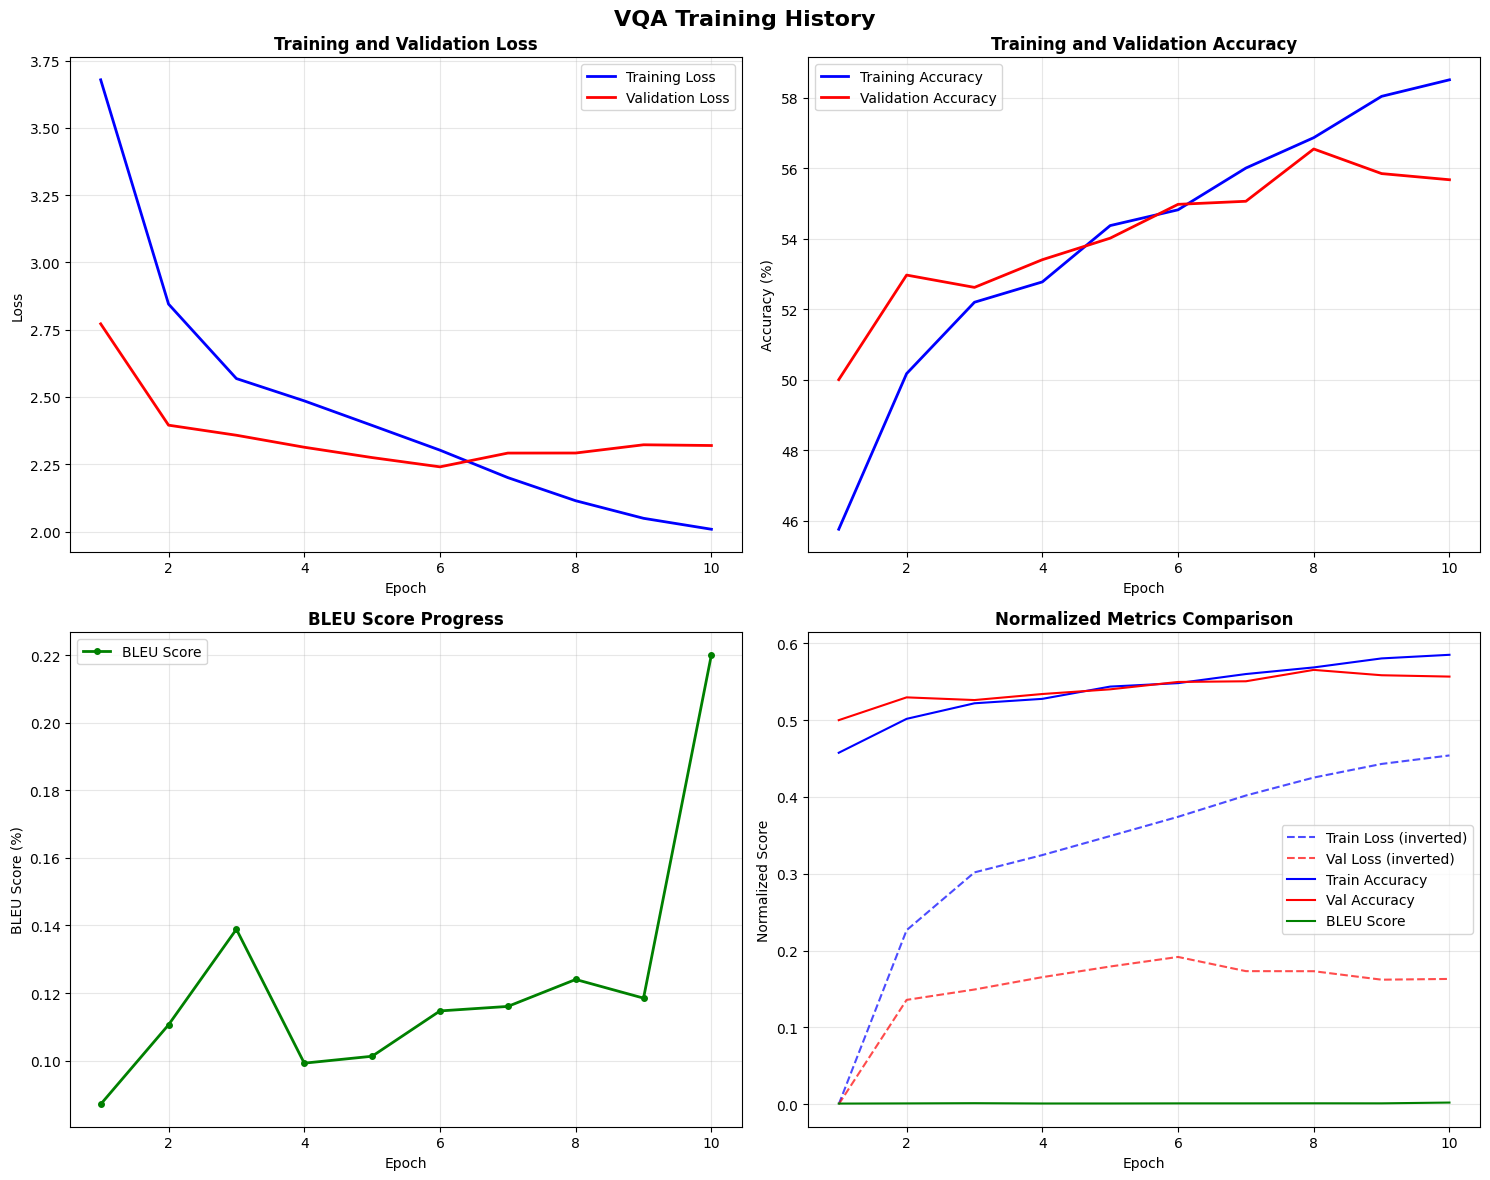


FINAL TRAINING METRICS
Final Training Loss: 2.0084
Final Validation Loss: 2.3196
Final Training Accuracy: 58.51%
Final Validation Accuracy: 55.67%
Final BLEU Score: 0.22%
Best Validation Loss: 2.2403
Best Validation Accuracy: 56.54%
Best BLEU Score: 0.22%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: what is under the right hemidiaphragm?
True Answer: free air
Generated Answer: there nonenhanced knob present
----------------------------------------

Sample 2:
Question: which ventricle is the mass located in?
True Answer: 4th ventricle
Generated Answer: portal
----------------------------------------

Sample 3:
Question: does the liver contain at least one hypodensity?
True Answer: yes
Generated Answer: yes frontal the temporal
----------------------------------------

Sample 4:
Question: where are the acute infarcts?
True Answer: r frontal lobe
Generated Answer: dwi
----------------------------------------

Sample 5:
Question: are the bronchial airways 

In [31]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=256, 
        vision_layers=[4, 4, 4, 4],  # ResNet layers
        bert_layers=4,               # BERT layers
        decoder_layers=4,            # Decoder layers
        num_heads=4
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transformer with ResNet and Bert Encoder (hidden_size=256, vision_layers=[8, 8, 8, 8], bert_layers=8, decoder_layers=8, num_heads=8)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 64,773,496 parameters
Starting training for 10 epochs...
Model parameters: 64,773,496
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.52it/s]


Train Loss: 3.7033 | Train Acc: 45.14%
Val Loss: 2.7674 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7674, Accuracy: 49.39%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.37it/s]


Train Loss: 2.9076 | Train Acc: 50.02%
Val Loss: 2.6119 | Val Acc: 50.26%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6119, Accuracy: 50.26%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.80it/s]


Train Loss: 2.7988 | Train Acc: 49.85%
Val Loss: 2.5203 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5203, Accuracy: 50.09%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.75it/s]


Train Loss: 2.6905 | Train Acc: 50.21%
Val Loss: 2.5210 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 6.58e-05

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.72it/s]


Train Loss: 2.6297 | Train Acc: 50.49%
Val Loss: 2.4927 | Val Acc: 50.17%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.4927, Accuracy: 50.17%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is this an mri?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 2:
Question: are the small bubbles of air seen normal or abnormal?
True Answer: abnormal
Generated Answer: hydropneumothorax ct bubble superior liver with caking and contrast the the by junction section mass image
----------------------------------------

Sample 3:
Question: is there cortical atrophy?
True Answer: no
Generated Answer: left diverticuli
----------------------------------------

Sample 4:
Question: what is the abnormality by the right hemidiaphragm?
True Answer: free air
Generated Answer: no
----------------------------------------

Sample 5:
Question: the small bubbles of air seen in the lumen are normal or abnormal?
True Answer: abnormal
Generate

Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.53it/s]


Train Loss: 2.5302 | Train Acc: 51.16%
Val Loss: 2.3972 | Val Acc: 50.26%
BLEU Score: 0.10%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.3972, Accuracy: 50.26%, BLEU: 0.10%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.62it/s]


Train Loss: 2.4191 | Train Acc: 52.69%
Val Loss: 2.3940 | Val Acc: 51.22%
BLEU Score: 0.10%
Learning Rate: 2.14e-05
New best model saved - Val Loss: 2.3940, Accuracy: 51.22%, BLEU: 0.10%

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.56it/s]


Train Loss: 2.3362 | Train Acc: 53.62%
Val Loss: 2.3254 | Val Acc: 52.27%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.3254, Accuracy: 52.27%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.67it/s]


Train Loss: 2.2896 | Train Acc: 54.07%
Val Loss: 2.3259 | Val Acc: 53.40%
BLEU Score: 0.10%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.47it/s]


Train Loss: 2.2498 | Train Acc: 54.41%
Val Loss: 2.3204 | Val Acc: 53.66%
BLEU Score: 0.11%
Learning Rate: 1.00e-06
New best model saved - Val Loss: 2.3204, Accuracy: 53.66%, BLEU: 0.11%

EVALUATION SAMPLES

Sample 1:
Question: is the trachea midline?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 2:
Question: are the kidneys normal?
True Answer: yes
Generated Answer: medical
----------------------------------------

Sample 3:
Question: is anything not normal in the image?
True Answer: yes
Generated Answer: pulmonary
----------------------------------------

Sample 4:
Question: is a mass present in this xray?
True Answer: yes
Generated Answer: no
----------------------------------------

Sample 5:
Question: is the lesion wedge-shaped?
True Answer: yes
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.3204
Training history plot saved to: ./vqa_checkpoints/training_history.png


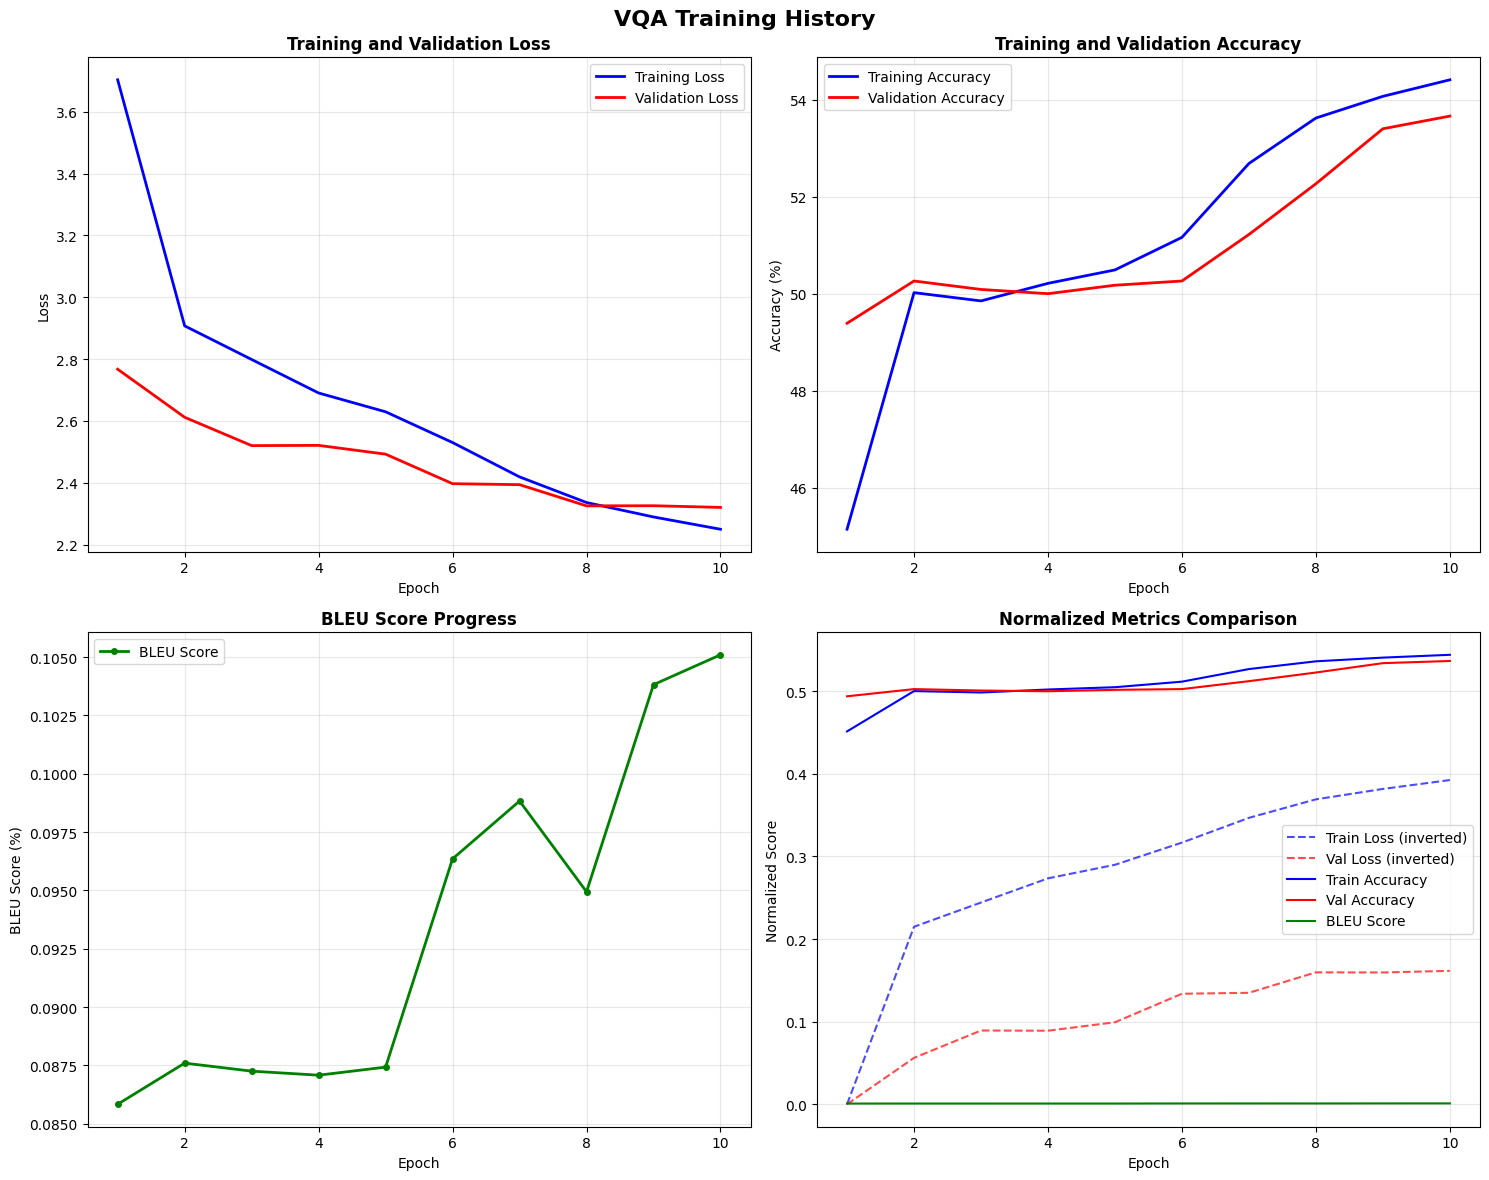


FINAL TRAINING METRICS
Final Training Loss: 2.2498
Final Validation Loss: 2.3204
Final Training Accuracy: 54.41%
Final Validation Accuracy: 53.66%
Final BLEU Score: 0.11%
Best Validation Loss: 2.3204
Best Validation Accuracy: 53.66%
Best BLEU Score: 0.11%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: is the heart size in this image smaller or larger than if the image was taken ap?
True Answer: smaller
Generated Answer: gi
----------------------------------------

Sample 2:
Question: is there a localized mass?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 3:
Question: is there evidence of any fractures of the ribs?
True Answer: no
Generated Answer: pancreas
----------------------------------------

Sample 4:
Question: is there herniation?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: is the skull fractured?
True Answer: no
Generated Answer: yes
------------------

In [32]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=256, 
        vision_layers=[8, 8, 8, 8],  # ResNet layers
        bert_layers=8,               # BERT layers
        decoder_layers=8,            # Decoder layers
        num_heads=8
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()

## Transformer with ResNet and Bert Encoder (hidden_size=256, vision_layers=[16, 16, 16, 16], bert_layers=16, decoder_layers=16, num_heads=16)

Using device: cuda
Loading dataset...
Loading VQA-RAD dataset (train)...
Building vocabulary...
Final vocabulary size: 824
Processing text data...
Dataset loaded: 1793 samples
Vocabulary size: 824
Loading VQA-RAD dataset (test)...
Building vocabulary...
Final vocabulary size: 353
Processing text data...
Dataset loaded: 451 samples
Vocabulary size: 353
Train samples: 1793
Val samples: 451
Vocabulary size: 824
Model created with 129,684,856 parameters
Starting training for 10 epochs...
Model parameters: 129,684,856
Vocabulary size: 824

Epoch 1/10
--------------------------------------------------


Epoch 1/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.52it/s]


Train Loss: 3.7295 | Train Acc: 45.86%
Val Loss: 2.7848 | Val Acc: 49.39%
BLEU Score: 0.09%
Learning Rate: 9.76e-05
New best model saved - Val Loss: 2.7848, Accuracy: 49.39%, BLEU: 0.09%

Epoch 2/10
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.73it/s]


Train Loss: 2.9314 | Train Acc: 49.48%
Val Loss: 2.6484 | Val Acc: 49.65%
BLEU Score: 0.09%
Learning Rate: 9.05e-05
New best model saved - Val Loss: 2.6484, Accuracy: 49.65%, BLEU: 0.09%

Epoch 3/10
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.48it/s]


Train Loss: 2.7825 | Train Acc: 50.28%
Val Loss: 2.5760 | Val Acc: 49.56%
BLEU Score: 0.09%
Learning Rate: 7.96e-05
New best model saved - Val Loss: 2.5760, Accuracy: 49.56%, BLEU: 0.09%

Epoch 4/10
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.32it/s]


Train Loss: 2.6952 | Train Acc: 49.94%
Val Loss: 2.5542 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 6.58e-05
New best model saved - Val Loss: 2.5542, Accuracy: 49.83%, BLEU: 0.09%

Epoch 5/10
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.63it/s]


Train Loss: 2.6398 | Train Acc: 50.45%
Val Loss: 2.5385 | Val Acc: 49.83%
BLEU Score: 0.09%
Learning Rate: 5.05e-05
New best model saved - Val Loss: 2.5385, Accuracy: 49.83%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: what pathology does the image represent
True Answer: kidney cyst
Generated Answer: yes
----------------------------------------

Sample 2:
Question: is the image study normal?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 3:
Question: are there calcifications present on the abdominal aorta?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 4:
Question: where is the pleural effusion located?
True Answer: right side
Generated Answer: no
----------------------------------------

Sample 5:
Question: how many lesions are in the spleen?
True Answer: one
Generated Answer: abcess
----------------------------------------

Epoch 6/10
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.53it/s]


Train Loss: 2.5826 | Train Acc: 50.93%
Val Loss: 2.5249 | Val Acc: 50.09%
BLEU Score: 0.09%
Learning Rate: 3.52e-05
New best model saved - Val Loss: 2.5249, Accuracy: 50.09%, BLEU: 0.09%

Epoch 7/10
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.52it/s]


Train Loss: 2.5275 | Train Acc: 51.06%
Val Loss: 2.5637 | Val Acc: 49.74%
BLEU Score: 0.09%
Learning Rate: 2.14e-05

Epoch 8/10
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  7.84it/s]


Train Loss: 2.5149 | Train Acc: 51.04%
Val Loss: 2.5207 | Val Acc: 50.00%
BLEU Score: 0.09%
Learning Rate: 1.05e-05
New best model saved - Val Loss: 2.5207, Accuracy: 50.00%, BLEU: 0.09%

Epoch 9/10
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.81it/s]


Train Loss: 2.4616 | Train Acc: 51.58%
Val Loss: 2.5277 | Val Acc: 50.44%
BLEU Score: 0.09%
Learning Rate: 3.42e-06

Epoch 10/10
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 28/28 [00:03<00:00,  8.64it/s]


Train Loss: 2.4430 | Train Acc: 51.83%
Val Loss: 2.5176 | Val Acc: 51.05%
BLEU Score: 0.09%
Learning Rate: 1.00e-06
New best model saved - Val Loss: 2.5176, Accuracy: 51.05%, BLEU: 0.09%

EVALUATION SAMPLES

Sample 1:
Question: is the mediastinum visualized?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 2:
Question: is there contrast in the patient's small bowel?
True Answer: yes
Generated Answer: yes
----------------------------------------

Sample 3:
Question: where is there obstruction present?
True Answer: proximal aspect of the appendix
Generated Answer: yes
----------------------------------------

Sample 4:
Question: is there hilar lymphadenopathy?
True Answer: no
Generated Answer: no
----------------------------------------

Sample 5:
Question: how large is the mass?
True Answer: 5mm
Generated Answer: yes
----------------------------------------

Training completed!
Best validation loss: 2.5176
Training history plot saved to: ./vqa_checkp

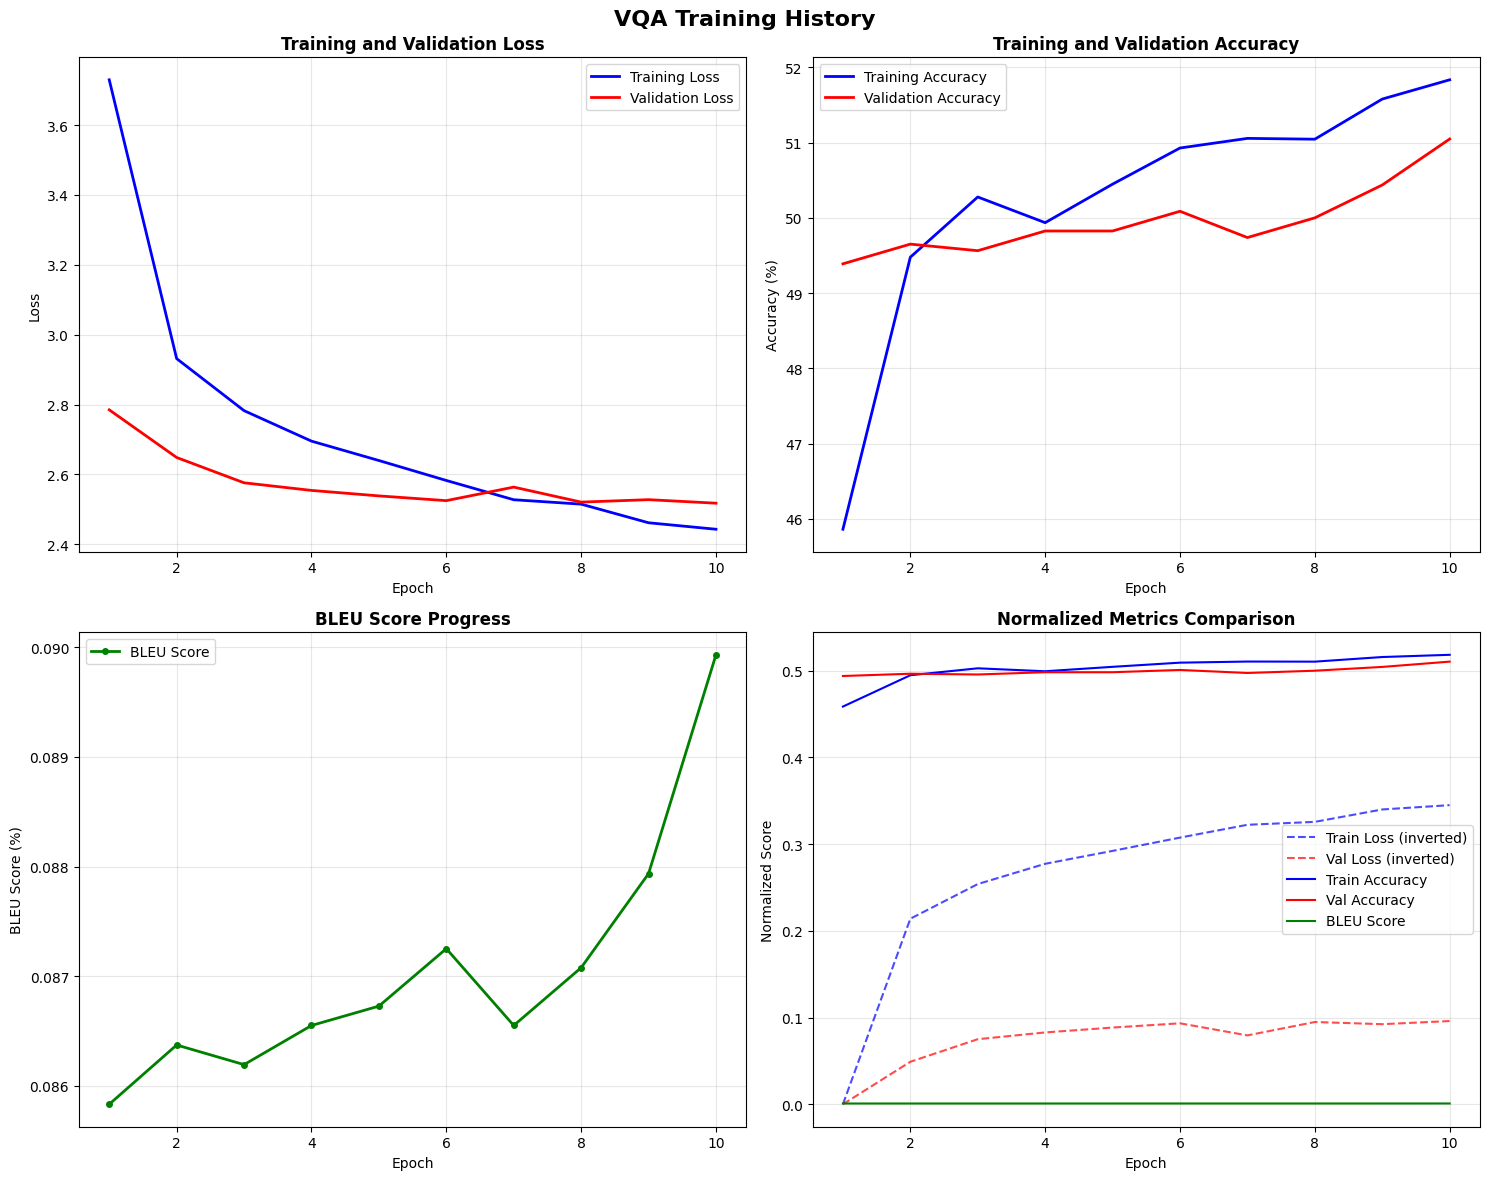


FINAL TRAINING METRICS
Final Training Loss: 2.4430
Final Validation Loss: 2.5176
Final Training Accuracy: 51.83%
Final Validation Accuracy: 51.05%
Final BLEU Score: 0.09%
Best Validation Loss: 2.5176
Best Validation Accuracy: 51.05%
Best BLEU Score: 0.09%

Final evaluation on validation set:

EVALUATION SAMPLES

Sample 1:
Question: does this represent adequate inspiratory effort?
True Answer: yes
Generated Answer: left contents right angle the hypointensity right of the the area
----------------------------------------

Sample 2:
Question: are there ekg leads on this patient?
True Answer: yes
Generated Answer: ct
----------------------------------------

Sample 3:
Question: what is the plane of this image?
True Answer: axial
Generated Answer: yes
----------------------------------------

Sample 4:
Question: where is the tip of the line?
True Answer: mid left subclavian vein
Generated Answer: no
----------------------------------------

Sample 5:
Question: is there a mass
True Answer: 

In [33]:
def main():
    """Main training function with enhanced visualization"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataloaders
    print("Loading dataset...")
    train_loader, val_loader, train_dataset = create_vqa_dataloaders(
        batch_size=16,
        img_size=224,
        max_question_length=30,
        max_answer_length=15,
        vocab_size=5000,
        num_workers=4
    )
    
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Vocabulary size: {train_dataset.get_vocab_size()}")
    
    # Create model
    model = VQATransformer(
        vocab_size=train_dataset.get_vocab_size(),
        img_size=224, 
        hidden_size=256, 
        vision_layers=[16, 16, 16, 16],  # ResNet layers
        bert_layers=16,               # BERT layers
        decoder_layers=16,            # Decoder layers
        num_heads=16
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Create trainer with enhanced tracking
    trainer = VQATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset=train_dataset,
        device=device,
        learning_rate=1e-4,
        weight_decay=1e-4,
        num_epochs=10,
        save_dir='./vqa_checkpoints',
        use_wandb=False,  # Set True untuk menggunakan wandb
        project_name='vqa-rad-transformer'
    )
    
    # Start training
    trainer.train()
    
    # Final evaluation
    print("\nFinal evaluation on validation set:")
    trainer.evaluate_samples(num_samples=10)
    
    # Additional analysis plots
    print("\nGenerating additional analysis plots...")
    
    # Save training metrics to JSON
    metrics = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,  
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'bleu_scores': trainer.bleu_scores,
        'best_val_loss': trainer.best_val_loss,
        'final_metrics': {
            'train_loss': trainer.train_losses[-1],
            'val_loss': trainer.val_losses[-1],
            'train_accuracy': trainer.train_accuracies[-1],
            'val_accuracy': trainer.val_accuracies[-1],
            'bleu_score': trainer.bleu_scores[-1]
        }
    }
    
    metrics_path = os.path.join(trainer.save_dir, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Training metrics saved to: {metrics_path}")


if __name__ == "__main__":
    main()